
## Crime Rate Prediction in San Francisco City (2018) 

This assignment is about predicting Crime Rate in San Francisco City. 
The dataset is available at this website https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783

Please note that the data is only available for incidents reported after 2018 as there is a migration of system from source system.

A copy of this .csv is available under datasets (folder). Since it is updated daily, a time-stamped copy retrieved at 20210513 is used for this assignment

The target variable is the type of crime predicted - this is a multiclass discrete variable

## 0. Problem Statement : Given a location, time, are we able to predict the crime type that's going to happen? 
( Let's find out! )

In [1]:
# Other libraries used besides numpy, pandas, seaborn : folium, imblearn, yellowbrick , XGBClassifier, scikit-plot, pycm

In [2]:
#Optional : a district geojson is downloaded from data.sfgov.sg - it is used to plot the specific districts that is mapped to 
# PD_DISTRICT in the dataset - this is used to get a visual map of the districts

### Dataset - Its Fields and Description


|	No.	|	Field	|	Remark	|	Field Type	|	Further Remarks	|
|:-----:|:---------:|:---------:|:-------------:|:-----------------:|
|	1	|	Incident Datetime	|	The date and time when the incident occurred	|	Datetime	|		|
|	2	|	Incident Date	|	The date the incident occurred	|	Date	|		|
|	3	|	Incident Time	|	The time the incident occurred	|	String 	|		|
|	4	|	Incident Year	|	The year the incident occurred, provided as a convenience for filtering	|	String 	|		|
|	5	|	Incident Day of Week	|	The day of week the incident occurred	|	String 	|		|
|	6	|	Report Datetime	|	Distinct from Incident Datetime, Report Datetime is when the report was filed.	|	Datetime	|		|
|	7	|	Row ID	|	A unique identifier for each row of data in the dataset	|	Numeric 	|		|
|	8	|	Incident ID	|	This is the system generated identifier for incident reports. Incident IDs and Incident Numbers both uniquely identify reports, but Incident Numbers are used when referencing cases and report documents.	|	Numeric 	|		|
|	9	|	Incident Number	|	The number issued on the report, sometimes interchangeably referred to as the Case Number. This number is used to reference cases and report documents.	|	Numeric 	|		|
|	10	|	CAD Number	|	The Computer Aided Dispatch (CAD) is the system used by the Department of Emergency Management (DEM) to dispatch officers and other public safety personnel. 	|	Numeric 	|		|
|	11	|	Report Type Code	|	A system code for report types, these have corresponding descriptions within the dataset.	|	String 	|	Likely to be related to Report Type Code 	|
|	12	|	Report Type Description	|	The description of the report type, can be one of: Initial; Initial Supplement; Vehicle Initial; Vehicle Supplement; Coplogic Initial; Coplogic Supplement	|	String 	|		|
|	13	|	Filed Online	|	If non-emergency cases are filed through Coplogic (a self-service platform), this will be flagged as TRUE 	|	String 	|	TRUE or blank	|
|	14	|	Incident Code	|	Incident Codes are the system codes to describe a type of incident. A single incident report can have one or more incident types associated. In those cases you will see multiple rows representing a unique combination of the Incident ID and Incident Code.	|	Numeric 	|		|
|	15	|	Incident Category	|	A category mapped on to the Incident Code used in statistics and reporting. Mappings provided by the Crime Analysis Unit of the Police Department.	|	String 	|	This is the target variable	|
|	16	|	Incident Subcategory	|	A subcategory mapped to the Incident Code that is used for statistics and reporting. Mappings are provided by the Crime Analysis Unit of the Police Department.	|	String 	|		|
|	17	|	Incident Description	|	The description of the incident that corresponds with the Incident Code. 	|	String 	|		|
|	18	|	Resolution	|	The resolution of the incident at the time of the report.Note: once a report is filed, the Resolution will not change. 	|	String 	| -Cite or Arrest Adult <br>-Cite or Arrest Juvenile<br/>-Exceptional Adult<br/>-Exceptional Juvenile<br/>-Open or Active<br/>*Unfounded<br/>	|
|	19	|	Intersection	|	The 2 or more street names that intersect closest to the original incident separated by a backward slash (\).	|	String 	|		|
|	20	|	CNN	|	The unique identifier of the intersection for reference back to other related basemap datasets.	|	Numeric 	|		|
|	21	|	Police District	|	The Police District where the incident occurred. 	|	String 	|		|
|	22	|	Analysis Neighborhood	|	This field is used to identify the neighborhood where each incident occurs. Related to intersection field; a district has multiple neighbourhoods	|	String 	|		|
|	23	|	Supervisor District	| The legislative body no. that is assigned to the district  - districts are numbered 1 through 11 - Not a 1-1 mapping to police district	|	Numeric 	|		|
|	24	|	Latitude	| The latitude coordinate in WGS84, spatial reference is EPSG:4326 ; EPSG:4326 is geographic, non-project coordinate system. It is used in lat, longs GPS displays"	|	Numeric 	|		|
|	25	|	Longitude	| The longitude coordinate in WGS84, spatial reference is EPSG:4326 ; EPSG:4326 is geographic, non-project coordinate system. It is used in lat, longs GPS displays"	|	Numeric 	|		|
|	26	|	shape	|	Geolocation in OGC WKT format (e.g, POINT(37.4,-122.3) - ie. (longitude, latitude ) 	|	shape object 	|		|
|	27	|	Neighborhoods	|	Not clear- not explained in website 	|	Numeric 	|		|


### 1. Drop obvious non-necessary columns

All these following columns are deemed as non-necessary for this report and will not be imported for this analysis

Field	|	Reason for Not Being Imported
:---------:|:-----------:
CAD Number              	|	This number is from Emergency System used in SF Police. Not important to the type of crime prediction
Filed Online            	|	Whether it is filed online is not impt to crime rate prediction
Intersection            	|	This is used to mark the intersection in map - not used. Latitude and longitude are more useful
CNN                     	|	Related to Intersection in mapping dataset; not particulrly useful in prediction unless we are certain intersection influences crime rate 
Supervisor District     	|	Not important in this analysis since crime offenders do not generally care about the legistrative body of the district during crime act

In [3]:
import pandas as pd
import folium
import joblib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [4]:
#set the display ooptions for pandas for easier troubleshooting
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
#21 columns are used initially
used_columns = ['Incident Datetime', 'Incident Date', 'Incident Time', 'Incident Year', 'Incident Day of Week', 
                'Report Datetime', 'Row ID', 'Incident ID', 'Incident Number', 'Report Type Code', 
                'Report Type Description', 'Incident Code', 'Incident Category', 'Incident Subcategory', 'Incident Description',
                'Resolution', 'Police District', 'Analysis Neighborhood', 'Latitude', 'Longitude', 'shape', 'Neighborhoods']
police_incidents_file = 'datasets/SF_Incidents_2018_to_Present_20210513.csv'

#sf_input = pd.read_csv(police_incidents_file, usecols=used_columns)

sf_input = pd.read_csv(police_incidents_file, usecols=used_columns,parse_dates=['Incident Datetime'])


In [6]:
sf_input.info()

### 2. Rename the columns for easier manipulation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457041 entries, 0 to 457040
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Incident Datetime        457041 non-null  datetime64[ns]
 1   Incident Date            457041 non-null  object        
 2   Incident Time            457041 non-null  object        
 3   Incident Year            457041 non-null  int64         
 4   Incident Day of Week     457041 non-null  object        
 5   Report Datetime          457041 non-null  object        
 6   Row ID                   457041 non-null  int64         
 7   Incident ID              457041 non-null  int64         
 8   Incident Number          457041 non-null  int64         
 9   Report Type Code         457041 non-null  object        
 10  Report Type Description  457041 non-null  object        
 11  Incident Code            457041 non-null  int64         
 12  Incident Categor

In [7]:
#Let's get rid of those spaces.
old_columns = ['Incident Datetime', 'Incident Date', 'Incident Time', 
               'Incident Year', 'Incident Day of Week', 'Report Datetime', 
               'Row ID', 'Incident ID', 'Incident Number', 'Report Type Code', 
               'Report Type Description', 'Incident Code', 'Incident Category', 
               'Incident Subcategory', 'Incident Description', 'Police District', 'Analysis Neighborhood' ]


new_columns = [ 'Incident_Datetime', 'Incident_Date', 'Incident_Time', 'Incident_Year', 
               'Incident_DayofWeek', 'Report_Datetime', 'RowID', 'IncidentID', 
               'Incident_No', 'ReportType_Code', 'ReportType_Desc', 'Incident_Code', 
               'Incident_Category', 'Incident_Subcategory', 'Incident_Desc', 'PD_District', 'Analysis_Neighborhood' ]
renamedColumns = dict ( zip (old_columns, new_columns) )

In [8]:
for k, v in renamedColumns.items():
    #print ( "KEY %s VALUE %s", k, v )
    print('key [{0}] :> [{1}]'.format(k, v))

key [Incident Datetime] :> [Incident_Datetime]
key [Incident Date] :> [Incident_Date]
key [Incident Time] :> [Incident_Time]
key [Incident Year] :> [Incident_Year]
key [Incident Day of Week] :> [Incident_DayofWeek]
key [Report Datetime] :> [Report_Datetime]
key [Row ID] :> [RowID]
key [Incident ID] :> [IncidentID]
key [Incident Number] :> [Incident_No]
key [Report Type Code] :> [ReportType_Code]
key [Report Type Description] :> [ReportType_Desc]
key [Incident Code] :> [Incident_Code]
key [Incident Category] :> [Incident_Category]
key [Incident Subcategory] :> [Incident_Subcategory]
key [Incident Description] :> [Incident_Desc]
key [Police District] :> [PD_District]
key [Analysis Neighborhood] :> [Analysis_Neighborhood]


In [9]:
sf_input.rename(columns=renamedColumns, inplace=True)

In [10]:
sf_input.columns

Index(['Incident_Datetime', 'Incident_Date', 'Incident_Time', 'Incident_Year', 'Incident_DayofWeek', 'Report_Datetime', 'RowID', 'IncidentID', 'Incident_No', 'ReportType_Code', 'ReportType_Desc', 'Incident_Code', 'Incident_Category', 'Incident_Subcategory', 'Incident_Desc', 'Resolution', 'PD_District', 'Analysis_Neighborhood', 'Latitude', 'Longitude', 'shape', 'Neighborhoods'], dtype='object')

In [11]:
sf_input.head(10)

Incident_Datetime Incident_Date Incident_Time  Incident_Year Incident_DayofWeek         Report_Datetime         RowID  IncidentID  Incident_No ReportType_Code     ReportType_Desc  Incident_Code Incident_Category    Incident_Subcategory                      Incident_Desc            Resolution PD_District Analysis_Neighborhood   Latitude   Longitude                                           shape  Neighborhoods
0 2021-04-28 23:47:00    2021/04/28         23:47           2021          Wednesday  2021/04/28 11:50:00 PM  102565226039     1025652    210261565              II             Initial          26039             Arson                   Arson           Fire, Unlawfully Causing        Open or Active  Tenderloin            Tenderloin  37.785167 -122.417901  POINT (-122.41790141130261 37.785167213738916)           20.0
1 2021-02-27 22:00:00    2021/02/27         22:00           2021           Saturday  2021/04/14 04:33:00 PM  102577906374     1025779    216046206              II    Coplogic Initial           6374     Larceny Theft   Larceny Theft - Other       Theft, Other Property, >$950        Open or Active        Park                   NaN        NaN         NaN                                             NaN            NaN
2 2021-04-12 20:51:00    2021/04/12         20:51           2021             Monday  2021/04/22 07:17:00 AM  102580006374     1025800    216045985              II    Coplogic Initial           6374     Larceny Theft   Larceny Theft - Other       Theft, Other Property, >$950        Open or Active     Mission                   NaN        NaN         NaN                                             NaN            NaN
3 2021-04-16 16:30:00    2021/04/16         16:30           2021             Friday  2021/04/20 09:03:00 PM  102584406372     1025844    216045991              II    Coplogic Initial           6372     Larceny Theft   Larceny Theft - Other    Theft, Other Property, $50-$200        Open or Active     Mission               Mission  37.766674 -122.419825   POINT (-122.41982523539403 37.76667360056878)           53.0
4 2021-04-03 12:00:00    2021/04/03         12:00           2021           Saturday  2021/04/03 12:00:00 PM  102570671012     1025706    210035401              VS  Vehicle Supplement          71012    Other Offenses          Other Offenses           License Plate, Recovered        Open or Active   Out of SF                   NaN        NaN         NaN                                             NaN            NaN
5 2018-05-10 09:55:00    2018/05/10         09:55           2018           Thursday  2018/05/11 01:15:00 PM   66725368030      667253    180351652              II             Initial          68030   Courtesy Report         Courtesy Report                    Courtesy Report        Open or Active   Out of SF                   NaN        NaN         NaN                                             NaN            NaN
6 2021-04-29 11:45:00    2021/04/29         11:45           2021           Thursday  2021/04/29 12:20:00 PM  102588674000     1025886    210262381              II             Initial          74000    Missing Person           Missing Adult                      Missing Adult        Open or Active        Park     Lone Mountain/USF  37.774041 -122.452813   POINT (-122.4528128205759 37.774040691881595)           12.0
7 2021-04-29 11:16:00    2021/04/29         11:16           2021           Thursday  2021/04/29 11:18:00 AM  102588875000     1025888    210259764              IS  Initial Supplement          75000    Missing Person          Missing Person                       Found Person        Open or Active    Southern       South of Market  37.779739 -122.407159   POINT (-122.40715948914875 37.77973890462704)           32.0
8 2021-04-29 17:50:00    2021/04/29         17:50           2021           Thursday  2021/04/29 05:56:00 PM  102598416654     1025984    210263179              II             Initial          16654      Drug Offense          Drug Violation            

In [12]:
sf_input.shape

(457041, 22)

For now, the orig. no. of records = <b>457041</b> 

## 2) Let's do some cleaning now

### 2.1 ) Cleaning up 'Out of SF' records 

Refer to this https://support.datasf.org/help/police-department-incident-reports-2018-to-present-overview

Addresses for incidents outside of SF - 
some cases are referred from outside SFPD districts. 
These will be marked as “Out of SF” in the Police District column and do not have associated geographic information.

We can remove this from the df

In [13]:
#sf_input.PD_District = Out of SF

### 2.1.1 ) do a count of how many records are under Out Of SF

In [14]:
##sf_input [ (sf_input["PD_District"]=='Out of SF') ].shape
outOfSF_mask = (sf_input["PD_District"]=='Out of SF')
outOfSF_mask

outOfSFRecords_df = (sf_input [ outOfSF_mask ])
outOfSFRecords_df
#print (type (outOfSFRecords_df  ) )
print ( 'District = [Out of SF] records =[%d]'% len(outOfSFRecords_df) ) 

District = [Out of SF] records =[12791]


In [15]:
outOfSFRecords_df.shape

(12791, 22)

In [16]:
## So we have 12971 records belonging to 'Out Of SF'
## Let's have a look of those that have NaN lattitude and longitude 

In [17]:
latNaN_longNAN_mask = sf_input['Latitude'].isnull() & sf_input['Longitude'].isnull()

# orig outOfSFDistricts =  sf_input [ (sf_input["PD_District"]=='Out of SF') & latNaN_longNAN_mask ] 
outOfSFDistricts =  sf_input [ (outOfSF_mask) & latNaN_longNAN_mask ] 

#print (outOfSFDistricts["RowID"].count() ) #grab RowID and counts the rows 
print ( 'District = [Out of SF] and missing (lat,long) = %d'% outOfSFDistricts["RowID"].count())

latNAN_mask02 = sf_input['Latitude'].isnull() 
outOfSFDistricts =  sf_input [ (sf_input["PD_District"]=='Out of SF') & latNAN_mask02 ] 

print ( 'District = [Out of SF] and missing (lat) = %d'% outOfSFDistricts["RowID"].count())

longNAN_mask03 = sf_input['Latitude'].isnull() 
outOfSFDistricts =  sf_input [ (sf_input["PD_District"]=='Out of SF') & longNAN_mask03 ] 
print ( 'District = [Out of SF] and missing (long) = %d'% outOfSFDistricts["RowID"].count())

District = [Out of SF] and missing (lat,long) = 8261
District = [Out of SF] and missing (lat) = 8261
District = [Out of SF] and missing (long) = 8261


There's no point in keeping records with NaN latitude and NaN longitutde for 'Out of SF'
At the same time, we can see that there <b>ARE</b> some records that are 'Out of SF ' and with non-empty (lat,long)
So the documentation is not exactly correct in this aspect.
Here we have <b>8261</b> records and will drop this from the df first 

In [18]:

#drop those records having these conditions -- PD_District= Out of SF & latitude=null & longitude =null 

OutOfSF_latNAN_longNAN_mask =  (sf_input["PD_District"]=='Out of SF') & latNaN_longNAN_mask 
sf_input [ OutOfSF_latNAN_longNAN_mask ]

Incident_Datetime Incident_Date Incident_Time  Incident_Year Incident_DayofWeek         Report_Datetime         RowID  IncidentID  Incident_No ReportType_Code     ReportType_Desc  Incident_Code  Incident_Category Incident_Subcategory                                    Incident_Desc            Resolution PD_District Analysis_Neighborhood  Latitude  Longitude shape  Neighborhoods
4      2021-04-03 12:00:00    2021/04/03         12:00           2021           Saturday  2021/04/03 12:00:00 PM  102570671012     1025706    210035401              VS  Vehicle Supplement          71012     Other Offenses       Other Offenses                         License Plate, Recovered        Open or Active   Out of SF                   NaN       NaN        NaN   NaN            NaN
5      2018-05-10 09:55:00    2018/05/10         09:55           2018           Thursday  2018/05/11 01:15:00 PM   66725368030      667253    180351652              II             Initial          68030    Courtesy Report      Courtesy Report                                  Courtesy Report        Open or Active   Out of SF                   NaN       NaN        NaN   NaN            NaN
156    2021-04-29 01:51:00    2021/04/29         01:51           2021           Thursday  2021/04/29 01:51:00 AM  102567907041     1025679    210257279              VS  Vehicle Supplement           7041  Recovered Vehicle    Recovered Vehicle                         Vehicle, Recovered, Auto        Open or Active   Out of SF                   NaN       NaN        NaN   NaN            NaN
299    2021-04-29 16:15:00    2021/04/29         16:15           2021           Thursday  2021/04/29 04:15:00 PM  102592907041     1025929    210260852              VS  Vehicle Supplement           7041  Recovered Vehicle    Recovered Vehicle                         Vehicle, Recovered, Auto        Open or Active   Out of SF                   NaN       NaN        NaN   NaN            NaN
338    2021-04-29 17:21:00    2021/04/29         17:21           2021           Thursday  2021/04/29 05:21:00 PM  102595771012     1025957    210262789              VS  Vehicle Supplement          71012     Other Offenses       Other Offenses                         License Plate, Recovered        Open or Active   Out of SF                   NaN       NaN        NaN   NaN            NaN
...                    ...           ...           ...            ...                ...                     ...           ...         ...          ...             ...                 ...            ...                ...                  ...                                              ...                   ...         ...                   ...       ...        ...   ...            ...
456870 2021-04-28 13:00:00    2021/04/28         13:00           2021          Wednesday  2021/04/28 04:00:00 PM  102553063010     1025530    210141149              IS  Initial Supplement          63010            Warrant                Other                 Warrant Arrest, Local SF Warrant  Cite or Arrest Adult   Out of SF                   NaN       NaN        NaN   NaN            NaN
456871 2021-04-28 06:17:00    2021/04/28         06:17           2021          Wednesday  2021/04/28 06:17:00 AM  102540907041     1025409    210253766              VS  Vehicle Supplement           7041  Recovered Vehicle    Recovered Vehicle                         Vehicle, Recovered, Auto        Open or Active   Out of SF                   NaN       NaN        NaN   NaN            NaN
456889 2021-04-28 12:00:00    2021/04/28         12:00           2021          Wednesday  2021/04/28 12:01:00 PM  102546375025     1025463    210259560              II             Initial          75025       Non-Criminal         Non-Criminal                           Search Warrant Service        Open or Active   Out of SF                   NaN       NaN        NaN   NaN            NaN
456934 2021-04-28 13:19:00    2021/04/28         13:19           2021          Wednesday  2021/04/28 01:19:00

In [19]:
#drop those records that are fulfiling the out of SF and Nan_lat, Nan_long
sf_input.drop(sf_input.index[OutOfSF_latNAN_longNAN_mask], inplace = True) #drop those records having these conditions


In [20]:
#resets the index on the df 
sf_input.reset_index(drop=True, inplace=True) #resets the index 
sf_input

Incident_Datetime Incident_Date Incident_Time  Incident_Year Incident_DayofWeek         Report_Datetime         RowID  IncidentID  Incident_No ReportType_Code     ReportType_Desc  Incident_Code    Incident_Category   Incident_Subcategory                          Incident_Desc            Resolution PD_District  Analysis_Neighborhood   Latitude   Longitude                                           shape  Neighborhoods
0      2021-04-28 23:47:00    2021/04/28         23:47           2021          Wednesday  2021/04/28 11:50:00 PM  102565226039     1025652    210261565              II             Initial          26039                Arson                  Arson               Fire, Unlawfully Causing        Open or Active  Tenderloin             Tenderloin  37.785167 -122.417901  POINT (-122.41790141130261 37.785167213738916)           20.0
1      2021-02-27 22:00:00    2021/02/27         22:00           2021           Saturday  2021/04/14 04:33:00 PM  102577906374     1025779    216046206              II    Coplogic Initial           6374        Larceny Theft  Larceny Theft - Other           Theft, Other Property, >$950        Open or Active        Park                    NaN        NaN         NaN                                             NaN            NaN
2      2021-04-12 20:51:00    2021/04/12         20:51           2021             Monday  2021/04/22 07:17:00 AM  102580006374     1025800    216045985              II    Coplogic Initial           6374        Larceny Theft  Larceny Theft - Other           Theft, Other Property, >$950        Open or Active     Mission                    NaN        NaN         NaN                                             NaN            NaN
3      2021-04-16 16:30:00    2021/04/16         16:30           2021             Friday  2021/04/20 09:03:00 PM  102584406372     1025844    216045991              II    Coplogic Initial           6372        Larceny Theft  Larceny Theft - Other        Theft, Other Property, $50-$200        Open or Active     Mission                Mission  37.766674 -122.419825   POINT (-122.41982523539403 37.76667360056878)           53.0
4      2021-04-29 11:45:00    2021/04/29         11:45           2021           Thursday  2021/04/29 12:20:00 PM  102588674000     1025886    210262381              II             Initial          74000       Missing Person          Missing Adult                          Missing Adult        Open or Active        Park      Lone Mountain/USF  37.774041 -122.452813   POINT (-122.4528128205759 37.774040691881595)           12.0
...                    ...           ...           ...            ...                ...                     ...           ...         ...          ...             ...                 ...            ...                  ...                    ...                                    ...                   ...         ...                    ...        ...         ...                                             ...            ...
448775 2021-04-27 19:00:00    2021/04/27         19:00           2021            Tuesday  2021/04/27 07:00:00 PM  102541375025     1025413    210258603              IS  Initial Supplement          75025         Non-Criminal           Non-Criminal                 Search Warrant Service  Cite or Arrest Adult    Northern              Japantown  37.786504 -122.429979  POINT (-122.42997893501317 37.786503857580136)          101.0
448776 2021-04-28 16:41:00    2021/04/28         16:41           2021          Wednesday  2021/04/28 04:44:00 PM  102556707055     1025567    210260846              VI     Vehicle Initial           7055  Motor Vehicle Theft    Motor Vehicle Theft  Vehicle, Recovered, Stolen outside SF        Open or Active     Bayview  Bayview Hunters Point  37.716087 -122.388978    POINT (-122.38897780416126 37.7160869851702)           88.0
448777 2021-04-27 22:00:00    2021/04/27         22:00           2021            Tuesday  2021/04/28 01:11:00 PM  102548706234     1025487    210260

In [21]:
sf_input.shape

(448780, 22)

This takes us to 457041 - 8261 = <b>448780</b> records for now 

In [22]:
#reconstruct the mask again because index has changed 
outOfSF_mask = (sf_input["PD_District"]=='Out of SF')
outOfSF_mask
(sf_input [ outOfSF_mask ])

Incident_Datetime Incident_Date Incident_Time  Incident_Year Incident_DayofWeek         Report_Datetime         RowID  IncidentID  Incident_No ReportType_Code     ReportType_Desc  Incident_Code                         Incident_Category Incident_Subcategory                                      Incident_Desc      Resolution PD_District Analysis_Neighborhood   Latitude   Longitude                                           shape  Neighborhoods
8      2021-04-06 13:50:00    2021/04/06         13:50           2021            Tuesday  2021/04/07 12:56:00 PM  102522351040     1025223    219000689              II             Initial          51040                              Non-Criminal         Non-Criminal                                         Aided Case  Open or Active   Out of SF           Mission Bay  37.773467 -122.391434  POINT (-122.39143433652146 37.773466920607476)           34.0
37     2020-12-07 00:00:00    2020/12/07         00:00           2020             Monday  2021/04/29 07:17:00 PM  102598068030     1025980    210263395              II             Initial          68030                           Courtesy Report      Courtesy Report                                    Courtesy Report  Open or Active   Out of SF             Chinatown  37.798442 -122.409879    POINT (-122.40987875494628 37.7984422945084)          106.0
152    2021-01-15 12:00:00    2021/01/15         12:00           2021             Friday  2021/04/03 01:17:00 PM  102186975000     1021869     81051230              IS  Initial Supplement          75000                            Missing Person       Missing Person                                       Found Person  Open or Active   Out of SF          Potrero Hill  37.755096 -122.392884   POINT (-122.39288410139532 37.75509563783832)           54.0
189    2020-12-07 00:00:00    2020/12/07         00:00           2020             Monday  2021/04/29 07:17:00 PM  102598009320     1025980    210263395              II             Initial           9320                                     Fraud                Fraud  Access Card, incl. Credit, Phone, ATM, Fraudul...  Open or Active   Out of SF             Chinatown  37.798442 -122.409879    POINT (-122.40987875494628 37.7984422945084)          106.0
212    2021-04-01 08:00:00    2021/04/01         08:00           2021           Thursday  2021/04/28 10:58:00 AM  102541164070     1025411    210254695              IS  Initial Supplement          64070                            Suspicious Occ       Suspicious Occ                              Suspicious Occurrence  Open or Active   Out of SF       South of Market  37.775161 -122.403636    POINT (-122.40363551943442 37.7751608100771)           32.0
...                    ...           ...           ...            ...                ...                     ...           ...         ...          ...             ...                 ...            ...                                       ...                  ...                                                ...             ...         ...                   ...        ...         ...                                             ...            ...
448538 2021-04-22 10:31:00    2021/04/22         10:31           2021           Thursday  2021/04/22 10:31:00 AM  102523019057     1025230    200126399              IS  Initial Supplement          19057                        Disorderly Conduct         Intimidation                                  Terrorist Threats  Open or Active   Out of SF           Mission Bay  37.773467 -122.391434  POINT (-122.39143433652146 37.773466920607476)           34.0
448705 2021-03-31 01:12:00    2021/03/31         01:12           2021          Wednesday  2021/03/31 01:12:00 AM  102515907045     1025159    210195265              IS  Initial Supplement           7045                         Recovered Vehicle    Recovered Vehicle                          Vehicle, Recovered, Truck  Open or Active   Out of SF           Mission Bay  37.773467 -122.39

## We have 4530 records with Out of SF only

In [23]:
# Create a DataFrame with 3 columns:
plotdata = pd.DataFrame({
    "Out of SF Only":[4530],
    "Out Of SF + Nan_Lat + Nan_Long ":[8261],
    }, 
    index=["OutOfSF"]
)
plotdata.head()

Out of SF Only  Out Of SF + Nan_Lat + Nan_Long 
OutOfSF            4530                             8261

(array([0]), [Text(0, 0, 'OutOfSF')])

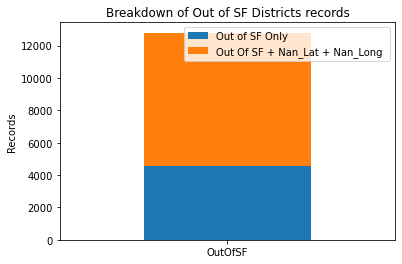

In [24]:
plotdata.plot(kind='bar', stacked=True)
plt.title("Breakdown of Out of SF Districts records")
#plt.xlabel("Out of SF")
plt.ylabel("Records")

plt.xticks(rotation=0, horizontalalignment="center")

In [25]:
#proceed to drop the rest of 'Out of SF' records 
sf_input.drop(sf_input.index[outOfSF_mask], inplace = True) #drop those records having these conditions

#expected no. = 448780 - 4530 = 444250
sf_input.reset_index(drop=True, inplace=True) #resets the index 
sf_input

Incident_Datetime Incident_Date Incident_Time  Incident_Year Incident_DayofWeek         Report_Datetime         RowID  IncidentID  Incident_No ReportType_Code     ReportType_Desc  Incident_Code    Incident_Category   Incident_Subcategory                          Incident_Desc            Resolution PD_District  Analysis_Neighborhood   Latitude   Longitude                                           shape  Neighborhoods
0      2021-04-28 23:47:00    2021/04/28         23:47           2021          Wednesday  2021/04/28 11:50:00 PM  102565226039     1025652    210261565              II             Initial          26039                Arson                  Arson               Fire, Unlawfully Causing        Open or Active  Tenderloin             Tenderloin  37.785167 -122.417901  POINT (-122.41790141130261 37.785167213738916)           20.0
1      2021-02-27 22:00:00    2021/02/27         22:00           2021           Saturday  2021/04/14 04:33:00 PM  102577906374     1025779    216046206              II    Coplogic Initial           6374        Larceny Theft  Larceny Theft - Other           Theft, Other Property, >$950        Open or Active        Park                    NaN        NaN         NaN                                             NaN            NaN
2      2021-04-12 20:51:00    2021/04/12         20:51           2021             Monday  2021/04/22 07:17:00 AM  102580006374     1025800    216045985              II    Coplogic Initial           6374        Larceny Theft  Larceny Theft - Other           Theft, Other Property, >$950        Open or Active     Mission                    NaN        NaN         NaN                                             NaN            NaN
3      2021-04-16 16:30:00    2021/04/16         16:30           2021             Friday  2021/04/20 09:03:00 PM  102584406372     1025844    216045991              II    Coplogic Initial           6372        Larceny Theft  Larceny Theft - Other        Theft, Other Property, $50-$200        Open or Active     Mission                Mission  37.766674 -122.419825   POINT (-122.41982523539403 37.76667360056878)           53.0
4      2021-04-29 11:45:00    2021/04/29         11:45           2021           Thursday  2021/04/29 12:20:00 PM  102588674000     1025886    210262381              II             Initial          74000       Missing Person          Missing Adult                          Missing Adult        Open or Active        Park      Lone Mountain/USF  37.774041 -122.452813   POINT (-122.4528128205759 37.774040691881595)           12.0
...                    ...           ...           ...            ...                ...                     ...           ...         ...          ...             ...                 ...            ...                  ...                    ...                                    ...                   ...         ...                    ...        ...         ...                                             ...            ...
444245 2021-04-27 19:00:00    2021/04/27         19:00           2021            Tuesday  2021/04/27 07:00:00 PM  102541375025     1025413    210258603              IS  Initial Supplement          75025         Non-Criminal           Non-Criminal                 Search Warrant Service  Cite or Arrest Adult    Northern              Japantown  37.786504 -122.429979  POINT (-122.42997893501317 37.786503857580136)          101.0
444246 2021-04-28 16:41:00    2021/04/28         16:41           2021          Wednesday  2021/04/28 04:44:00 PM  102556707055     1025567    210260846              VI     Vehicle Initial           7055  Motor Vehicle Theft    Motor Vehicle Theft  Vehicle, Recovered, Stolen outside SF        Open or Active     Bayview  Bayview Hunters Point  37.716087 -122.388978    POINT (-122.38897780416126 37.7160869851702)           88.0
444247 2021-04-27 22:00:00    2021/04/27         22:00           2021            Tuesday  2021/04/28 01:11:00 PM  102548706234     1025487    210260

After cleaning these up, we are now left with <b>444250</b> records

### 2.2 ) Cleaning up 'Nan Lat Long' records 
Let's take a look at the records now to see which columns have missing records 

In [26]:
sf_input.isnull().sum()

Incident_Datetime            0
Incident_Date                0
Incident_Time                0
Incident_Year                0
Incident_DayofWeek           0
Report_Datetime              0
RowID                        0
IncidentID                   0
Incident_No                  0
ReportType_Code              0
ReportType_Desc              0
Incident_Code                0
Incident_Category          380
Incident_Subcategory       380
Incident_Desc                0
Resolution                   0
PD_District                  0
Analysis_Neighborhood    15083
Latitude                 14990
Longitude                14990
shape                    14990
Neighborhoods            24352
dtype: int64

In [27]:
## Ah..so we might have a problem here. We hv 3% of records having a NaN_Lat, NaN_Long. However we will not be able to find a way to fill them in
## 1. Even if I manage to find the coordinates of the districts, by filling them in with the average coordinate of the district will artifically inflate the crime's location
## 2. We see that there is somthing weird for a crime to be logged without a geo coordinate

# we examine the spread of this issue from the districts pov first 

### So far there are <b>14990</b> records with missing lat, long 

In [28]:
latNaN_longNAN_mask = sf_input['Latitude'].isnull() & sf_input['Longitude'].isnull()
NaN_coord_byDistrict_groupBy = sf_input [latNaN_longNAN_mask].groupby('PD_District')
print (NaN_coord_byDistrict_groupBy.size())


PD_District
Bayview        771
Central       2855
Ingleside      537
Mission       1679
Northern      1558
Park          1172
Richmond      2327
Southern      2697
Taraval        878
Tenderloin     516
dtype: int64


In [29]:
print (type( NaN_coord_byDistrict_groupBy.size())) #let's plot the series 

<class 'pandas.core.series.Series'>


In [30]:
NaN_coord_byDistrict_series = NaN_coord_byDistrict_groupBy.size().reset_index()

In [31]:
NaN_coord_byDistrict_series
NaN_coord_byDistrict_series.rename(columns={0: "count"}, inplace=True) 

In [32]:
NaN_coord_byDistrict_series

PD_District  count
0     Bayview    771
1     Central   2855
2   Ingleside    537
3     Mission   1679
4    Northern   1558
5        Park   1172
6    Richmond   2327
7    Southern   2697
8     Taraval    878
9  Tenderloin    516

In [33]:
NaN_coord_byDistrict_df = pd.DataFrame(NaN_coord_byDistrict_series) 

In [34]:
NaN_coord_byDistrict_df.sort_values('count',ascending=False)

PD_District  count
1     Central   2855
7    Southern   2697
6    Richmond   2327
3     Mission   1679
4    Northern   1558
5        Park   1172
8     Taraval    878
0     Bayview    771
2   Ingleside    537
9  Tenderloin    516

### Breakdown of Empty (lat,long) by districts

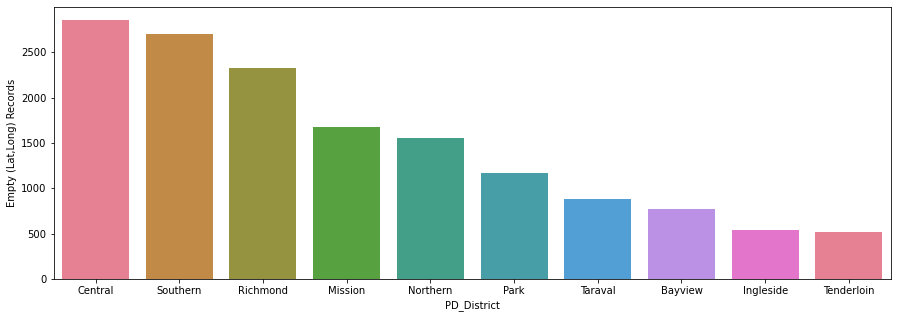

In [35]:
plt.figure(figsize=(15,5))
cp2 = sns.color_palette("husl", 9) 

sns.barplot(x = 'PD_District',
            y = 'count',
            #data = NaN_coord_byDistrict_df,
            data = NaN_coord_byDistrict_df.sort_values('count',ascending=False),
            palette=cp2
           )
plt.ylabel("Empty (Lat,Long) Records")
# Show the plot
plt.show()

In [36]:
## We can see that Central is more affected by then tendorloin
#List of districts 
sf_input [ 'PD_District' ].unique() 

array(['Tenderloin', 'Park', 'Mission', 'Southern', 'Taraval', 'Richmond',
       'Northern', 'Ingleside', 'Central', 'Bayview'], dtype=object)

In [37]:
sf_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444250 entries, 0 to 444249
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Incident_Datetime      444250 non-null  datetime64[ns]
 1   Incident_Date          444250 non-null  object        
 2   Incident_Time          444250 non-null  object        
 3   Incident_Year          444250 non-null  int64         
 4   Incident_DayofWeek     444250 non-null  object        
 5   Report_Datetime        444250 non-null  object        
 6   RowID                  444250 non-null  int64         
 7   IncidentID             444250 non-null  int64         
 8   Incident_No            444250 non-null  int64         
 9   ReportType_Code        444250 non-null  object        
 10  ReportType_Desc        444250 non-null  object        
 11  Incident_Code          444250 non-null  int64         
 12  Incident_Category      443870 non-null  obje

In [38]:
##Let's observe this by Incident_Year 

In [39]:
latNaN_longNAN_mask = sf_input['Latitude'].isnull() & sf_input['Longitude'].isnull()
NaN_coord_groupByYear = sf_input [latNaN_longNAN_mask].groupby('Incident_Year')
allCrimes_byYear = sf_input.groupby('Incident_Year')
print (NaN_coord_groupByYear.size())
print ('----------------------------')
print (allCrimes_byYear.size())

allCrimes_byYear_df = pd.DataFrame(allCrimes_byYear.size()) 
Nan_by_YearDf = pd.DataFrame(NaN_coord_groupByYear.size()) 

#allCrimes_byYear_df = pd.DataFrame(allCrimes_byYear.size()) 

#allCrimes_byYear_series = allCrimes_byYear.size()  ##ORIG 
#NaN_coord_groupByYear_series = NaN_coord_groupByYear.size()  ##ORIG  


Incident_Year
2018    5431
2019    5731
2020    3009
2021     819
dtype: int64
----------------------------
Incident_Year
2018    148446
2019    143879
2020    113610
2021     38315
dtype: int64


In [40]:
#allCrimes_Empty_df = pd.concat([allCrimes_byYear_series, NaN_coord_groupByYear_series], axis=1)

allCrimes_Empty_df = allCrimes_byYear_df

#allCrimes_Empty_df = pd.concat([allCrimes_byYear_df, Nan_by_YearDf], axis=1)

In [41]:
Nan_by_YearDf

0
Incident_Year      
2018           5431
2019           5731
2020           3009
2021            819

In [42]:
Nan_by_YearDf[0]

Incident_Year
2018    5431
2019    5731
2020    3009
2021     819
Name: 0, dtype: int64

In [43]:
allCrimes_Empty_df.rename(columns={0: "AllCrimesCount"}, inplace=True) #, 1:"NaNCrimeCountsByYear"
#allCrimes_Empty_df.rename(columns={0: "AllCrimesCount", 1:"NaNCrimeCountsByYear"}, inplace=True)

In [44]:
allCrimes_Empty_df [ 'NaNCrimeCountsByYear' ]  =Nan_by_YearDf[0]

In [45]:
allCrimes_Empty_df

AllCrimesCount  NaNCrimeCountsByYear
Incident_Year                                      
2018                   148446                  5431
2019                   143879                  5731
2020                   113610                  3009
2021                    38315                   819

In [46]:
allCrimes_Empty_df ['AllCrimesCount_noNAN'] = allCrimes_Empty_df ['AllCrimesCount'] - allCrimes_Empty_df ['NaNCrimeCountsByYear']

In [47]:
allCrimes_Empty_df

AllCrimesCount  NaNCrimeCountsByYear  AllCrimesCount_noNAN
Incident_Year                                                            
2018                   148446                  5431                143015
2019                   143879                  5731                138148
2020                   113610                  3009                110601
2021                    38315                   819                 37496

In [48]:
allCrimes_Empty_df.drop( 'AllCrimesCount', axis=1 ,inplace=True)


In [49]:
#re-order the columns 
allCrimes_Empty_df = allCrimes_Empty_df[['AllCrimesCount_noNAN', 'NaNCrimeCountsByYear' ]]
allCrimes_Empty_df

AllCrimesCount_noNAN  NaNCrimeCountsByYear
Incident_Year                                            
2018                         143015                  5431
2019                         138148                  5731
2020                         110601                  3009
2021                          37496                   819

### Breakdown of Empty (lat,long) records by Year 

(array([0, 1, 2, 3]),
 [Text(0, 0, '2018'),
  Text(1, 0, '2019'),
  Text(2, 0, '2020'),
  Text(3, 0, '2021')])

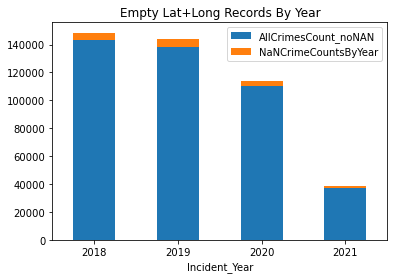

In [50]:
allCrimes_Empty_df.plot(kind='bar', stacked=True)

# Just add a title and rotate the x-axis labels to be horizontal.
plt.title('Empty Lat+Long Records By Year')
plt.xticks(rotation=0, ha='center')

In [51]:
##So there's approx 3% of records per year that have missing (Lat,long) - we proceed to drop those records 
## We are expectng 14990 records to be dropped = 429260 records left 


In [52]:
latNaN_longNAN_mask = sf_input['Latitude'].isnull() & sf_input['Longitude'].isnull()

In [53]:
sf_input.drop(sf_input.index[latNaN_longNAN_mask], inplace = True) #drop those records having these conditions
sf_input.reset_index(drop=True, inplace=True) #resets the index 
sf_input

Incident_Datetime Incident_Date Incident_Time  Incident_Year Incident_DayofWeek         Report_Datetime         RowID  IncidentID  Incident_No ReportType_Code     ReportType_Desc  Incident_Code    Incident_Category   Incident_Subcategory                          Incident_Desc            Resolution PD_District  Analysis_Neighborhood   Latitude   Longitude                                           shape  Neighborhoods
0      2021-04-28 23:47:00    2021/04/28         23:47           2021          Wednesday  2021/04/28 11:50:00 PM  102565226039     1025652    210261565              II             Initial          26039                Arson                  Arson               Fire, Unlawfully Causing        Open or Active  Tenderloin             Tenderloin  37.785167 -122.417901  POINT (-122.41790141130261 37.785167213738916)           20.0
1      2021-04-16 16:30:00    2021/04/16         16:30           2021             Friday  2021/04/20 09:03:00 PM  102584406372     1025844    216045991              II    Coplogic Initial           6372        Larceny Theft  Larceny Theft - Other        Theft, Other Property, $50-$200        Open or Active     Mission                Mission  37.766674 -122.419825   POINT (-122.41982523539403 37.76667360056878)           53.0
2      2021-04-29 11:45:00    2021/04/29         11:45           2021           Thursday  2021/04/29 12:20:00 PM  102588674000     1025886    210262381              II             Initial          74000       Missing Person          Missing Adult                          Missing Adult        Open or Active        Park      Lone Mountain/USF  37.774041 -122.452813   POINT (-122.4528128205759 37.774040691881595)           12.0
3      2021-04-29 11:16:00    2021/04/29         11:16           2021           Thursday  2021/04/29 11:18:00 AM  102588875000     1025888    210259764              IS  Initial Supplement          75000       Missing Person         Missing Person                           Found Person        Open or Active    Southern        South of Market  37.779739 -122.407159   POINT (-122.40715948914875 37.77973890462704)           32.0
4      2021-04-29 17:50:00    2021/04/29         17:50           2021           Thursday  2021/04/29 05:56:00 PM  102598416654     1025984    210263179              II             Initial          16654         Drug Offense         Drug Violation                  Methamphetamine, Sale  Cite or Arrest Adult  Tenderloin        South of Market  37.780006 -122.411933  POINT (-122.41193341005338 37.780005867994824)           32.0
...                    ...           ...           ...            ...                ...                     ...           ...         ...          ...             ...                 ...            ...                  ...                    ...                                    ...                   ...         ...                    ...        ...         ...                                             ...            ...
429255 2021-04-27 19:00:00    2021/04/27         19:00           2021            Tuesday  2021/04/27 07:00:00 PM  102541375025     1025413    210258603              IS  Initial Supplement          75025         Non-Criminal           Non-Criminal                 Search Warrant Service  Cite or Arrest Adult    Northern              Japantown  37.786504 -122.429979  POINT (-122.42997893501317 37.786503857580136)          101.0
429256 2021-04-28 16:41:00    2021/04/28         16:41           2021          Wednesday  2021/04/28 04:44:00 PM  102556707055     1025567    210260846              VI     Vehicle Initial           7055  Motor Vehicle Theft    Motor Vehicle Theft  Vehicle, Recovered, Stolen outside SF        Open or Active     Bayview  Bayview Hunters Point  37.716087 -122.388978    POINT (-122.38897780416126 37.7160869851702)           88.0
429257 2021-04-27 22:00:00    2021/04/27         22:00           2021            Tuesday  2021/04/28 01:11:00 PM  102548706234     1025487    210260

In [54]:
##Conclude cleaning up the lat,long section 

### 2.3 We shall take a look at Analysis_Neigbhourhood missing values


In [55]:
sf_input.isnull().sum()

Incident_Datetime           0
Incident_Date               0
Incident_Time               0
Incident_Year               0
Incident_DayofWeek          0
Report_Datetime             0
RowID                       0
IncidentID                  0
Incident_No                 0
ReportType_Code             0
ReportType_Desc             0
Incident_Code               0
Incident_Category         380
Incident_Subcategory      380
Incident_Desc               0
Resolution                  0
PD_District                 0
Analysis_Neighborhood      93
Latitude                    0
Longitude                   0
shape                       0
Neighborhoods            9362
dtype: int64

In [56]:

#check this out 
sf_input [ sf_input.Analysis_Neighborhood.isnull() ] ['PD_District'].unique()

array(['Ingleside'], dtype=object)

In [57]:
sf_input [ sf_input.Analysis_Neighborhood.isnull() ].groupby (['PD_District', 'Incident_Year']).size()

PD_District  Incident_Year
Ingleside    2018             35
             2019             23
             2020             33
             2021              2
dtype: int64

In [58]:
#Let's see the uique values for analysis neighourbood

In [59]:
sf_input [ 'Analysis_Neighborhood' ].unique()

array(['Tenderloin', 'Mission', 'Lone Mountain/USF', 'South of Market',
       'Lakeshore', 'Outer Richmond', 'Presidio', 'Sunset/Parkside',
       'Mission Bay', 'Noe Valley', 'Castro/Upper Market', 'Hayes Valley',
       'Outer Mission', 'Presidio Heights', 'Western Addition',
       'Oceanview/Merced/Ingleside', 'Bayview Hunters Point', 'Marina',
       'Inner Richmond', 'North Beach', 'Bernal Heights', 'Excelsior',
       'Visitacion Valley', 'Portola', 'Chinatown', 'Potrero Hill',
       'Pacific Heights', 'Golden Gate Park', 'Nob Hill', 'Russian Hill',
       'Financial District/South Beach', 'Japantown', 'Inner Sunset',
       'West of Twin Peaks', 'Treasure Island', 'Lincoln Park',
       'Haight Ashbury', 'Twin Peaks', 'Glen Park', 'McLaren Park',
       'Seacliff', nan], dtype=object)

### So it seems all the missing analysis_neighbourhoods belongs to 'Ingleside' only, we temp fillna for these records as 'Ingleside'

In [60]:
#sf_input [ sf_input.Analysis_Neighborhood.isnull() ] [['Analysis_Neighborhood']] = 'Ingleside' 

#sf_input [ sf_input.Analysis_Neighborhood.isnull() ] [['Analysis_Neighborhood']].fillna(value='Ingleside', inplace=True)
#sf_input [['Analysis_Neighborhood']] = sf_input [['Analysis_Neighborhood']].fillna(value='Ingleside')


sf_input ['Analysis_Neighborhood'].fillna( 'Ingleside' , inplace=True )


In [61]:
#this should have no records left 
sf_input [ sf_input.Analysis_Neighborhood.isnull() ] [['Analysis_Neighborhood']]

Empty DataFrame
Columns: [Analysis_Neighborhood]
Index: []

In [62]:
#this should have no records left 
sf_input [ sf_input.Analysis_Neighborhood.isnull() ].groupby (['PD_District', 'Incident_Year']).size()

Series([], dtype: int64)

In [63]:
#Analysis_Neighbourhood should be 0 
#sf_input.isnull().sum()

### 2.4 Let's take a look again at Incident Category & Incident_Subcategory

In [64]:
sf_input.isnull().sum()

Incident_Datetime           0
Incident_Date               0
Incident_Time               0
Incident_Year               0
Incident_DayofWeek          0
Report_Datetime             0
RowID                       0
IncidentID                  0
Incident_No                 0
ReportType_Code             0
ReportType_Desc             0
Incident_Code               0
Incident_Category         380
Incident_Subcategory      380
Incident_Desc               0
Resolution                  0
PD_District                 0
Analysis_Neighborhood       0
Latitude                    0
Longitude                   0
shape                       0
Neighborhoods            9362
dtype: int64

In [65]:
##There are some recods with Incident_Category & subcategory as null , however the 'Incident_Desc' is not null
##Let's take a closer look at these 

In [66]:
sf_input [ sf_input.Incident_Category.isnull() ].groupby('Incident_Desc').size()

Incident_Desc
Assault, By Police Officers                                                               1
Assault, Commission of While Armed                                                        1
Auto Impounded                                                                            9
Cloned Cellular Phone, Use                                                                1
Crimes Involving Receipts or Titles                                                       1
Driving, Stunt Vehicle/Street Racing                                                    116
Gun Violence Restraining Order                                                            8
Gun Violence Restraining Order Violation                                                  1
Military Ordinance                                                                       10
Procurement, Pimping, & Pandering                                                         2
Public Health Order Violation, After Notification                 

In [67]:
temp_display = sf_input [ sf_input.Incident_Category.isnull() ].groupby('Incident_Desc').size().to_frame('size')
temp_display
#more friendly display that's all 

size
Incident_Desc                                           
Assault, By Police Officers                            1
Assault, Commission of While Armed                     1
Auto Impounded                                         9
Cloned Cellular Phone, Use                             1
Crimes Involving Receipts or Titles                    1
Driving, Stunt Vehicle/Street Racing                 116
Gun Violence Restraining Order                         8
Gun Violence Restraining Order Violation               1
Military Ordinance                                    10
Procurement, Pimping, & Pandering                      2
Public Health Order Violation, After Notification     46
Public Health Order Violation, Notification          159
SFMTA Muni Transit Operator-Bus/LRV                    2
SFMTA Parking and Control Officer                      1
Service of Documents Related to a Civil Drug Ab...    11
Theft, Animal, Att.                                    1
Theft, Boat                                           10

In [68]:
temp_display.index

Index(['Assault, By Police Officers', 'Assault, Commission of While Armed', 'Auto Impounded', 'Cloned Cellular Phone, Use', 'Crimes Involving Receipts or Titles', 'Driving, Stunt Vehicle/Street Racing', 'Gun Violence Restraining Order', 'Gun Violence Restraining Order Violation', 'Military Ordinance', 'Procurement, Pimping, & Pandering', 'Public Health Order Violation, After Notification', 'Public Health Order Violation, Notification', 'SFMTA Muni Transit Operator-Bus/LRV', 'SFMTA Parking and Control Officer', 'Service of Documents Related to a Civil Drug Abatement and/or Public Nuisance Action', 'Theft, Animal, Att.', 'Theft, Boat'], dtype='object', name='Incident_Desc')

In [69]:
##Are the subcategory for these records also missing ? 
temp_display03 = sf_input [ sf_input.Incident_Category.isnull() &  sf_input.Incident_Subcategory.isnull() ].groupby('Incident_Desc').size().to_frame('size')
temp_display03

size
Incident_Desc                                           
Assault, By Police Officers                            1
Assault, Commission of While Armed                     1
Auto Impounded                                         9
Cloned Cellular Phone, Use                             1
Crimes Involving Receipts or Titles                    1
Driving, Stunt Vehicle/Street Racing                 116
Gun Violence Restraining Order                         8
Gun Violence Restraining Order Violation               1
Military Ordinance                                    10
Procurement, Pimping, & Pandering                      2
Public Health Order Violation, After Notification     46
Public Health Order Violation, Notification          159
SFMTA Muni Transit Operator-Bus/LRV                    2
SFMTA Parking and Control Officer                      1
Service of Documents Related to a Civil Drug Ab...    11
Theft, Animal, Att.                                    1
Theft, Boat                                           10

### So it appears that both Incident_Category (null) and Incident_Subcategory (null) belongs to a whole set of records 

In [70]:
len (sf_input.groupby('Incident_Category').size()) #So there are 48 distinct categories of Incident_Category

48

In [71]:
sf_input.groupby('Incident_Category').size()

Incident_Category
Arson                                           1280
Assault                                        27160
Burglary                                       25245
Case Closure                                    1695
Civil Sidewalks                                  863
Courtesy Report                                  378
Disorderly Conduct                              7722
Drug Offense                                   11137
Drug Violation                                   145
Embezzlement                                     617
Fire Report                                      565
Forgery And Counterfeiting                      1774
Fraud                                          13063
Gambling                                          22
Homicide                                          52
Human Trafficking (A), Commercial Sex Acts       107
Human Trafficking, Commercial Sex Acts            18
Larceny Theft                                 124915
Liquor Laws                 

In [72]:
#peek at the sub

sf_input.groupby('Incident_Subcategory').size()

Incident_Subcategory
Aggravated Assault                        10110
Arrest                                        4
Arson                                      1280
Bad Checks                                   35
Bribery                                       5
Burglary - Commercial                      3254
Burglary - Hot Prowl                       3148
Burglary - Other                          10223
Burglary - Residential                     8620
Case Closure                               1695
Courtesy Report                             378
Disorderly Conduct                         1339
Drug Violation                            11328
Drunkenness                                 701
Embezzlement                                617
Extortion-Blackmail                         185
Fire Report                                 565
Forgery And Counterfeiting                 1774
Fraud                                     13867
Gambling                                     22
Homicide           

### We see if we find a similiar incident_category for such incident_description before.
### If there are ,we can choose to replace it 

In [73]:
#create helper func to see if there are existing records with such desc having a non-null incident_category 
def printIncidentCategoryByDesc ( incident_description ):
    print ('-------------------------------------------------------')
    print ('Incident_Category for Desc = [%s]' %incident_description)
    print ( sf_input [ sf_input ['Incident_Desc'] == incident_description  ].groupby('Incident_Category').size() )
    print ('-------------------------------------------------------')

In [74]:
list_all_IncideintCategoryMissing = temp_display.index.values.tolist()
for i in list_all_IncideintCategoryMissing:
    printIncidentCategoryByDesc ( i )  

-------------------------------------------------------
Incident_Category for Desc = [Assault, By Police Officers]
Series([], dtype: int64)
-------------------------------------------------------
-------------------------------------------------------
Incident_Category for Desc = [Assault, Commission of While Armed]
Series([], dtype: int64)
-------------------------------------------------------
-------------------------------------------------------
Incident_Category for Desc = [Auto Impounded]
Series([], dtype: int64)
-------------------------------------------------------
-------------------------------------------------------
Incident_Category for Desc = [Cloned Cellular Phone, Use]
Series([], dtype: int64)
-------------------------------------------------------
-------------------------------------------------------
Incident_Category for Desc = [Crimes Involving Receipts or Titles]
Series([], dtype: int64)
-------------------------------------------------------
-------------------

### So there appears to be no good match. Here's a proposed mapping from a best-effort approach after examing the description

In [75]:
##Here is a proposed mapping of mapping these records to existing Incident Category 

|	Missing Incident_Category but having Incident_Desc!=null	|	Map to Incident_Category	|	Map to Incident_Subcategory	|
|:---------------------------------------------------------------------------------------------:|:-----------------------------:|:-----------------------------:|
|	Assault, By Police Officers                                                         	|	Assault                                        	|	Assault                                        	|
|	Assault, Commission of While Armed                                                  	|	Assault                                        	|	Assault                                        	|
|	Auto Impounded                                                                      	|	Vehicle Impounded                              	|	Vehicle Impounded                       	|
|	Cloned Cellular Phone, Use                                                          	|	Other Offenses                                 	|	Other Offenses                          	|
|	Crimes Involving Receipts or Titles                                                 	|	Fraud                                          	|	Fraud                                          	|
|	Driving, Stunt Vehicle/Street Racing                                                	|	Traffic Violation Arrest                       	|	Traffic Violation Arrest                       	|
|	Gun Violence Restraining Order                                                      	|	Other Offenses                                 	|	Other Offenses                          	|
|	Gun Violence Restraining Order Violation                                            	|	Other Offenses                                 	|	Other Offenses                          	|
|	Military Ordinance                                                                  	|	Other Offenses                                 	|	Other Offenses                          	|
|	Procurement, Pimping, & Pandering                                                   	|	Human Trafficking, Commercial Sex Acts         	|	Human Trafficking, Commercial Sex Acts  	|
|	Public Health Order Violation, After Notification                                   	|	Other Offenses                                 	|	Other Offenses                          	|
|	Public Health Order Violation, Notification                                         	|	Other Offenses                                 	|	Other Offenses                          	|
|	SFMTA Muni Transit Operator-Bus/LRV                                                 	|	Other Offenses                                 	|	Other Offenses                          	|
|	SFMTA Parking and Control Officer                                                   	|	Other Offenses                                 	|	Other Offenses                          	|
|	Service of Documents Related to a Civil Drug Abatement and/or Public Nuisance Action	|	Other Offenses                                 	|	Other Offenses                          	|
|	Theft, Animal, Att.                                                                 	|	Larceny Theft 	|	Larceny Theft - Other                   |
|	Theft, Boat   	|	Larceny Theft 	|	Larceny Theft - Other                   	|


In [76]:
#sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category']]

In [77]:

##THIS IS WORKING 
##convert to different mapping statements 
##sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category']] = 'XXX'

In [78]:
#specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Assault, By Police Officers', 'Assault',  'Assault'
#sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  


In [79]:
###3rd VERSION UPDATES BOTH category and subcategory

specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Assault, By Police Officers', 'Assault', 'Assault'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  


specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Assault, Commission of While Armed', 'Assault', 'Assault'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  

specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Auto Impounded', 'Vehicle Impounded', 'Vehicle Impounded'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  

specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Cloned Cellular Phone, Use', 'Other Offenses', 'Other Offenses'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  

specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Crimes Involving Receipts or Titles', 'Fraud', 'Fraud'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  

specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Driving, Stunt Vehicle/Street Racing', 'Traffic Violation Arrest', 'Traffic Violation Arrest'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  


specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Gun Violence Restraining Order', 'Other Offenses', 'Other Offenses'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  


specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Gun Violence Restraining Order Violation', 'Other Offenses', 'Other Offenses'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  


specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Military Ordinance', 'Other Offenses', 'Other Offenses'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  


specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Procurement, Pimping, & Pandering', 'Human Trafficking, Commercial Sex Acts', 'Human Trafficking, Commercial Sex Acts'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  


specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Public Health Order Violation, After Notification', 'Other Offenses', 'Other Offenses'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  


specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Public Health Order Violation, Notification', 'Other Offenses', 'Other Offenses'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  


specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='SFMTA Muni Transit Operator-Bus/LRV', 'Other Offenses', 'Other Offenses'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  


specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='SFMTA Parking and Control Officer', 'Other Offenses', 'Other Offenses'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  

specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Service of Documents Related to a Civil Drug Abatement and/or Public Nuisance Action', 'Other Offenses', 'Other Offenses'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  


specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Theft, Animal, Att.', 'Larceny Theft', 'Larceny Theft - Other'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  


specific_IncidentDesc, replace_To_IncidentCategory, replace_To_SubCat ='Theft, Boat', 'Larceny Theft', 'Larceny Theft - Other'
sf_input.loc[( sf_input.Incident_Category.isnull()  ) & (sf_input ['Incident_Desc'] == specific_IncidentDesc  ), ['Incident_Category', 'Incident_Subcategory' ]] = [ replace_To_IncidentCategory, replace_To_SubCat]  





###3rd VERSION UPDATES BOTH 

In [80]:
temp_display02 = sf_input [ sf_input.Incident_Category.isnull() ].groupby('Incident_Desc').size().to_frame('size')
temp_display02

Empty DataFrame
Columns: [size]
Index: []

### MORE CLEANING?? --END 2 - Let's take a look again at Incident Category & Incident_Subcategory

### 2.5 So what do we do with 'Neighborhoods' column ? 
Plus Incident_No, Incidient No, Incidient_code,ReportType_Code,ReportType_Desc,RowID                                              

In [81]:
sf_input.isnull().sum()

Incident_Datetime           0
Incident_Date               0
Incident_Time               0
Incident_Year               0
Incident_DayofWeek          0
Report_Datetime             0
RowID                       0
IncidentID                  0
Incident_No                 0
ReportType_Code             0
ReportType_Desc             0
Incident_Code               0
Incident_Category           0
Incident_Subcategory        0
Incident_Desc               0
Resolution                  0
PD_District                 0
Analysis_Neighborhood       0
Latitude                    0
Longitude                   0
shape                       0
Neighborhoods            9362
dtype: int64

In [82]:
#sf_input .head (50)

sf_input [ sf_input.Neighborhoods.isnull() ] 
#mask_matchIncidentCategory = ( sf_input ['Incident_Category'] == 'Motor Vehicle Theft?' )
#sf_input [ mask_matchIncidentCategory ]


Incident_Datetime Incident_Date Incident_Time  Incident_Year Incident_DayofWeek         Report_Datetime         RowID  IncidentID  Incident_No ReportType_Code     ReportType_Desc  Incident_Code            Incident_Category         Incident_Subcategory                              Incident_Desc            Resolution PD_District Analysis_Neighborhood   Latitude   Longitude                                           shape  Neighborhoods
88     2021-04-29 17:17:00    2021/04/29         17:17           2021           Thursday  2021/04/29 05:21:00 PM  102596428100     1025964    210263107              II             Initial          28100           Malicious Mischief                    Vandalism       Malicious Mischief, Breaking Windows        Open or Active  Tenderloin            Tenderloin  37.784349 -122.409309     POINT (-122.4093091807476 37.7843492684367)            NaN
162    2021-04-29 17:17:00    2021/04/29         17:17           2021           Thursday  2021/04/29 05:21:00 PM  102596404134     1025964    210263107              II             Initial           4134                      Assault               Simple Assault                                    Battery        Open or Active  Tenderloin            Tenderloin  37.784349 -122.409309     POINT (-122.4093091807476 37.7843492684367)            NaN
213    2021-04-28 09:00:00    2021/04/28         09:00           2021          Wednesday  2021/04/29 10:57:00 AM  102589964070     1025899    210230338              IS  Initial Supplement          64070               Suspicious Occ               Suspicious Occ                      Suspicious Occurrence        Open or Active    Richmond        Outer Richmond  37.783543 -122.492510   POINT (-122.49251018789161 37.78354278109803)            NaN
218    2021-04-29 17:04:00    2021/04/29         17:04           2021           Thursday  2021/04/29 05:04:00 PM  102594168020     1025941    200636031              IS  Initial Supplement          68020  Miscellaneous Investigation  Miscellaneous Investigation                Miscellaneous Investigation        Open or Active    Northern       Pacific Heights  37.795108 -122.443573   POINT (-122.4435734210403 37.795107944990875)            NaN
422    2021-04-29 18:00:00    2021/04/29         18:00           2021           Thursday  2021/04/30 11:07:00 AM  102620174000     1026201    210264547              II             Initial          74000               Missing Person                Missing Adult                              Missing Adult        Open or Active    Northern          Hayes Valley  37.777700 -122.431575    POINT (-122.4315746434308 37.77769992435941)            NaN
...                    ...           ...           ...            ...                ...                     ...           ...         ...          ...             ...                 ...            ...                          ...                          ...                                        ...                   ...         ...                   ...        ...         ...                                             ...            ...
429034 2021-04-27 08:28:00    2021/04/27         08:28           2021            Tuesday  2021/04/28 08:28:00 AM  102544665015     1025446    210259350              II             Initial          65015          Other Miscellaneous                        Other                 Driving, No License Issued  Cite or Arrest Adult  Tenderloin            Tenderloin  37.784349 -122.409309     POINT (-122.4093091807476 37.7843492684367)            NaN
429053 2021-04-27 12:00:00    2021/04/27         12:00           2021            Tuesday  2021/04/28 02:15:00 PM  102553107021     1025531    210260454              VI     Vehicle Initial           7021          Motor Vehicle Theft          Motor Vehicle Theft                      Vehicle, Stolen, Auto        Open or Active  Tenderloin            Tenderloin  37.786659 -122.409775   POINT (-122.40977511008917 37.78665887330192)           

In [83]:
sf_input [ sf_input.Neighborhoods.notnull() ] 

Incident_Datetime Incident_Date Incident_Time  Incident_Year Incident_DayofWeek         Report_Datetime         RowID  IncidentID  Incident_No ReportType_Code     ReportType_Desc  Incident_Code    Incident_Category   Incident_Subcategory                          Incident_Desc            Resolution PD_District  Analysis_Neighborhood   Latitude   Longitude                                           shape  Neighborhoods
0      2021-04-28 23:47:00    2021/04/28         23:47           2021          Wednesday  2021/04/28 11:50:00 PM  102565226039     1025652    210261565              II             Initial          26039                Arson                  Arson               Fire, Unlawfully Causing        Open or Active  Tenderloin             Tenderloin  37.785167 -122.417901  POINT (-122.41790141130261 37.785167213738916)           20.0
1      2021-04-16 16:30:00    2021/04/16         16:30           2021             Friday  2021/04/20 09:03:00 PM  102584406372     1025844    216045991              II    Coplogic Initial           6372        Larceny Theft  Larceny Theft - Other        Theft, Other Property, $50-$200        Open or Active     Mission                Mission  37.766674 -122.419825   POINT (-122.41982523539403 37.76667360056878)           53.0
2      2021-04-29 11:45:00    2021/04/29         11:45           2021           Thursday  2021/04/29 12:20:00 PM  102588674000     1025886    210262381              II             Initial          74000       Missing Person          Missing Adult                          Missing Adult        Open or Active        Park      Lone Mountain/USF  37.774041 -122.452813   POINT (-122.4528128205759 37.774040691881595)           12.0
3      2021-04-29 11:16:00    2021/04/29         11:16           2021           Thursday  2021/04/29 11:18:00 AM  102588875000     1025888    210259764              IS  Initial Supplement          75000       Missing Person         Missing Person                           Found Person        Open or Active    Southern        South of Market  37.779739 -122.407159   POINT (-122.40715948914875 37.77973890462704)           32.0
4      2021-04-29 17:50:00    2021/04/29         17:50           2021           Thursday  2021/04/29 05:56:00 PM  102598416654     1025984    210263179              II             Initial          16654         Drug Offense         Drug Violation                  Methamphetamine, Sale  Cite or Arrest Adult  Tenderloin        South of Market  37.780006 -122.411933  POINT (-122.41193341005338 37.780005867994824)           32.0
...                    ...           ...           ...            ...                ...                     ...           ...         ...          ...             ...                 ...            ...                  ...                    ...                                    ...                   ...         ...                    ...        ...         ...                                             ...            ...
429255 2021-04-27 19:00:00    2021/04/27         19:00           2021            Tuesday  2021/04/27 07:00:00 PM  102541375025     1025413    210258603              IS  Initial Supplement          75025         Non-Criminal           Non-Criminal                 Search Warrant Service  Cite or Arrest Adult    Northern              Japantown  37.786504 -122.429979  POINT (-122.42997893501317 37.786503857580136)          101.0
429256 2021-04-28 16:41:00    2021/04/28         16:41           2021          Wednesday  2021/04/28 04:44:00 PM  102556707055     1025567    210260846              VI     Vehicle Initial           7055  Motor Vehicle Theft    Motor Vehicle Theft  Vehicle, Recovered, Stolen outside SF        Open or Active     Bayview  Bayview Hunters Point  37.716087 -122.388978    POINT (-122.38897780416126 37.7160869851702)           88.0
429257 2021-04-27 22:00:00    2021/04/27         22:00           2021            Tuesday  2021/04/28 01:11:00 PM  102548706234     1025487    210260

As examined, there is <b>no clear documentation</b> on the web on what 'Neighborhoods' mean - we do not know if this means 
the neighorhood # or the location is near to X no. of neighbourhood 

The decision is to <b>drop</b> this column altogether 

In addition, these <b>columns</b> are not needed for analysis and will be dropped as well

- Incident_No
- Incident_Code, 
- ReportType_Code
- ReportType_Desc
- RowID 
- Report_Datetime
- IncidentID
- Resolution

In [84]:
#returnToThis - INCIDENTCODE
columns_to_drop = ['Neighborhoods','Incident_No','Incident_Code', 'ReportType_Code', 
                   'ReportType_Desc', 'RowID', 'Report_Datetime', 'IncidentID', 'Resolution']

sf_input.drop(columns=columns_to_drop, inplace=True )

In [85]:
sf_input.columns                                 

Index(['Incident_Datetime', 'Incident_Date', 'Incident_Time', 'Incident_Year', 'Incident_DayofWeek', 'Incident_Category', 'Incident_Subcategory', 'Incident_Desc', 'PD_District', 'Analysis_Neighborhood', 'Latitude', 'Longitude', 'shape'], dtype='object')

### 2.6 It's time to deal with Category Correction and Binning 

In [86]:
#sf_input.groupby('Incident_Category').size()
#friendly output
sf_input.groupby('Incident_Category').size().to_frame('size')


size
Incident_Category                                 
Arson                                         1280
Assault                                      27162
Burglary                                     25245
Case Closure                                  1695
Civil Sidewalks                                863
Courtesy Report                                378
Disorderly Conduct                            7722
Drug Offense                                 11137
Drug Violation                                 145
Embezzlement                                   617
Fire Report                                    565
Forgery And Counterfeiting                    1774
Fraud                                        13064
Gambling                                        22
Homicide                                        52
Human Trafficking (A), Commercial Sex Acts     107
Human Trafficking, Commercial Sex Acts          20
Larceny Theft                               124926
Liquor Laws                                     38
Lost Property                                11153
Malicious Mischief                           28399
Miscellaneous Investigation                   4225
Missing Person                                9996
Motor Vehicle Theft                          20501
Motor Vehicle Theft?                            54
Non-Criminal                                 27501
Offences Against The Family And Children      6309
Other                                         3638
Other Miscellaneous                          33470
Other Offenses                                3654
Prostitution                                   858
Rape                                           104
Recovered Vehicle                            11910
Robbery                                      10640
Sex Offense                                    517
Stolen Property                               2356
Suicide                                        200
Suspicious                                      80
Suspicious Occ                                8886
Traffic Collision                              947
Traffic Violation Arrest                      5537
Vandalism                                      824
Vehicle Impounded                              320
Vehicle Misplaced                              185
Warrant                                      14921
Weapons Carrying Etc                          2441
Weapons Offence                                 18
Weapons Offense                               2804

### Few observations 1. Weapons Offence should be spelled as 'Weapons Offense'
### spelling mistakes (?) such as 'Motor Vehicle Theft?'


In [87]:
mask_matchIncidentCategory = ( sf_input ['Incident_Category'] == 'Motor Vehicle Theft?' )
sf_input [ mask_matchIncidentCategory ]

Incident_Datetime Incident_Date Incident_Time  Incident_Year Incident_DayofWeek     Incident_Category Incident_Subcategory         Incident_Desc PD_District           Analysis_Neighborhood   Latitude   Longitude                                           shape
43763  2018-02-07 15:14:00    2018/02/07         15:14           2018          Wednesday  Motor Vehicle Theft?  Motor Vehicle Theft  Auto, Grand Theft of   Ingleside                       Excelsior  37.724316 -122.434033   POINT (-122.43403348247257 37.72431637120677)
44639  2018-02-08 08:03:00    2018/02/08         08:03           2018           Thursday  Motor Vehicle Theft?  Motor Vehicle Theft  Auto, Grand Theft of   Ingleside                       Excelsior  37.724343 -122.429652   POINT (-122.4296521266366 37.724343336092694)
49829  2018-02-09 13:18:00    2018/02/09         13:18           2018             Friday  Motor Vehicle Theft?  Motor Vehicle Theft  Auto, Grand Theft of   Ingleside                       Excelsior  37.724343 -122.429652   POINT (-122.4296521266366 37.724343336092694)
58836  2018-04-10 16:46:00    2018/04/10         16:46           2018            Tuesday  Motor Vehicle Theft?  Motor Vehicle Theft  Auto, Grand Theft of     Bayview           Bayview Hunters Point  37.730411 -122.391290  POINT (-122.39128975818817 37.730411351369746)
59705  2018-03-14 11:17:00    2018/03/14         11:17           2018          Wednesday  Motor Vehicle Theft?  Motor Vehicle Theft  Auto, Grand Theft of    Southern                 South of Market  37.776708 -122.414107  POINT (-122.41410689674207 37.776707686920346)
60303  2018-03-17 09:30:00    2018/03/17         09:30           2018           Saturday  Motor Vehicle Theft?  Motor Vehicle Theft  Auto, Grand Theft of    Northern                      Tenderloin  37.786359 -122.419833     POINT (-122.41983309179925 37.786358950426)
71210  2018-05-07 16:00:00    2018/05/07         16:00           2018             Monday  Motor Vehicle Theft?  Motor Vehicle Theft  Auto, Grand Theft of     Mission             Castro/Upper Market  37.762618 -122.432949  POINT (-122.43294913831029 37.762618198934774)
71422  2018-04-26 17:12:00    2018/04/26         17:12           2018           Thursday  Motor Vehicle Theft?  Motor Vehicle Theft  Auto, Grand Theft of     Taraval              West of Twin Peaks  37.743191 -122.472479   POINT (-122.47247911950056 37.74319072909627)
71650  2018-04-03 16:39:00    2018/04/03         16:39           2018            Tuesday  Motor Vehicle Theft?  Motor Vehicle Theft  Auto, Grand Theft of    Northern                Western Addition  37.777490 -122.433219  POINT (-122.43321873935555 37.777490366353746)
73323  2018-05-07 20:30:00    2018/05/07         20:30           2018             Monday  Motor Vehicle Theft?  Motor Vehicle Theft  Auto, Grand Theft of     Mission             Castro/Upper Market  37.762618 -122.432949  POINT (-122.43294913831029 37.762618198934774)
76674  2018-04-26 17:12:00    2018/04/26         17:12           2018           Thursday  Motor Vehicle Theft?  Motor Vehicle Theft  Auto, Grand Theft of     Taraval              West of Twin Peaks  37.743191 -122.472479   POINT (-122.47247911950056 37.74319072909627)
76901  2018-04-19 08:28:00    2018/04/19         08:28           2018           Thursday  Motor Vehicle Theft?  Motor Vehicle Theft  Auto, Grand Theft of  Tenderloin                      Tenderloin  37.785167 -122.417901  POINT (-122.41790141130261 37.785167213738916)
78962  2018-04-21 19:30:00    2018/04/21         19:30           2018           Saturday  Motor Vehicle Theft?  Motor Vehicle Theft  Auto, Grand Theft of     Mission             Castro/Upper Market  37.759557 -122.430420   POINT (-122.43042034086498 37.75955745953906)
80644  2018-03-29 15:00:00    2018/03/29         15:00           2018           Thursday  Motor Vehicle Theft?  Motor Vehicle Theft  Auto, Grand Theft of     Mission                         Mission  37.768178 -122.410731   POINT (-122.41073071

In [88]:
## Looks like a spelling mistake - 
## 'cos all desc and subcategory indicates motor theft -> update 'Motor Vehicle Theft?' -> 'Motor Vehicle Theft'
sf_input [ mask_matchIncidentCategory ]
sf_input.loc[( mask_matchIncidentCategory ), ['Incident_Category' ]] = 'Motor Vehicle Theft'
sf_input.groupby('Incident_Category').size().to_frame('size')

size
Incident_Category                                 
Arson                                         1280
Assault                                      27162
Burglary                                     25245
Case Closure                                  1695
Civil Sidewalks                                863
Courtesy Report                                378
Disorderly Conduct                            7722
Drug Offense                                 11137
Drug Violation                                 145
Embezzlement                                   617
Fire Report                                    565
Forgery And Counterfeiting                    1774
Fraud                                        13064
Gambling                                        22
Homicide                                        52
Human Trafficking (A), Commercial Sex Acts     107
Human Trafficking, Commercial Sex Acts          20
Larceny Theft                               124926
Liquor Laws                                     38
Lost Property                                11153
Malicious Mischief                           28399
Miscellaneous Investigation                   4225
Missing Person                                9996
Motor Vehicle Theft                          20555
Non-Criminal                                 27501
Offences Against The Family And Children      6309
Other                                         3638
Other Miscellaneous                          33470
Other Offenses                                3654
Prostitution                                   858
Rape                                           104
Recovered Vehicle                            11910
Robbery                                      10640
Sex Offense                                    517
Stolen Property                               2356
Suicide                                        200
Suspicious                                      80
Suspicious Occ                                8886
Traffic Collision                              947
Traffic Violation Arrest                      5537
Vandalism                                      824
Vehicle Impounded                              320
Vehicle Misplaced                              185
Warrant                                      14921
Weapons Carrying Etc                          2441
Weapons Offence                                 18
Weapons Offense                               2804

In [89]:
print ( len (sf_input.groupby('Incident_Category').size() ) ) 

47


In [90]:
#sf_input [ sf_input ['Incident_Category'== 'Motor Vehicle Theft?']]
#mask_matchIncidentCategory = ( sf_input ['Incident_Category'] == 'Suspicious' )
#sf_input [ mask_matchIncidentCategory ]

In [91]:
#corrections and binning of similiar categories

#map 'Drug Violation' under 'Drug Offense' for smaller groups 
mask_matchIncidentCategory = ( sf_input ['Incident_Category'] == 'Drug Violation' )
#sf_input [ mask_matchIncidentCategory ]
sf_input.loc[( mask_matchIncidentCategory ), ['Incident_Category' ]] =  'Drug Offense'

#correct 'Weapons Offence' to 'Weapons Offense'
mask_matchIncidentCategory = ( sf_input ['Incident_Category'] == 'Weapons Offence' )
sf_input.loc[( mask_matchIncidentCategory ), ['Incident_Category' ]] =  'Weapons Offense'

#map Human Trafficking, Commercial Sex Acts -> Human Trafficking (A), Commercial Sex Acts
mask_matchIncidentCategory = ( sf_input ['Incident_Category'] == 'Human Trafficking, Commercial Sex Acts' )
sf_input.loc[( mask_matchIncidentCategory ), ['Incident_Category' ]] =  'Human Trafficking (A), Commercial Sex Acts'

#map Weapons Carrying Etc->Weapons Offense
mask_matchIncidentCategory = ( sf_input ['Incident_Category'] == 'Weapons Carrying Etc' )
sf_input.loc[( mask_matchIncidentCategory ), ['Incident_Category' ]] =  'Weapons Offense'

#map Suspicious ->Suspicious Occ
mask_matchIncidentCategory = ( sf_input ['Incident_Category'] == 'Suspicious' )
sf_input.loc[( mask_matchIncidentCategory ), ['Incident_Category' ]] =  'Suspicious Occ'



In [92]:
print ( len (sf_input.groupby('Incident_Category').size() ) )

42


In [93]:
sf_input.groupby('Incident_Category').size().to_frame('size')

size
Incident_Category                                 
Arson                                         1280
Assault                                      27162
Burglary                                     25245
Case Closure                                  1695
Civil Sidewalks                                863
Courtesy Report                                378
Disorderly Conduct                            7722
Drug Offense                                 11282
Embezzlement                                   617
Fire Report                                    565
Forgery And Counterfeiting                    1774
Fraud                                        13064
Gambling                                        22
Homicide                                        52
Human Trafficking (A), Commercial Sex Acts     127
Larceny Theft                               124926
Liquor Laws                                     38
Lost Property                                11153
Malicious Mischief                           28399
Miscellaneous Investigation                   4225
Missing Person                                9996
Motor Vehicle Theft                          20555
Non-Criminal                                 27501
Offences Against The Family And Children      6309
Other                                         3638
Other Miscellaneous                          33470
Other Offenses                                3654
Prostitution                                   858
Rape                                           104
Recovered Vehicle                            11910
Robbery                                      10640
Sex Offense                                    517
Stolen Property                               2356
Suicide                                        200
Suspicious Occ                                8966
Traffic Collision                              947
Traffic Violation Arrest                      5537
Vandalism                                      824
Vehicle Impounded                              320
Vehicle Misplaced                              185
Warrant                                      14921
Weapons Offense                               5263

In [94]:
#mask_matchIncidentCategory = ( sf_input ['Incident_Category'] == 'Human Trafficking (A), Commercial Sex Acts' )
#sf_input [ mask_matchIncidentCategory ]

#check out other offensees and other miscellaneous 
mask_matchIncidentCategory = ( sf_input ['Incident_Category'] == 'Other Offenses' )
sf_input [ mask_matchIncidentCategory ].head(50)

mask_matchIncidentCategory = ( sf_input ['Incident_Category'] == 'Other Miscellaneous' )
sf_input [ mask_matchIncidentCategory ].head(50)


Incident_Datetime Incident_Date Incident_Time  Incident_Year Incident_DayofWeek    Incident_Category  Incident_Subcategory                                      Incident_Desc PD_District           Analysis_Neighborhood   Latitude   Longitude                                           shape
11  2021-04-29 05:21:00    2021/04/29         05:21           2021           Thursday  Other Miscellaneous              Trespass                                        Trespassing    Southern                     Mission Bay  37.778126 -122.391841   POINT (-122.39184052639568 37.77812569661714)
24  2021-04-28 23:13:00    2021/04/28         23:13           2021          Wednesday  Other Miscellaneous                 Other                         Driving, No License Issued     Bayview           Bayview Hunters Point  37.744673 -122.389760  POINT (-122.38976016875958 37.744672674199506)
41  2021-04-29 16:29:00    2021/04/29         16:29           2021           Thursday  Other Miscellaneous                 Other              Driving, License Suspended or Revoked   Ingleside                       Excelsior  37.730881 -122.426144   POINT (-122.42614365667414 37.73088141261523)
43  2021-04-29 16:34:00    2021/04/29         16:34           2021           Thursday  Other Miscellaneous                 Other                            Investigative Detention     Bayview           Bayview Hunters Point  37.737156 -122.396515   POINT (-122.39651523718821 37.73715618359288)
47  2021-04-29 11:24:00    2021/04/29         11:24           2021           Thursday  Other Miscellaneous                 Other                            Investigative Detention     Taraval      Oceanview/Merced/Ingleside  37.721659 -122.467615   POINT (-122.46761532399763 37.72165880704187)
48  2021-04-29 11:00:00    2021/04/29         11:00           2021           Thursday  Other Miscellaneous                 Other                                         Conspiracy    Northern                    Hayes Valley  37.776688 -122.424514  POINT (-122.42451370094967 37.776687555001864)
61  2021-04-28 22:14:00    2021/04/28         22:14           2021          Wednesday  Other Miscellaneous                 Other                            Investigative Detention     Central                       Chinatown  37.795881 -122.407797   POINT (-122.40779730536886 37.79588096144563)
67  2021-04-28 21:17:00    2021/04/28         21:17           2021          Wednesday  Other Miscellaneous   Extortion-Blackmail                               Extortion, Attempted     Taraval                 Sunset/Parkside  37.740569 -122.489490   POINT (-122.48949003907518 37.74056913014827)
75  2021-04-29 10:30:00    2021/04/29         10:30           2021           Thursday  Other Miscellaneous        Suspicious Occ                                 Unusual Occurrence  Tenderloin                      Tenderloin  37.783933 -122.412595    POINT (-122.41259527758581 37.7839325760642)
80  2021-04-29 18:40:00    2021/04/29         18:40           2021           Thursday  Other Miscellaneous                 Other                            Investigative Detention     Bayview           Bayview Hunters Point  37.737466 -122.381767  POINT (-122.38176737357746 37.737466003784824)
97  2021-04-29 18:19:00    2021/04/29         18:19           2021           Thursday  Other Miscellaneous                 Other                      Burglary Tools, Possession Of     Central                    Russian Hill  37.802184 -122.412908  POINT (-122.41290808651041 37.802183770221994)
112 2021-04-24 01:18:00    2021/04/24         01:18           2021           Saturday  Other Miscellaneous              Trespass                                        Trespassing     Mission             Castro/Upper Market  37.762890 -122.428509   POINT (-122.42850875070255 37.76288986498137)
151 2021-04-28 19:23:00    2021/04/28         19:23           2021          Wednesday  Other Miscellaneous                 Other                Evading a Police Officer Re

In [95]:
#we see this ina more friendly manner in a descending order
sf_input.groupby('Incident_Category').size().sort_values(ascending=False).to_frame('size')

size
Incident_Category                                 
Larceny Theft                               124926
Other Miscellaneous                          33470
Malicious Mischief                           28399
Non-Criminal                                 27501
Assault                                      27162
Burglary                                     25245
Motor Vehicle Theft                          20555
Warrant                                      14921
Fraud                                        13064
Recovered Vehicle                            11910
Drug Offense                                 11282
Lost Property                                11153
Robbery                                      10640
Missing Person                                9996
Suspicious Occ                                8966
Disorderly Conduct                            7722
Offences Against The Family And Children      6309
Traffic Violation Arrest                      5537
Weapons Offense                               5263
Miscellaneous Investigation                   4225
Other Offenses                                3654
Other                                         3638
Stolen Property                               2356
Forgery And Counterfeiting                    1774
Case Closure                                  1695
Arson                                         1280
Traffic Collision                              947
Civil Sidewalks                                863
Prostitution                                   858
Vandalism                                      824
Embezzlement                                   617
Fire Report                                    565
Sex Offense                                    517
Courtesy Report                                378
Vehicle Impounded                              320
Suicide                                        200
Vehicle Misplaced                              185
Human Trafficking (A), Commercial Sex Acts     127
Rape                                           104
Homicide                                        52
Liquor Laws                                     38
Gambling                                        22

In [96]:
#drop category = Case Closure - drop or not drop ? 
#Because technically, this does not sound like a crime category 
# sf_input[sf_input['Incident_Category'] == 'Case Closure' ] 

In [97]:
#sf_input.query ( "Incident_Category == 'Case Closure'"  )[ ['Incident_Datetime','Incident_Date'] ]
# lst = sf_input.query ( "Incident_Category == 'Case Closure'"  ) ['IncidentID'].tolist() #select the IncidientID out 

#print (lst)
#for i in lst:
#    print(i)

#lst = [6, 3]
#sf_input[sf_input.IncidentID.isin(lst)] #check correspondng records of IncidentID 


In [98]:
#pd.set_option('display.max_rows', None)
#caseClosure_crimes = sf_input.query ( "Incident_Category == 'Case Closure'"  ) 

#caseClosure_crimes_grpByCategory = caseClosure_crimes.groupby('Incident_No').size().sort_values(ascending=False)
#caseClosure_crimes_grpByCategory.to_frame().reset_index()
#caseClosure_crimes_grpByCategory

In [99]:
##We leave this first and do other exploration 

### 2.7  It's time to deal with Outliers

In [100]:
sf_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429260 entries, 0 to 429259
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Incident_Datetime      429260 non-null  datetime64[ns]
 1   Incident_Date          429260 non-null  object        
 2   Incident_Time          429260 non-null  object        
 3   Incident_Year          429260 non-null  int64         
 4   Incident_DayofWeek     429260 non-null  object        
 5   Incident_Category      429260 non-null  object        
 6   Incident_Subcategory   429260 non-null  object        
 7   Incident_Desc          429260 non-null  object        
 8   PD_District            429260 non-null  object        
 9   Analysis_Neighborhood  429260 non-null  object        
 10  Latitude               429260 non-null  float64       
 11  Longitude              429260 non-null  float64       
 12  shape                  429260 non-null  obje

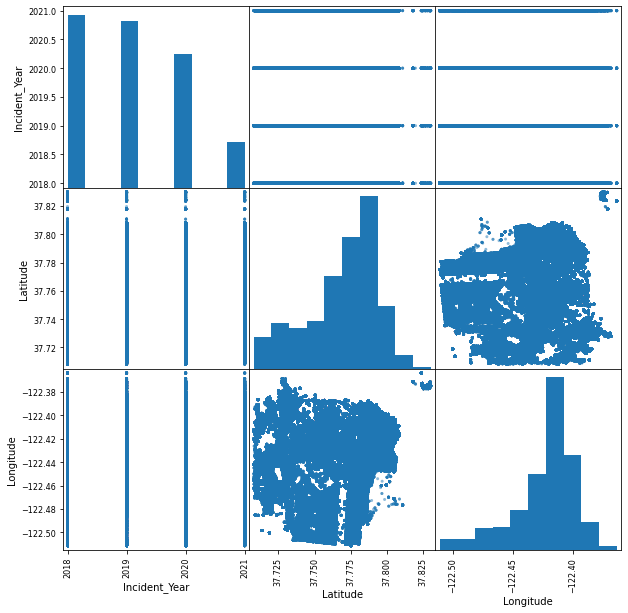

In [101]:
from pandas.plotting import scatter_matrix
#Let's look at the scatterplot  and the descriptive statistics on the outliers and distribution
scatter_matrix(sf_input,figsize=(10,10))
plt.show()

In [102]:
#sf_input [ ['Latitude', 'Longitude'] ] # is equeivalent to sf_input [ ['Latitude', 'Longitude'] ]

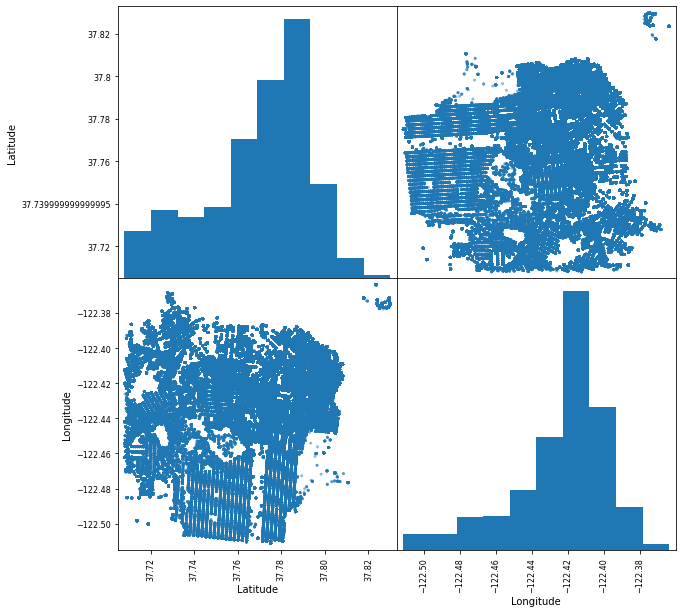

In [103]:

from pandas.plotting import scatter_matrix
#Let's look at the scatterplot  and the descriptive statistics on the outliers and distribution
scatter_matrix(sf_input [ ['Latitude', 'Longitude'] ] ,figsize=(10,10))
plt.show()

### fun thing to observe this is actually correct because there is no land at lat = 37.81, long = -122.39 )
### refer to the folium map of SF

In [104]:
sf_input.describe()

Incident_Year       Latitude      Longitude
count  429260.000000  429260.000000  429260.000000
mean     2019.099189      37.769184    -122.424013
std         0.964565       0.024268       0.026202
min      2018.000000      37.707988    -122.511295
25%      2018.000000      37.755390    -122.434483
50%      2019.000000      37.775834    -122.417901
75%      2020.000000      37.785872    -122.407337
max      2021.000000      37.829991    -122.363743

### 2.8 PREPROCESS ADD DATE_MONTH FOR ANALYSIS purpose 
### we extract the following fields from datetime [Incident_Datetime] for analysis purpose

In [105]:
sf_input['Incident_Date_Month'] = sf_input['Incident_Datetime'].dt.month
#sf_input['Incident_Date_Year'] = sf_input['Incident_Datetime'].dt.year ##already in the df 
sf_input['Incident_Date_dayofweek_num']=sf_input['Incident_Datetime'].dt.dayofweek
#Incident_Date_dayofweek_num: Mon=0,Tue=1,Wed=2...Sun=6 
sf_input['Incident_Datetime_DayOfMonth'] = sf_input['Incident_Datetime'].dt.day
sf_input['Incident_Datetime_HrOfDay'] = sf_input['Incident_Datetime'].dt.hour
sf_input['Incident_Datetime_Minute']= sf_input['Incident_Datetime'].dt.minute

In [106]:
#recheck .describe ()
sf_input.describe() #all the max min values look correct for each field 

Incident_Year       Latitude      Longitude  Incident_Date_Month  Incident_Date_dayofweek_num  Incident_Datetime_DayOfMonth  Incident_Datetime_HrOfDay  Incident_Datetime_Minute
count  429260.000000  429260.000000  429260.000000        429260.000000                429260.000000                 429260.000000              429260.000000             429260.000000
mean     2019.099189      37.769184    -122.424013             6.168746                     2.974703                     15.599939                  13.101899                 20.303758
std         0.964565       0.024268       0.026202             3.502786                     1.976727                      8.855521                   6.417338                 18.747038
min      2018.000000      37.707988    -122.511295             1.000000                     0.000000                      1.000000                   0.000000                  0.000000
25%      2018.000000      37.755390    -122.434483             3.000000                     1.000000                      8.000000                   9.000000                  0.000000
50%      2019.000000      37.775834    -122.417901             6.000000                     3.000000                     16.000000                  14.000000                 19.000000
75%      2020.000000      37.785872    -122.407337             9.000000                     5.000000                     23.000000                  18.000000                 34.000000
max      2021.000000      37.829991    -122.363743            12.000000                     6.000000                     31.000000                  23.000000                 59.000000

## 3. Data Exploration Time

### Obervations there are 42 classes of Incident_Category and Larceny Theft is the highest while some acts are really low in number. This is a imbalance multiclass scenerio and we take this in mind first 

In [107]:
sf_input.shape

(429260, 18)

In [108]:
sf_input.groupby('Incident_Category').size().sort_values(ascending=False).to_frame('size')

size
Incident_Category                                 
Larceny Theft                               124926
Other Miscellaneous                          33470
Malicious Mischief                           28399
Non-Criminal                                 27501
Assault                                      27162
Burglary                                     25245
Motor Vehicle Theft                          20555
Warrant                                      14921
Fraud                                        13064
Recovered Vehicle                            11910
Drug Offense                                 11282
Lost Property                                11153
Robbery                                      10640
Missing Person                                9996
Suspicious Occ                                8966
Disorderly Conduct                            7722
Offences Against The Family And Children      6309
Traffic Violation Arrest                      5537
Weapons Offense                               5263
Miscellaneous Investigation                   4225
Other Offenses                                3654
Other                                         3638
Stolen Property                               2356
Forgery And Counterfeiting                    1774
Case Closure                                  1695
Arson                                         1280
Traffic Collision                              947
Civil Sidewalks                                863
Prostitution                                   858
Vandalism                                      824
Embezzlement                                   617
Fire Report                                    565
Sex Offense                                    517
Courtesy Report                                378
Vehicle Impounded                              320
Suicide                                        200
Vehicle Misplaced                              185
Human Trafficking (A), Commercial Sex Acts     127
Rape                                           104
Homicide                                        52
Liquor Laws                                     38
Gambling                                        22

So we see that Larceny Theft is the highiest while some acts are really low in number. This is a imbalance multiclass scenerio and we take this in mind first 

In [109]:
summaryOf_Crimes = sf_input.groupby('Incident_Category').size().sort_values(ascending=False)
#type(summaryOf_Crimes)

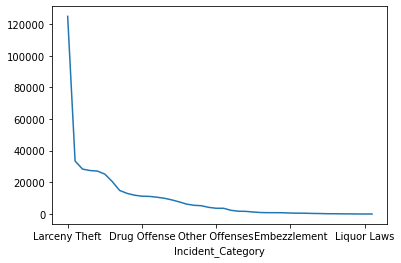

In [110]:
#simple line plot
summaryOf_Crimes.plot()
plt.show()

In [111]:
#matplotlib way
#plt.figure(figsize=(25,20))
#summaryOf_Crimes.plot.bar(rot=15, title="Distribution of Crime Categories");
#plt.show()

In [112]:
#SAFE POINT TO RUN 

In [113]:
summaryOfCrimes_groupBy = sf_input.groupby('Incident_Category') 
summaryOfCrimes_series = summaryOfCrimes_groupBy.size().reset_index()
summaryOfCrimes_series.rename(columns={0: "count"}, inplace=True) 

summaryOfCrimes_df = pd.DataFrame(summaryOfCrimes_series) 
#summryOfCrimes_df.sort_values('count',ascending=False)
sorted_summaryOfCrimes = summaryOfCrimes_df.sort_values('count',ascending=False)
sorted_summaryOfCrimes = sorted_summaryOfCrimes.reset_index().drop(columns=['index'])
sorted_summaryOfCrimes

Incident_Category   count
0                                Larceny Theft  124926
1                          Other Miscellaneous   33470
2                           Malicious Mischief   28399
3                                 Non-Criminal   27501
4                                      Assault   27162
5                                     Burglary   25245
6                          Motor Vehicle Theft   20555
7                                      Warrant   14921
8                                        Fraud   13064
9                            Recovered Vehicle   11910
10                                Drug Offense   11282
11                               Lost Property   11153
12                                     Robbery   10640
13                              Missing Person    9996
14                              Suspicious Occ    8966
15                          Disorderly Conduct    7722
16    Offences Against The Family And Children    6309
17                    Traffic Violation Arrest    5537
18                             Weapons Offense    5263
19                 Miscellaneous Investigation    4225
20                              Other Offenses    3654
21                                       Other    3638
22                             Stolen Property    2356
23                  Forgery And Counterfeiting    1774
24                                Case Closure    1695
25                                       Arson    1280
26                           Traffic Collision     947
27                             Civil Sidewalks     863
28                                Prostitution     858
29                                   Vandalism     824
30                                Embezzlement     617
31                                 Fire Report     565
32                                 Sex Offense     517
33                             Courtesy Report     378
34                           Vehicle Impounded     320
35                                     Suicide     200
36                           Vehicle Misplaced     185
37  Human Trafficking (A), Commercial Sex Acts     127
38                                        Rape     104
39                                    Homicide      52
40                                 Liquor Laws      38
41                                    Gambling      22

In [114]:
#sorted_summartOfCrimes.iloc[0:10]['Incident_Category']

In [115]:
#Another way of getting the top10 categories 
#top10 = summryOfCrimes_df.sort_values('count',ascending=False).head(10)
#top10['Incident_Category']

In [116]:
#sorted_summaryOfCrimes.iloc[0:10]['Incident_Category']

### 3.1 Distrbution of incidents across all categories 

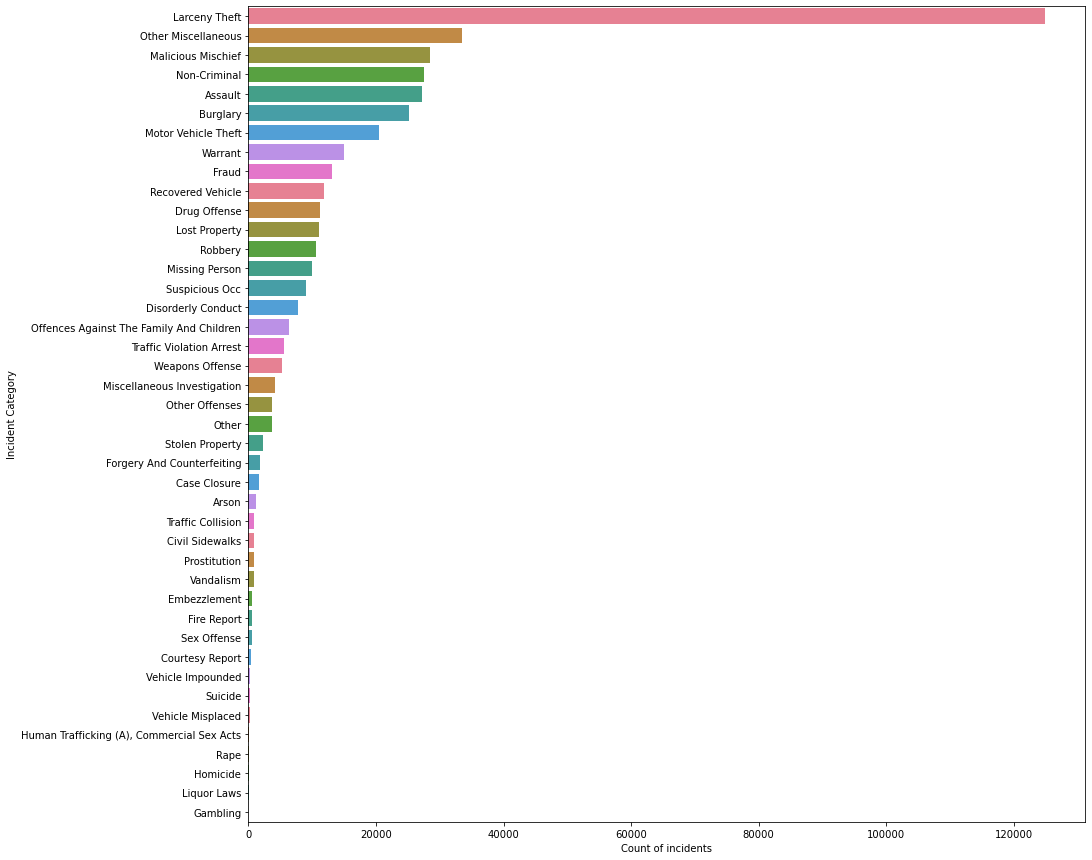

In [117]:

plt.figure(figsize=(15,15))
cp2 = sns.color_palette("husl", 9) 

barplot = sns.barplot(x = 'count',
            y = 'Incident_Category',
            #data = NaN_coord_byDistrict_df,
            #data = summaryOfCrimes_df.sort_values('count',ascending=False),
            #data = summaryOfCrimes_df.sort_values('count',ascending=False),
            data = sorted_summaryOfCrimes,                      
           palette=cp2
           )


#barplot = sns.barplot(x = 'Incident_Category',
#            y = 'count',
            #data = NaN_coord_byDistrict_df,
            #data = summaryOfCrimes_df.sort_values('count',ascending=False),
            #data = summaryOfCrimes_df.sort_values('count',ascending=False),
#            data = sorted_summaryOfCrimes,                      
#           palette=cp2
#           )


plt.xlabel("Count of incidents")
# Show the plot
plt.ylabel("Incident Category")


#barplot.set_xticklabels(rotation=30)
plt.xticks(rotation=0)
#plt.savefig('png_prod\\Distri_Incident_Category.png')
plt.show()



### This is a visual aspect of how many Larceny Theft to the rest of the incidents 

### 3.2 TOP 10 Incident Categories

In [118]:
top10_categories = sorted_summaryOfCrimes.iloc[0:10]['Incident_Category']  

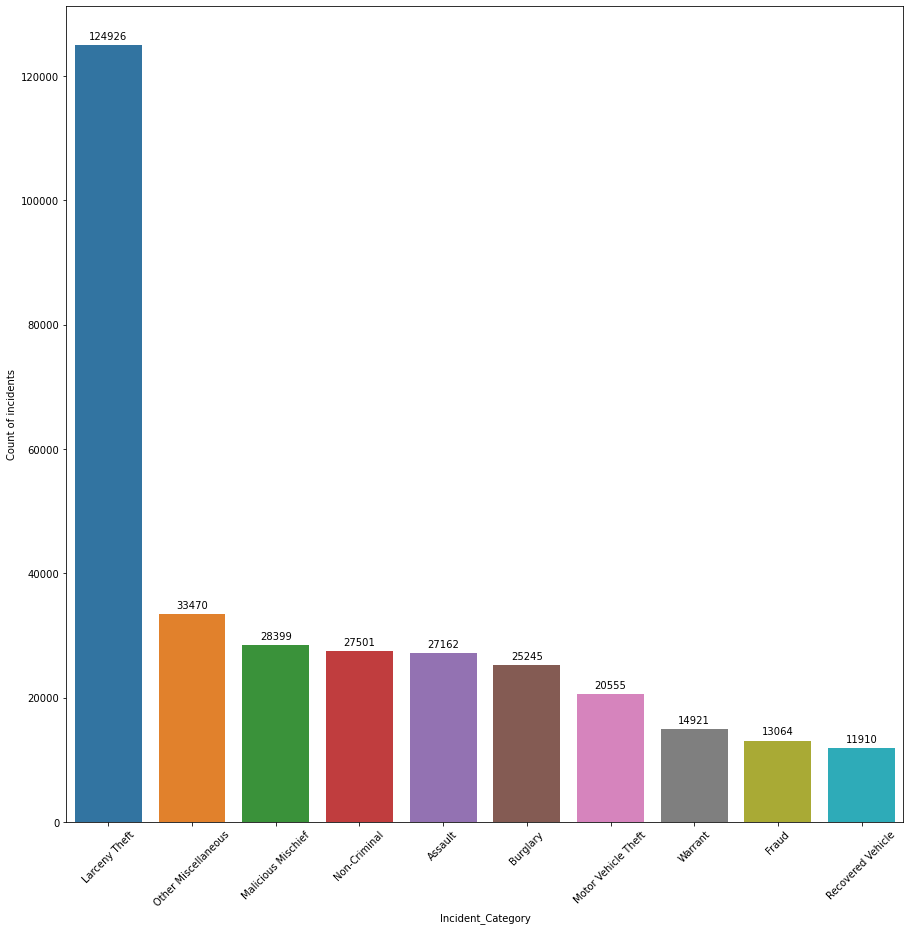

In [119]:
#df.sort_values('Salary',ascending = False).Education
plt.figure(figsize=(15,15))
#cp2 = sns.color_palette("husl", 9) 
#cp2 = sns.color_palette("RdPu", 10)
#cp2 = sns.color_palette("dark:#3182bd")

#reverse the color palette from dark>light 
#n_plots = 10
#sns.set_palette( reversed(sns.color_palette("Blues_d", n_plots)), n_plots)
#sns.set_palette( reversed(sns.color_palette("Greens_d", n_plots)), n_plots)


barplot = sns.barplot(x = 'Incident_Category',
            y = 'count',
            #data = NaN_coord_byDistrict_df,
            #data = summaryOfCrimes_df.sort_values('count',ascending=False),
            #data = summaryOfCrimes_df.sort_values('count',ascending=False),
             data = sorted_summaryOfCrimes,   
            #palette=cp2,
            ##order= top10['Incident_Category'],
            #order= summryOfCrimes_df.sort_values('count',ascending=False) ['Incident_Category']
             order =top10_categories        
           )
plt.ylabel("Count of incidents")
plt.xticks(rotation=45)

#add annontations on the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
# Show the plot
#plt.savefig('png_prod\\TOP10_Distri_Incident_Category.png')
plt.show()

### 3.3 Distribution of Incident Across Years 

In [120]:
#sf_input.columns

In [121]:
summaryOfCrimes_groupBy_Year = sf_input.groupby('Incident_Year') 

In [122]:
summaryOfCrimes_groupBy_Year.size()

Incident_Year
2018    143015
2019    138148
2020    110601
2021     37496
dtype: int64

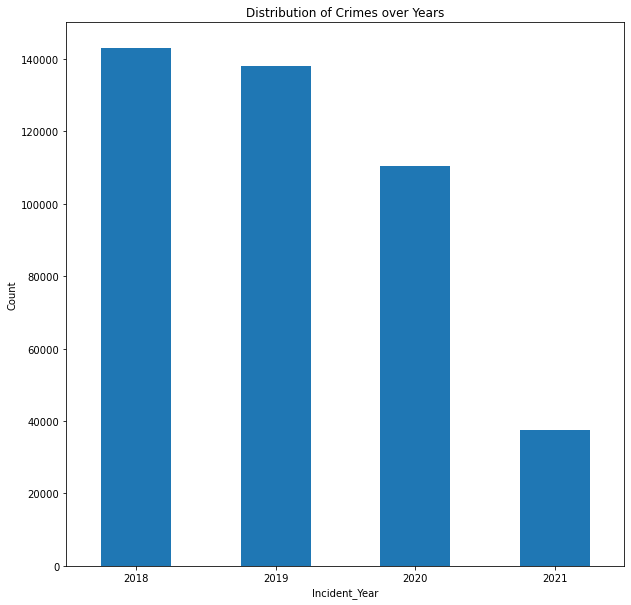

In [123]:
plt.figure(figsize=(10,10))
#plt.xticks(rotation=0)
ax = plt.axes()
ax.set_ylabel('Count')
summaryOfCrimes_groupBy_Year.size().plot.bar(rot=0, title="Distribution of Crimes over Years");
plt.show()

### Looks like there is a gradual decrease of crime incidents from 2018

### 3.4 Distribution of Crimes over Months

In [124]:
summaryOfCrimes_groupBy_Mths = sf_input.groupby('Incident_Date_Month') 
summaryOfCrimes_groupBy_Mths

In [125]:
summaryOfCrimes_groupBy_Mths.size()

Incident_Date_Month
1     44647
2     40405
3     40059
4     38532
5     35012
6     31290
7     34160
8     34576
9     32473
10    34106
11    31611
12    32389
dtype: int64

In [126]:
#plot byy matploblib way 
# plt.figure(figsize=(10,10))
# ax = plt.axes()
# ax.set_ylabel('Count')
# summaryOfCrimes_groupBy_Mths.size().plot.bar(rot=0, title="Distribution of Crimes over Months" )
# plt.show()

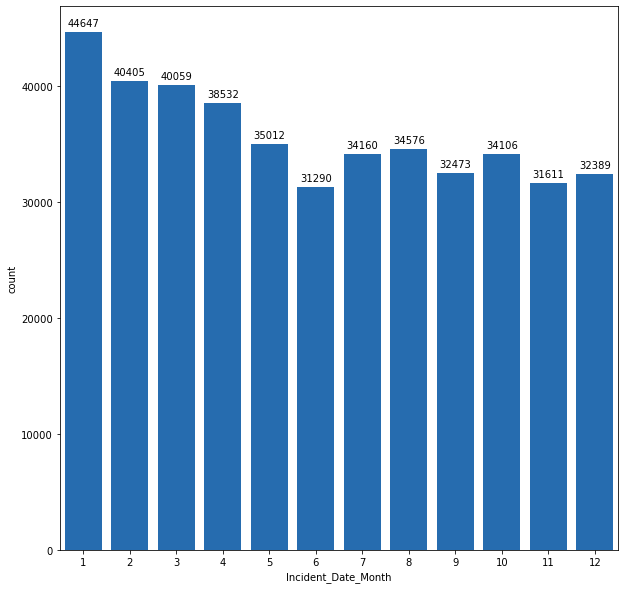

In [127]:
plt.figure(figsize=(10,10))
countplot = sns.countplot(x="Incident_Date_Month", data=sf_input, color="#0F6DC6")

for p in countplot.patches:
    countplot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

#### Observation  : Most crimes seem to occur in Jan , the least in Jun

### However, we can take a look at this under different year, to see if this pattern occurs in general

In [128]:
summaryOfCrimes_groupBy_Year02 = sf_input.groupby( ['Incident_Year','Incident_Date_Month']) 

In [129]:
#summaryOfCrimes_groupBy_Year02.size()

In [130]:
summaryOfCrimes_groupBy_Year02 = summaryOfCrimes_groupBy_Year02.size().reset_index()

In [131]:
summaryOfCrimes_groupBy_Year02.info()
summaryOfCrimes_groupBy_Year02.rename(columns={0: "count"}, inplace=True) 
summaryOfCrimes_groupBy_Year02

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Incident_Year        41 non-null     int64
 1   Incident_Date_Month  41 non-null     int64
 2   0                    41 non-null     int64
dtypes: int64(3)
memory usage: 1.1 KB


Incident_Year  Incident_Date_Month  count
0            2018                    1  12389
1            2018                    2  10975
2            2018                    3  11685
3            2018                    4  11625
4            2018                    5  12056
5            2018                    6  11494
6            2018                    7  12817
7            2018                    8  12941
8            2018                    9  11903
9            2018                   10  12353
10           2018                   11  11236
11           2018                   12  11541
12           2019                    1  11309
13           2019                    2  10201
14           2019                    3  10900
15           2019                    4  10993
16           2019                    5  11444
17           2019                    6  11234
18           2019                    7  12140
19           2019                    8  12619
20           2019                    9  12004
21           2019                   10  12715
22           2019                   11  11242
23           2019                   12  11347
24           2020                    1  11476
25           2020                    2  10651
26           2020                    3   8866
27           2020                    4   7624
28           2020                    5   8965
29           2020                    6   8562
30           2020                    7   9203
31           2020                    8   9016
32           2020                    9   8566
33           2020                   10   9038
34           2020                   11   9133
35           2020                   12   9501
36           2021                    1   9473
37           2021                    2   8578
38           2021                    3   8608
39           2021                    4   8290
40           2021                    5   2547

In [132]:
#summaryOfCrimes_groupBy_Year02.isnull()
#selectYear=2018
#filter2018 = (summaryOfCrimes_groupBy_Year02["Incident_Year"]==selectYear )
#filter2018_df = (summaryOfCrimes_groupBy_Year02 [ filter2018 ])
#filter2018_df

selectYear=2018
filterBySelectedYear = (summaryOfCrimes_groupBy_Year02["Incident_Year"]==selectYear )
filter2018_df = (summaryOfCrimes_groupBy_Year02 [ filterBySelectedYear ])

selectYear=2019
filterBySelectedYear = (summaryOfCrimes_groupBy_Year02["Incident_Year"]==selectYear )
filter2019_df = (summaryOfCrimes_groupBy_Year02 [ filterBySelectedYear ])


selectYear=2020
filterBySelectedYear = (summaryOfCrimes_groupBy_Year02["Incident_Year"]==selectYear )
filter2020_df = (summaryOfCrimes_groupBy_Year02 [ filterBySelectedYear ])


selectYear=2021
filterBySelectedYear = (summaryOfCrimes_groupBy_Year02["Incident_Year"]==selectYear )
filter2021_df = (summaryOfCrimes_groupBy_Year02 [ filterBySelectedYear ])

filter2021_df


Incident_Year  Incident_Date_Month  count
36           2021                    1   9473
37           2021                    2   8578
38           2021                    3   8608
39           2021                    4   8290
40           2021                    5   2547

D:\ProgramData\anaconda3\envs\TP21_CAI1C01_PROJ\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 2880x1440 with 0 Axes>

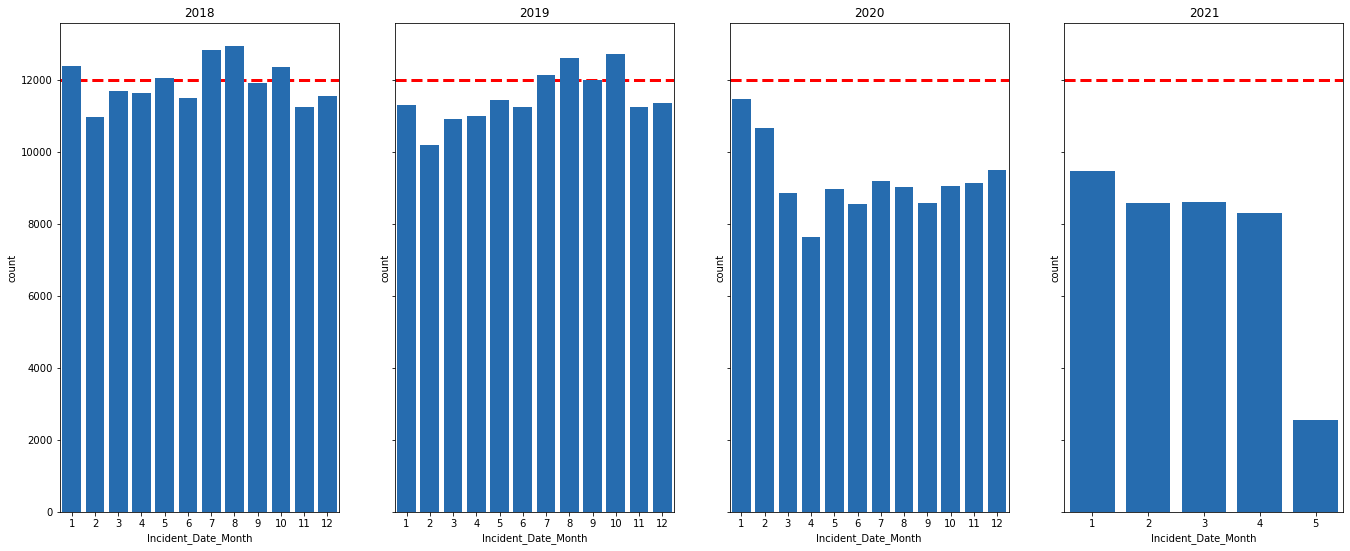

In [133]:
plt.figure(figsize=(40,20))

#fig, ax =plt.subplots(1,4)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(23,9),sharey=True)


countplot2018 = sns.barplot(x="Incident_Date_Month", y="count", data=filter2018_df, color="#0F6DC6", ax=ax[0])
ax[0].set_title('2018')
ax[0].axhline(y=12000,  c="red", linewidth=3, zorder=0 , linestyle='--')

countplot2019 = sns.barplot(x="Incident_Date_Month", y="count", data=filter2019_df, color="#0F6DC6", ax=ax[1])
ax[1].set_title('2019')
ax[1].axhline(y=12000,  c="red", linewidth=3, zorder=0 , linestyle='--')

countplot2020 = sns.barplot(x="Incident_Date_Month", y="count", data=filter2020_df, color="#0F6DC6", ax=ax[2])
ax[2].set_title('2020')
ax[2].axhline(y=12000,  c="red", linewidth=3, zorder=0 , linestyle='--')

countplot2021 = sns.barplot(x="Incident_Date_Month", y="count", data=filter2021_df, color="#0F6DC6", ax=ax[3])
ax[3].set_title('2021')
ax[3].axhline(y=12000,  c="red", linewidth=3, zorder=0 , linestyle='--')

#plt.savefig('png_prod\\CrimeDistributionOverYr_Mth.png')
fig.show()

Observation: It appears that
there is a descending trend from Jan onwards, followed by an upward trend from Jun/Jul onwards.
However, this is not observed in 2020 - as it can be seen that there is a massive drop from Jan'20 - Apr'20 
(One of the reasons could be that the city having a lockdown? - there could be fewer people on the streets, and fewer policemen on patrol - ie. a lack of activity of public in general)

Since 2021 is not over yet, we are unable to see any trend. However, it is noticeable that even for <b>Jan'21</b> , there is only 8473 reported incidents as compared to the rest of the years (2018,2019,2020) 

### 3.5 Distribution of Crimes over Days (of Month )

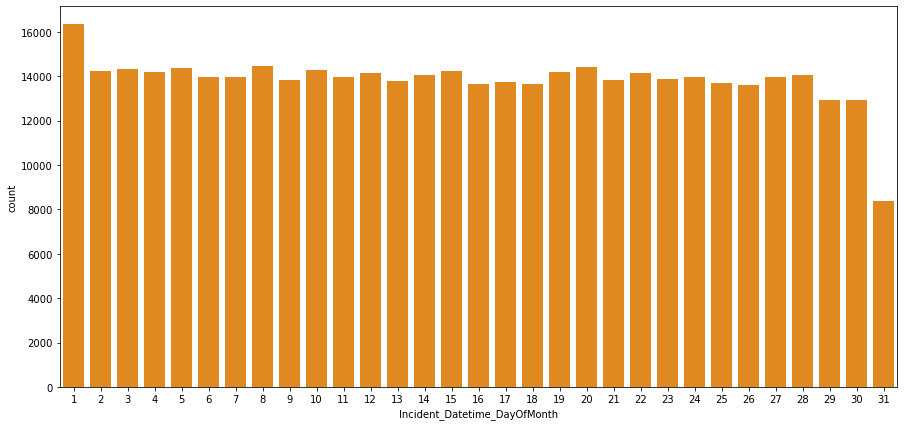

In [134]:
plt.figure(figsize=(15,7))
#cp1 = sns.color_palette("rocket")
#cp1 = sns.color_palette("light:#5A9", as_cmap=True)
countplot = sns.countplot(x="Incident_Datetime_DayOfMonth", data=sf_input, color="darkorange")

#for p in countplot.patches:
#    countplot.annotate(format(p.get_height(), '.0f'), 
#                   (p.get_x() + p.get_width() / 2., p.get_height()), 
#                   ha = 'center', va = 'center', 
#                   xytext = (0, 9), 
#                   textcoords = 'offset points')

plt.show()

Observation : There is no obvious trend here except that most of them seem to occur on 1st day of the month . To be fair, 31st is not likely to 
be accurate as some of the months do not have 31st 

### 3.6 Distribution of Crimes over DayofWeek ( Mon...Tue...)

In [135]:
#summaryOfCrimes_groupBy_DayOfWeek = sf_input.groupby('Incident_DayofWeek') 
#summaryOfCrimes_groupBy_DayOfWeek


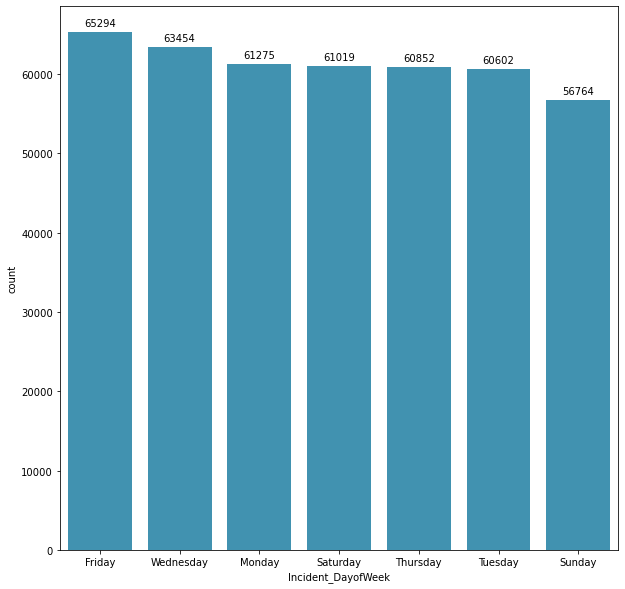

In [136]:
plt.figure(figsize=(10,10))
countplot = sns.countplot(x="Incident_DayofWeek", data=sf_input,color='#2f9bc2',
                          order = sf_input ['Incident_DayofWeek'].value_counts().index )

for p in countplot.patches:
    countplot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

<b>Observations</b> : So it seems that most crimes across on Fri, and the least occured on a Sun.

### 3.7 Distribution of Crimes over Hour of Day

In [137]:
#sf_input['Incident_HrOfDay'] = sf_input['Incident_Datetime'].dt.month
#we create hr od day from the dateimte 
#sf_input['Incident_Datetime_HrOfDay'] = sf_input['Incident_Datetime'].dt.hour

In [138]:
#sf_input.drop(columns=['Incident_HrOfDay'], inplace=True)
##take a peak when we group by hour of day 
sf_input.groupby( ['Incident_Datetime_HrOfDay']).size() 

Incident_Datetime_HrOfDay
0     22421
1     11317
2      9841
3      7757
4      6400
5      6088
6      7354
7     11080
8     15693
9     17242
10    19531
11    20952
12    27751
13    22755
14    22715
15    24024
16    24461
17    26031
18    26410
19    23772
20    21829
21    19428
22    18477
23    15931
dtype: int64

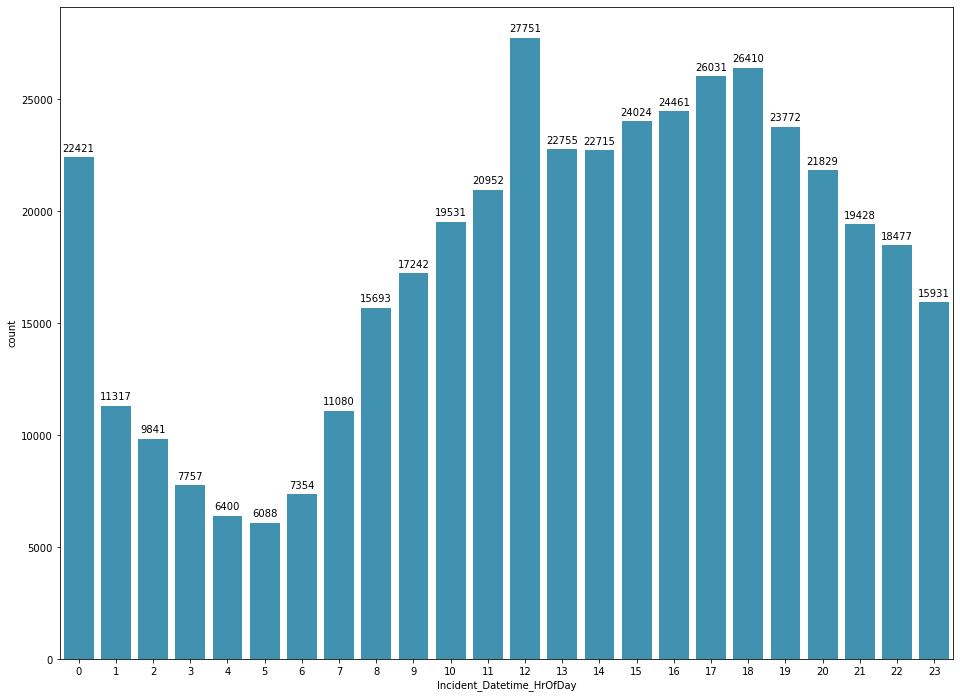

In [139]:
#plt.figure(figsize=(10,10))
#ax = sns.countplot(x="Incident_Datetime_HrOfDay", data=sf_input)

plt.figure(figsize=(16,12))
countplot = sns.countplot(x="Incident_Datetime_HrOfDay", data=sf_input, color='#2f9bc2')

for p in countplot.patches:
    countplot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

<b>Observations</b> : 
It is observed that there are several peaks 
(1) 12pm 
(2) 1800hrs 
(3) After 12midnight

In general, it also appears that most incidents occur after 12pm 

After 0100hrs - 0600hrs, there is a decrease in the trend 

### 3.8 Distrbution of Crimes over different police districts

In [140]:
sf_input.groupby( ['PD_District']).size() 

PD_District
Bayview       39130
Central       64526
Ingleside     34067
Mission       57550
Northern      60572
Park          20866
Richmond      25809
Southern      52660
Taraval       30719
Tenderloin    43361
dtype: int64

In [141]:
summary_groupByDistricts = sf_input.groupby( ['PD_District']).size().reset_index()

In [142]:
#summary_groupByDistricts

In [143]:
summary_groupByDistricts.rename(columns={0: "count"}, inplace=True) 
#summary_groupByDistricts
summary_groupByDistricts = summary_groupByDistricts.sort_values('count',ascending=False)
#summary_groupByDistricts

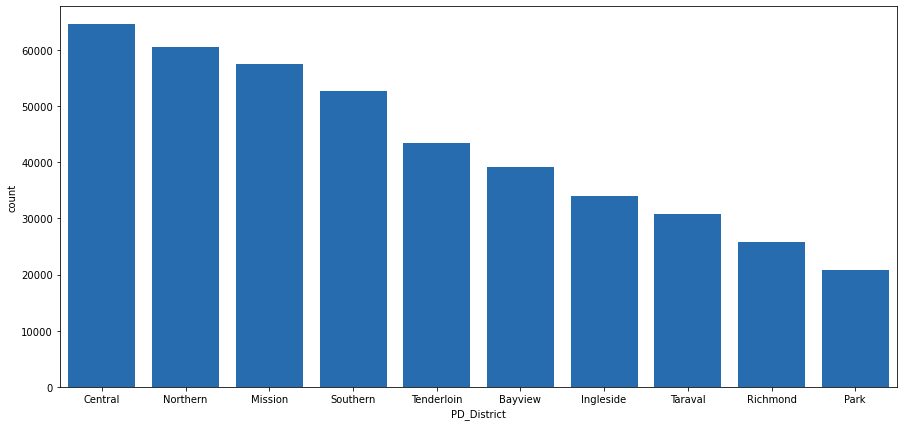

In [144]:
plt.figure(figsize=(15,7))
plotByDistricts = sns.barplot(x="PD_District", y="count", data=summary_groupByDistricts, color="#0F6DC6")
#plt.savefig("png_prod\\Distri_Crime_ByDistricts.png")
plt.show()

### Observation: It appears that Central has the highest number, followed by Northern, Mission

### Let's take a visual peek at the crimes over a map

In [145]:
import folium

In [146]:
#these are the coordinates of SF 
latitude = 37.77
longitude = -122.42

sf_ice_edge = ('shapefiles\CurrentPoliceDistricts.geojson')
m = folium.Map(
    location=[latitude,longitude],
    #tiles="cartodbpositron",
    zoom_start=12
)

In [147]:

district_list = ['CENTRAL', 'SOUTHERN', 'BAYVIEW', 'MISSION','PARK', 'RICHMOND','INGLESIDE','TARAVAL', 'NORTHERN','TENDERLOIN' ] 
lineColorDistricts = ['#339CFF','#339CFF','#339CFF','#339CFF','#339CFF','#339CFF','#339CFF','#339CFF','#339CFF','#339CFF']
#manualfill
#fill_colorDistricts = [ '#E53535','#61B818','#59008e','#59008e','#59008e','#59008e','#59008e','#59008e','#59008e','#59008e'] 


##IMPRTANT we genreate the colors for different districts here 
#import seaborn as sns
#palette = sns.color_palette("Set2",10)

palette =sns.color_palette("pastel",10 )

#print (palette.as_hex() ) 

fill_colorDistricts = palette.as_hex()
#and assign orb_colors 
#a zip that assigns district to a color 
district_colors=dict([[i, sty] for i, sty in zip(district_list, fill_colorDistricts)])
district_colors

{'CENTRAL': '#a1c9f4',
 'SOUTHERN': '#ffb482',
 'BAYVIEW': '#8de5a1',
 'MISSION': '#ff9f9b',
 'PARK': '#d0bbff',
 'RICHMOND': '#debb9b',
 'INGLESIDE': '#fab0e4',
 'TARAVAL': '#cfcfcf',
 'NORTHERN': '#fffea3',
 'TENDERLOIN': '#b9f2f0'}

In [148]:
##IMPRTANT TO STYLE THE DIFFERENT DISTRICT
##we must form district_colors before reaching here 

def style_function(feature):
    #employed = employed_series.get(int(feature["id"][-5:]), None)
    #print ('now the district is %s' %feature['properties']['district'])
    return {
        "fillOpacity": 0.5,
        "weight": 2,
        #"color":  '#D53350',
        "color":  "#339CFF"   ,
        "fillColor": district_colors[ (feature['properties']['district'])]
    }


NOTE : This is the boundaries of each district 

In [149]:
from folium.plugins import MousePosition
#from folium import folium.features.DivIcon
formatter = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"

MousePosition(
    position="topright",
    separator=" | ",
    empty_string="NaN",
    lng_first=True,
    num_digits=20,
    prefix="Coordinates:",
    lat_formatter=formatter,
    lng_formatter=formatter,
).add_to(m)


folium.GeoJson(sf_ice_edge, name="geojson",style_function=style_function,
               tooltip=folium.features.GeoJsonTooltip(
        fields=['district'],
        aliases=['district: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")                
         ) ).add_to(m)



labelTextDistrict='TARAVAL'
TARAVALp1 = [37.738, -122.488]
folium.Marker(TARAVALp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'
        )).add_to(m)

RICHMONDp1 = [37.778, -122.482]
folium.Marker(RICHMONDp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 10pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">RICHMOND</div>'    
        )).add_to(m)
    
labelTextDistrict='INGLESIDE'
INGLESIDEp1 = [37.729, -122.437]
folium.Marker(INGLESIDEp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(m)

labelTextDistrict='PARK'
PARKp1 = [37.768, -122.452]
folium.Marker(PARKp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(m)

labelTextDistrict='CENTRAL'
CENTRALp1 = [37.799, -122.411]
folium.Marker(CENTRALp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(m)



labelTextDistrict='TENDERLOIN'
TENDERLOINp1 = [37.782, -122.413]
folium.Marker(TENDERLOINp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(m)

labelTextDistrict='NORTHERN'
NORTHERNp1 = [37.789, -122.43]
folium.Marker(NORTHERNp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(m)

labelTextDistrict='MISSION'
MISSIONp1 = [37.759, -122.42]
folium.Marker(MISSIONp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(m)

labelTextDistrict='BAYVIEW'
BAYVIEWp1 = [37.736, -122.39]
folium.Marker(BAYVIEWp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(m)

labelTextDistrict='SOUTHERN'
SOUTHERNp1 = [37.776, -122.4]
folium.Marker(SOUTHERNp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(m)


labelTextDistrict='SOUTHERN'
SOUTHERNp1 = [37.824, -122.372]
folium.Marker(SOUTHERNp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(m)

##  -webkit-text-stroke: 1px white;

m


In [150]:
#Crime dsitribution map visual by districts 

sf_by_Districts = sf_input.groupby('PD_District').count()
sf_by_Districts = pd.DataFrame(sf_by_Districts,columns=['Incident_Category'])  # remove unneeded columns
sf_by_Districts.reset_index(inplace=True)   # default index, otherwise groupby column becomes index
sf_by_Districts.rename(columns={'PD_District':'Neighborhood','Incident_Category':'Count'}, inplace=True)

sf_by_Districts [ 'Neighborhood' ]  = sf_by_Districts [ 'Neighborhood' ].str.upper() #rename to upper so we can map to the geojson file

sf_by_Districts.sort_values(by='Count', inplace=True, ascending=False)
sf_by_Districts

Neighborhood  Count
1      CENTRAL  64526
4     NORTHERN  60572
3      MISSION  57550
7     SOUTHERN  52660
9   TENDERLOIN  43361
0      BAYVIEW  39130
2    INGLESIDE  34067
8      TARAVAL  30719
6     RICHMOND  25809
5         PARK  20866

## This is a Visual representation of intensity of crimes over the map of SF 

In [151]:
latitude = 37.77
longitude = -122.42
sf_neighborhood_geo =  ('shapefiles\CurrentPoliceDistricts.geojson')

# Create map
sf_map_crime_distr = folium.Map(
       location=[latitude,longitude],
       zoom_start=12)

folium.Choropleth(
       geo_data=sf_neighborhood_geo,
       data=sf_by_Districts,
       columns=['Neighborhood','Count'],
       key_on='feature.properties.district',
       fill_color='YlOrRd',
       fill_opacity='0.7',
       line_opacity='0.2',
       legend_name='Crime Rate in San Francisco, by Neighborhood').add_to(sf_map_crime_distr)


labelTextDistrict='TARAVAL'
TARAVALp1 = [37.738, -122.488]
folium.Marker(TARAVALp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'
        )).add_to(sf_map_crime_distr)

RICHMONDp1 = [37.778, -122.482]
folium.Marker(RICHMONDp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 10pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">RICHMOND</div>'    
        )).add_to(sf_map_crime_distr)
    
labelTextDistrict='INGLESIDE'
INGLESIDEp1 = [37.729, -122.437]
folium.Marker(INGLESIDEp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(sf_map_crime_distr)

labelTextDistrict='PARK'
PARKp1 = [37.768, -122.452]
folium.Marker(PARKp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(sf_map_crime_distr)

labelTextDistrict='CENTRAL'
CENTRALp1 = [37.799, -122.411]
folium.Marker(CENTRALp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(sf_map_crime_distr)



labelTextDistrict='TENDERLOIN'
TENDERLOINp1 = [37.782, -122.413]
folium.Marker(TENDERLOINp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(sf_map_crime_distr)

labelTextDistrict='NORTHERN'
NORTHERNp1 = [37.789, -122.43]
folium.Marker(NORTHERNp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(sf_map_crime_distr)

labelTextDistrict='MISSION'
MISSIONp1 = [37.759, -122.42]
folium.Marker(MISSIONp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(sf_map_crime_distr)

labelTextDistrict='BAYVIEW'
BAYVIEWp1 = [37.736, -122.39]
folium.Marker(BAYVIEWp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(sf_map_crime_distr)

labelTextDistrict='SOUTHERN'
SOUTHERNp1 = [37.776, -122.4]
folium.Marker(SOUTHERNp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(sf_map_crime_distr)


labelTextDistrict='SOUTHERN'
SOUTHERNp1 = [37.824, -122.372]
folium.Marker(SOUTHERNp1, icon=folium.DivIcon(
        icon_size=(20,20),
        icon_anchor=(7,20),
        #html='<div style="font-size: 10pt; color : blue ;">RICHMOND</div>',    
        html='<div style="font-size: 8pt;-webkit-text-fill-color: white; -webkit-text-stroke-width: 2px; -webkit-text-stroke-color: blue;">'+labelTextDistrict+'</div>'    
        )).add_to(sf_map_crime_distr)

sf_map_crime_distr



### Distrbution of Crimes over different police districts - END 

## 4. Selecting Features And Encoding Districts

In [152]:
#SAFE TO RERUN #RETURNTOTHIS 

In [153]:
#sf_input.head(10)

### 4.1 Basic Correlation with no added new features ( except extraction of date components )

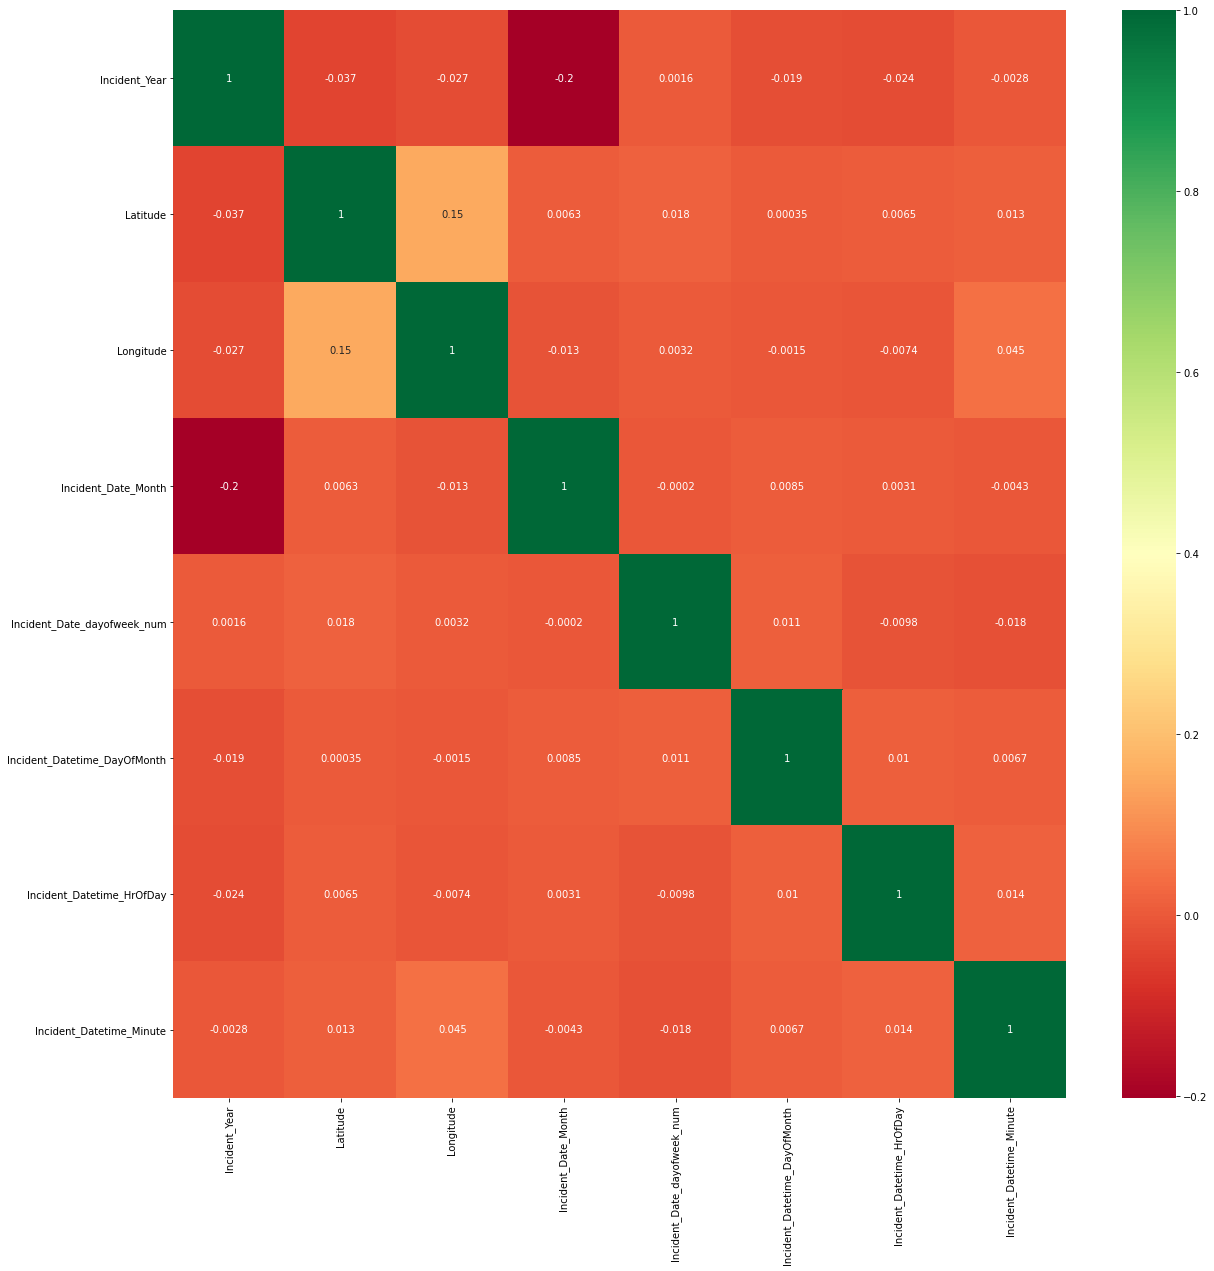

In [154]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = sf_input.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(sf_input[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### NOTE
### Most of these features look ok, they are not really correlated to one-another 

### 4.2 Dummy Encoding the districts since they are categorial

In [155]:
district_df = sf_input [ 'PD_District' ].to_frame() 
district_df
dum_df = pd.get_dummies(district_df, columns=["PD_District"], prefix=["PD_is"] , drop_first=False)
#dum_df
sf_input = sf_input.join(dum_df)
#sf_input

In [156]:
#this will dummy encode the districts since they are categorial 

In [157]:
#sf_input

### 4.3 Create a new field CrimeCounts_By_AnalysisNghrBood 
This calculates the rate of crimes per neighborhood<br/>
The rationale behind this is that we have the neighborhood info [Analysis_Neighborhood] onhand, we can investigate 
if crime_rate is influenced by the count of crimes per neighborhood

In [158]:
sf_input.groupby('Analysis_Neighborhood').size().to_frame().reset_index()
analysis_neighbhorhood_groupBy = sf_input.groupby('Analysis_Neighborhood') 
analysis_neighbhorhood_groupBy_series = analysis_neighbhorhood_groupBy.size().reset_index()
analysis_neighbhorhood_groupBy_series.rename(columns={0: "count"}, inplace=True) 
analysis_neighbhorhood_groupBy_df = pd.DataFrame(analysis_neighbhorhood_groupBy_series)

analysis_neighbhorhood_groupBy_df
analysis_neighbhorhood_groupBy_df_dict = analysis_neighbhorhood_groupBy_df.to_dict(orient = 'split')
analysis_neighbhorhood_groupBy_df_dict ['data']

sf_input [ 'CrimeCounts_By_AnalysisNghrBood' ] = 0 #set everything to 0 first 

#print ( type ( analysis_neighbhorhood_groupBy_df_dict ['data'] ) )
lists_neigbhourshood_crime_counts = analysis_neighbhorhood_groupBy_df_dict ['data'] 
for neighhborhood, count in lists_neigbhourshood_crime_counts:
    #print (neighhborhood, count )
    mask_matchNeighrhood = (sf_input ['Analysis_Neighborhood'] == neighhborhood)
    sf_input.loc[( mask_matchNeighrhood ), ['CrimeCounts_By_AnalysisNghrBood' ]] =  count 

In [159]:
sf_input [  ['Analysis_Neighborhood', 'CrimeCounts_By_AnalysisNghrBood'] ]

Analysis_Neighborhood  CrimeCounts_By_AnalysisNghrBood
0                  Tenderloin                            44398
1                     Mission                            47587
2           Lone Mountain/USF                             5473
3             South of Market                            35337
4             South of Market                            35337
...                       ...                              ...
429255              Japantown                             4251
429256  Bayview Hunters Point                            27203
429257                Mission                            47587
429258        Sunset/Parkside                            12749
429259    Castro/Upper Market                            13394

[429260 rows x 2 columns]

## 4.4 Examining Correlation Matrix After Adding in new field

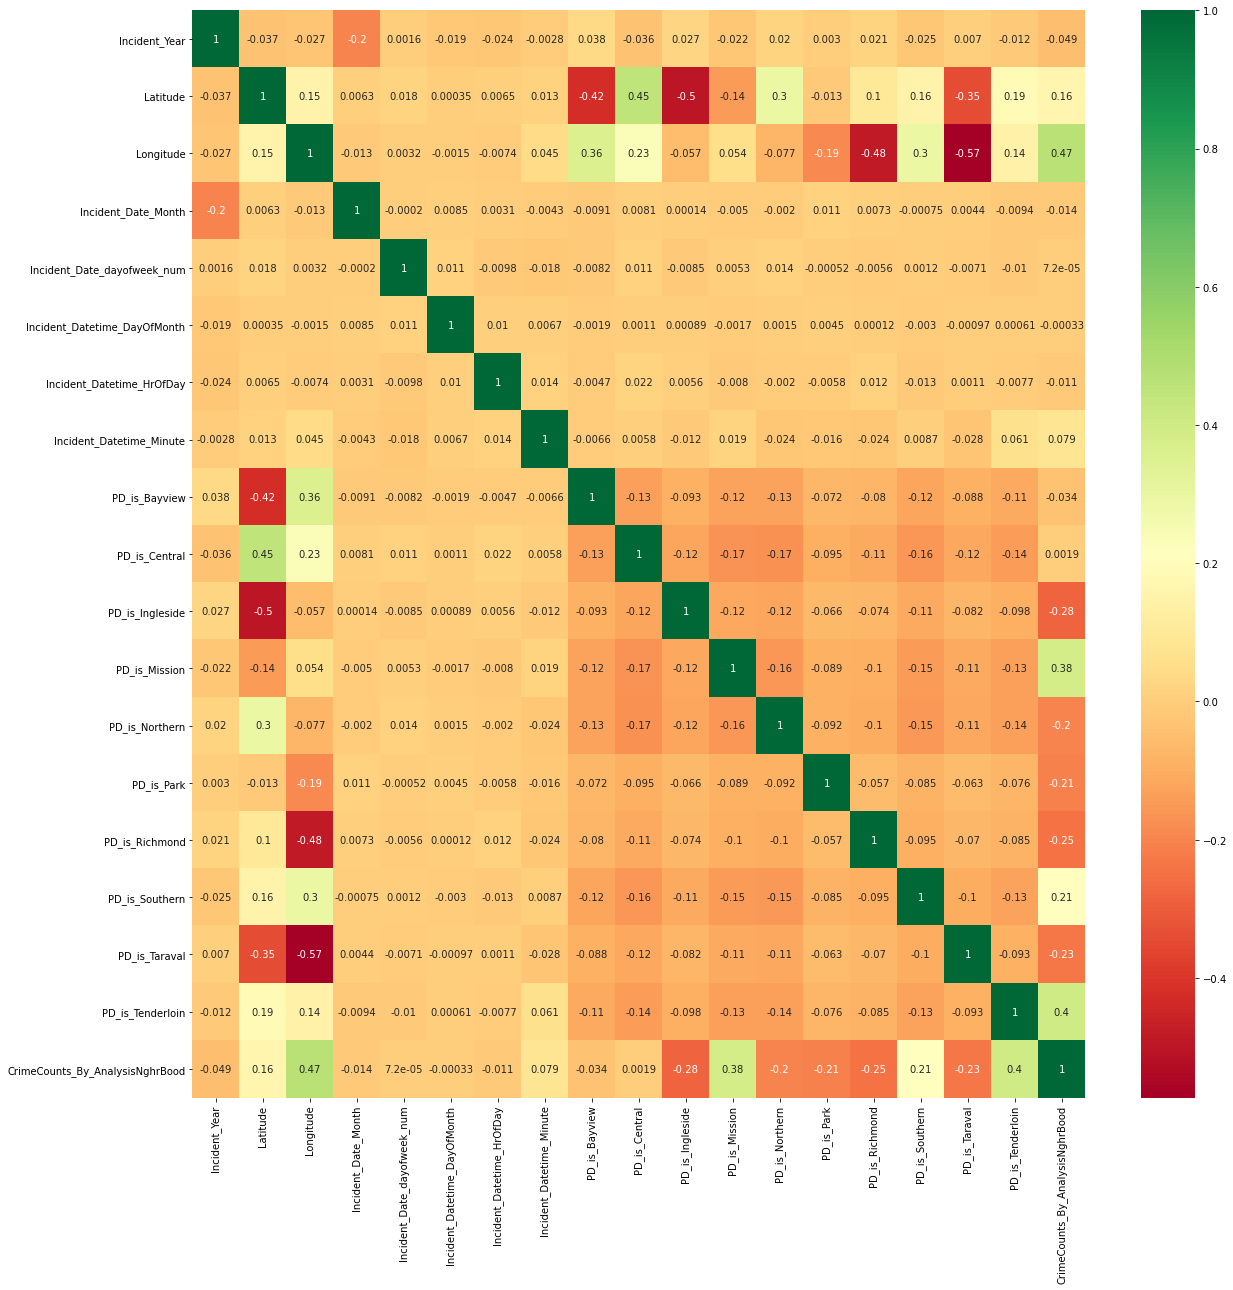

In [160]:
corrmat = sf_input.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(sf_input[top_corr_features].corr(),annot=True,cmap="RdYlGn")
#plt.savefig('png_prod\\Feature_Correlation_fin.png')
plt.show ( )

### NOTE
It is observed that there is not much correlation of the dummy-encoded districts to the rest of the numeric features. 
The correlation of the (lat,long) is <b>expected</b> since each district are at different locations. The rest of them looks ok

### 4.5 EXAMIING FEATURE IMPORTANCE before training

### 4.5.1 Examining Feature importance through KBest 

In [161]:
#use f_classif to handle categorial target variable 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif


x = sf_input[ [ 'Incident_Year','Incident_Date_Month','Incident_Datetime_DayOfMonth',
               'Incident_Datetime_HrOfDay' ,'Incident_Datetime_Minute','Incident_Date_dayofweek_num',
                'Latitude', 'Longitude', 'CrimeCounts_By_AnalysisNghrBood'
              ]]

y = sf_input[ 'Incident_Category' ]     #target column i.e price range

bestfeatures = SelectKBest(score_func=f_classif, k='all')
bestfeatures.fit (x,y)


dfscores = pd.DataFrame(bestfeatures.scores_  )

#dfscores = pd.DataFrame(fit.scores_)

dfcolumns = pd.DataFrame(x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)



featureScores.columns = ['Feature','Score']  #naming the dataframe columns
featureScores.sort_values( by=['Score'], ascending=False)
#featureScores
#featureScores.round(6) 
#featureScores
#matplotlib way 
## what are scores for the features
#for i in range(len(fs.scores_)):
#    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
#plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
#plt.show()

Feature       Score
4         Incident_Datetime_Minute  806.274700
8  CrimeCounts_By_AnalysisNghrBood  579.319672
6                         Latitude  346.756626
0                    Incident_Year  193.324471
3        Incident_Datetime_HrOfDay  188.400330
7                        Longitude  165.764664
5      Incident_Date_dayofweek_num   31.839579
1              Incident_Date_Month    7.766709
2     Incident_Datetime_DayOfMonth    6.295517

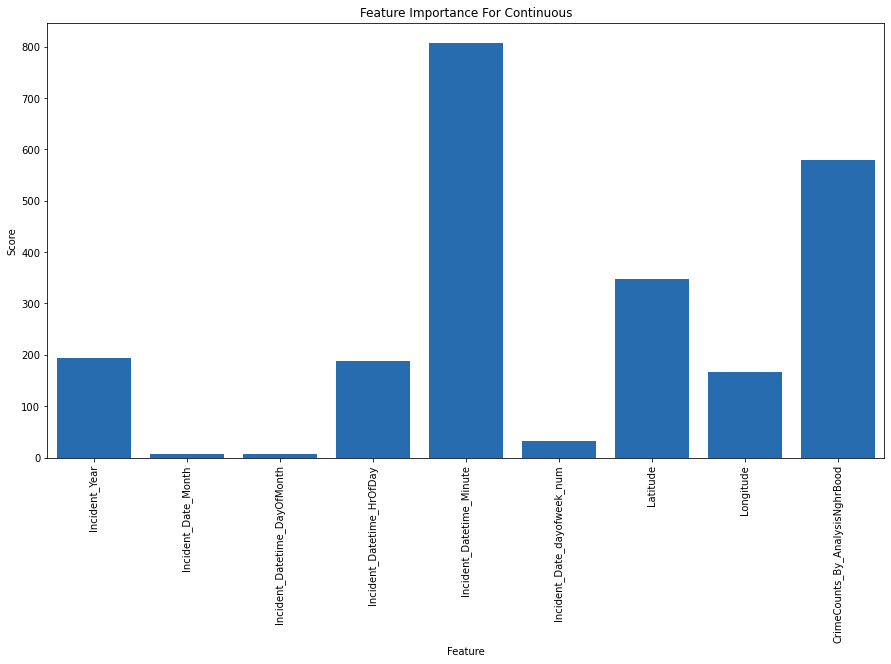

In [162]:
#featureScores in a visual way
plt.figure(figsize=(15,8))
#plt.title = 

sns.barplot(x = 'Feature',
            y = 'Score',
            #data = NaN_coord_byDistrict_df,
            data = featureScores,
            color="#0F6DC6"
           )
plt.ylabel("Score")
plt.xticks(rotation=90)
plt.title( 'Feature Importance For Continuous' )
# Show the plot
#plt.savefig('png_prod\\Feature_Importance_b4Train_003.png')
plt.show()

In [163]:
#use f_classif to handle categorial target variable 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif


x = sf_input[ [ 
               'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
               'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin'
              ]]

y = sf_input[ 'Incident_Category' ]     #target column i.e price range

bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
featureScores.sort_values( by=['Score'], ascending=False)

Feature         Score
9  PD_is_Tenderloin  24465.134752
5        PD_is_Park   9322.585423
0     PD_is_Bayview   7431.210442
1     PD_is_Central   6246.951467
4    PD_is_Northern   5130.211502
3     PD_is_Mission   3742.246870
2   PD_is_Ingleside   3144.068397
8     PD_is_Taraval   2922.073896
6    PD_is_Richmond   2437.107811
7    PD_is_Southern    923.831836

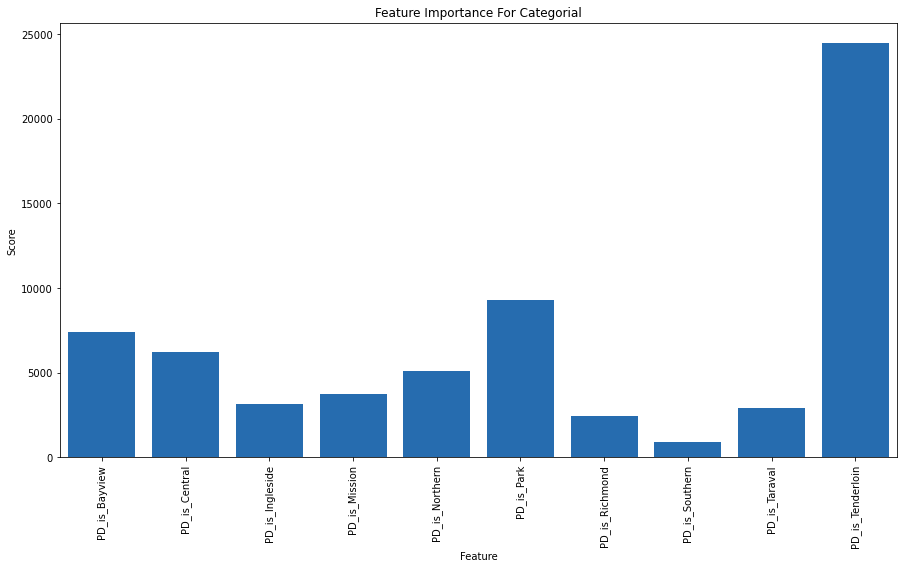

In [164]:
#featureScores in a visual way
plt.figure(figsize=(15,8))
#plt.title = 

sns.barplot(x = 'Feature',
            y = 'Score',
            #data = NaN_coord_byDistrict_df,
            data = featureScores,
            color="#0F6DC6"
           )
plt.ylabel("Score")
plt.xticks(rotation=90)
plt.title( 'Feature Importance For Categorial' )
# Show the plot
#plt.savefig('png_prod\\Feature_Importance_b4Train_004.png')
plt.show()

### Observation : We see all these features do not present major problems at the moment

## For now, this is a list of features selected for training the models
'Incident_Year'<br/>
'Incident_Date_Month'<br/>
'Incident_Datetime_DayOfMonth'<br/>
'Incident_Datetime_HrOfDay'<br/>
'Incident_Datetime_Minute' <br/>
'Incident_Date_dayofweek_num<br/>
'Latitude' <br/>
'Longitude'<br/>
'CrimeCounts_By_AnalysisNghrBood' <br/>
 
 Districts are <b>dummy coded</b> <br/>
 PD_is_Bayview <br/> 
 PD_is_Central <br/>
 PD_is_Ingleside <br/>
 PD_is_Mission <br/>
 PD_is_Northern <br/>
 PD_is_Park <br/>
 PD_is_Richmond <br/>
 PD_is_Southern <br/>
 PD_is_Taraval <br/>
 PD_is_Tenderloin <br/>


In [165]:
#SAFETORERUN #RETURNTOTHIS 3

In [166]:
#create a deep opy of the sf - in case we need it later 
#temp commented off 
#sf_input_copy = sf_input.copy(deep=True)


## 5. Playing with models 

### 5.1 COMPARE AGAINST A NUMBER OF CLASSIFIER ALGOS

In [167]:
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

from xgboost import XGBClassifier

from itertools import cycle

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
#from sklearn.metrics import average_precision_score 

from yellowbrick.target import ClassBalance
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport

import scikitplot as skplt

from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.preprocessing import LabelEncoder

import gc

In [168]:
#helper function to clear memory in case this takes up way too much RAM & system is threatening a reboot
def clearMemory_callGC():
    gc.collect()

    try:
        del model
    except NameError:
        pass
 
    try:
        del confusion_ADA_cm
    except NameError:
        pass        
        
    try:
        del confusion_DT_cm
    except NameError:
        pass
        
    try:    
        del confusion_RFC_cm
    except NameError:
        pass
        
    try:    
        del visualizer
    except NameError:
        pass
    
    try:    
        del confusion_RFC_Tuned_cm
    except NameError:
        pass
    
    try:    
        del confusion_DT_Tuned_cm
    except NameError:
        pass

    gc.collect()
    plt.close("all")
    plt.clf()
    gc.collect()

In [169]:
def printDistribution_Of_Y( orig_y, titleOf_plot ):
    #fig, ax = plt.subplots()  #create figure and axes
    
    plt.figure(figsize=(15,10))
    plt.title( titleOf_plot )
    #le = LabelEncoder() 
    #y_classes = le.fit_transform(orig_y)
    #print (y_classes)
    
    #mapping = dict(zip(le.classes_, range(len(le.classes_))))
    #print (mapping)
    
    # summarize distribution
    counter01 = Counter(orig_y)
    #print ( counter01 )
    #print ('---SORTED----')
    #print ( sorted(counter01.items()) ) 
    #print ( type (  sorted(counter01.items()) ) )
    #print ('---SORTED----')
    
   
        
    sorted_occurrences = list(dict(sorted(counter01.items())).values()) 
    sorted_occurrences_S1 =  (dict(sorted(counter01.items())).values()) 
    #print (sorted_occurrences)
    #print ('---SORTED01----')
   
    for element in sorted(counter01.items()):
        #print ('E', element)
        print ( element[0], element[1] )
        plt.bar(element[0],  element[1])
        
        
    #print ( sorted_occurrences_S1 )
    #dict_SO = dict ( )
    #print ('---SORTED01----')
    
    
    for k,v in counter01.items():
        per = v / len(orig_y) * 100
        #print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
    # plot the distribution
    #plt.bar(counter01.keys(), counter01.values())
    #plt.bar( sorted(counter01.items()), sorted_occurrences )
    
    
    plt.xticks(rotation=90, ha='center')
    
    
    
    def add_value_labels(ax, spacing=5):
        """Add labels to the end of each bar in a bar chart.
        Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
        """

        # For each bar: Place a label
        for rect in ax.patches:
            # Get X and Y placement of label from rect.
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2

            # Number of points between bar and label. Change to your liking.
            space = spacing
            # Vertical alignment for positive values
            va = 'bottom'

            # If value of bar is negative: Place label below bar
            if y_value < 0:
                # Invert space to place label below
                space *= -1
                # Vertically align label at top
                va = 'top'

            # Use Y value as label and format number with one decimal place
            label = "{:.0f}".format(y_value)

            # Create annotation
            ax.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(0, space),          # Vertically shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                ha='center',                # Horizontally center label
                va=va,rotation=90)                      # Vertically align label differently for
                                        # positive and negative values.


    # Call the function above. All the magic happens there.
    add_value_labels(plt.gca())
    plt.show()

In [170]:
#horizontal bar plot for y_test, y_pred with the classes 
def printDistribution_TestVsPred ( y_test, y_pred ):
##TODO MERGE INTO 1 FUNCTION 
#type ( y_test )
    df03 = pd.DataFrame()
    df03 ["y_test"] = y_test
    df04 = df03.groupby (df03['y_test'])
    df05 = df04.size().reset_index()
    df05.rename(columns={0: "y_test_count"}, inplace=True) 
    df05 = df05.rename(columns={'y_test':'category'})
    df06 = pd.DataFrame()
    df06 ["y_pred"] = y_pred 
    df07 = df06.groupby (df06['y_pred'])
    df07 = df07.size().reset_index()
    df07.rename(columns={0: "y_pred_count"}, inplace=True) 
    df07 = df07.rename(columns={'y_pred':'category'})


    df_outer = pd.merge(df05, df07,  on='category', how='outer')
    df_outer.fillna(0, inplace=True )

    pltObject = df_outer.plot(x="category", y=["y_test_count", "y_pred_count"], kind="barh",figsize=(17,10) ,fontsize=12, title ='TEST VS PRED')

    for p in pltObject.patches:
        pltObject.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2), xytext=(8, 0), textcoords='offset points', ha="left", va="center")
    
    plt.tight_layout()
    plt.xlabel('COUNT')
    plt.show()


In [171]:
import numpy as np
import math

# y_incoming: pass in either y_train or y to generate a dict class_weight_dict { CLASS:weight, CLASS1:weight2} 
# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight02(y_incoming,mu=0.15):
    
    
    labels_dict = {} 
    cnt = Counter(y_incoming)
    
    for key, value in cnt.items():
        labels_dict[key] = value
    
    total = np.sum(list(labels_dict.values())) #sum of all classes samples in dict 
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        ##print ('key is' , key, '..', labels_dict[key] )
        score = math.log(mu*total/float(labels_dict[key])) ## log (mu*total / class_size)
        #print ('key is' , key, '..', labels_dict[key] , '....' , score )
        class_weight[key] = score if score > 1.0 else 1.0 #if score is >1 ,st to score or else set=1
    
    return class_weight

In [172]:
#printDistribution_Of_Y (y_pred, 'PRED SET' )

In [ ]:
#SAFETORETURN 4

### 5.1 Now we will do a kfold across a number of classifiers to find out how they perform  

In [ ]:
#!!!this will take time!!!!
#Spot Check Algorithms
models = []
models.append(('CART', DecisionTreeClassifier(random_state=88)))
models.append(('RFC', RandomForestClassifier(random_state=88))) 
#models.append(('LR', LogisticRegression(random_state=2121, multi_class='ovr', max_iter=1000, C=0.1)))
models.append(('NB', GaussianNB()))
models.append(('ADA', AdaBoostClassifier(random_state=88))) 
models.append(('BaggingClassifier', BaggingClassifier (random_state=88) ))
models.append(('XGBOOST', XGBClassifier(random_state=88)))
#models.append(('SVM', SVC(gamma='auto')))  #this did not get to complete after 4 hrs of waiting. do not use this
models.append(('KNN', KNeighborsClassifier()))
models.append(('GBC', GradientBoostingClassifier(random_state=88)))


In [ ]:
features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin',      
                   'Latitude', 'Longitude', 'CrimeCounts_By_AnalysisNghrBood' ]

x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test


In [ ]:
#!!!this will take time!!!!
# evaluate each model in turn
import time 

seed = 88
scoring = 'accuracy'
#use accuracy to score for the model and see each turn up 


results = []
names = []
#do a kfold=7 
for name, model in models:
    start = time.time()
    kfold = model_selection.KFold(n_splits=7, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring, n_jobs=3)
    end = time.time() 
    delta = end - start
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f) --- [Time Taken in seconds] %s" % (name, cv_results.mean(), cv_results.std(), delta)
    print(msg)
    

The above will take ages to run. This is the accuracy and runtimes of one-run performed



| model                    |accuracy| time(taken)|
|:------------------------:|:------:|:----------:|
CART             	|	22.805	|42.79	seconds |
RFC              	|	33.1364	|7.03	minutes|
NB               	|	4.6642	|6.95	seconds|
ADA              	|	28.207	|5.91	minutes|
BaggingClassifier	|	29.3815	|2.00	minutes|
XGBOOST          	|	33.5687	|35.65	minutes|
KNN              	|	23.2457	|19.9	minutes|
GBC              	|	30.8148	|208.02	minutes|



|After introducing 'CrimeCounts_By_AnalysisNghrBood' |
|:-------------------------------------------------:|

| model                    |accuracy| time(taken in minutes)|
|:------------------------:|:------:|:----------:|
CART             	|	22.7837	|	0.43958842	|
RFC              	|	33.186	|	7.090382024	|
NB               	|	29.3342	|	0.119177258	|
ADA              	|	28.6533	|	5.835134919	|
BaggingClassifier	|	29.3745	|	2.031154434	|
XGBOOST          	|	33.5907	|	37.11402934	|
KNN              	|	23.9512	|	21.97902185	|
GBC              	|	31.4847	|	225.5859336	|


Of these, what is not <b>shown</b> is 
- LR is not able to convergene after numerous attempts to set `random_state=88, multi_class='ovr', max_iter=1000, C=0.1`. 
- SVM is also not a good candidate as there was a long run (after 4++hrs ) which is not able to churn out any displays

So it appears, these are the initial estimates of the models that seem to strike a balance between time and accuracy 
- RFC (Random Forest, Ensemble) 
- ADA (AdaBoost, Ensemble)
- CART (Decision Tree) 

But we observe that the overall accuracy is not fanastic and only holding up at <b>max. 33%</b> 

### Since all of them are not perfoming above 33%, we take RFC as a reference and look closer into this
### The strategy is to form a base model using the selected models , investigate the performance and fine tune any hyperparameters


### 5.2 A Base Model for RFC (RandomForestClassifer)

In [174]:
#BRIEF RANDOMFOREST 
#'Incident_Datetime' = 'Incident_Year' + 'Incident_Date_Month' + Incident_Datetime_DayOfMonth + Incident_Datetime_HrOfDay + Incident_Datetime_Minute 
features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'Latitude', 'Longitude','CrimeCounts_By_AnalysisNghrBood']


x = sf_input[features_selected05] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

#the above will translate to this in .values.ravel()
#y = sf_input.loc[ :, ['Incident_Category'] ] # Target variable
#y = y.values.ravel()

#print (y.shape)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test

model = RandomForestClassifier (random_state=88, n_jobs=-1)
# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)


accuracy_score_01 = accuracy_score(y_test, y_pred)*100
f1_score_01 = f1_score(y_test, y_pred,average='weighted')*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 ##try change to micro ,average='micro'
# macro = Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
#weighted = takes in the imbalance in classes 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100  
#area_under_pr_curve01 = average_precision_score ( y_test, model.predict_proba(x_test) , average='weighted') #this does not support multiclass

print('------------ [Base RFC ]------------')
print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 

print ('No of Classes in Y--> %d' %(len(model.classes_)))


#counter_y_pred = Counter(y_pred)
#print (counter_y_pred )
#printDistribution_Of_Y (y_test , 'TEST SET' )
print('-----------End [Base RFC ]---------')


print(classification_report(y_test, y_pred,zero_division=0))

------------ [Base RFC ]------------
Accuracy: 33.68
f1_score: 28.51
Precision :28.01
Recall :33.68
ROC_AUC SCORE :65.84
No of Classes in Y--> 42
-----------End [Base RFC ]---------
                                            precision    recall  f1-score   support

                                     Arson       0.18      0.07      0.10       369
                                   Assault       0.20      0.18      0.19      8083
                                  Burglary       0.30      0.21      0.25      7548
                              Case Closure       0.04      0.03      0.04       499
                           Civil Sidewalks       0.47      0.50      0.48       261
                           Courtesy Report       0.00      0.00      0.00       121
                        Disorderly Conduct       0.08      0.05      0.06      2344
                              Drug Offense       0.44      0.52      0.47      3397
                              Embezzlement       0.23      0.

In [ ]:
#not sure why but this is taking way too long to plot, use scikitplot instead 
## from yellowbrick.classifier import PrecisionRecallCurve

## plt.figure(figsize=(20,20))
## viz = PrecisionRecallCurve(model , per_class =True, cmap="Set1", fill_area=False , classes=model.classes_)
## viz.fit(x_train, y_train)
## viz.score(x_test, y_test)
## viz.show()

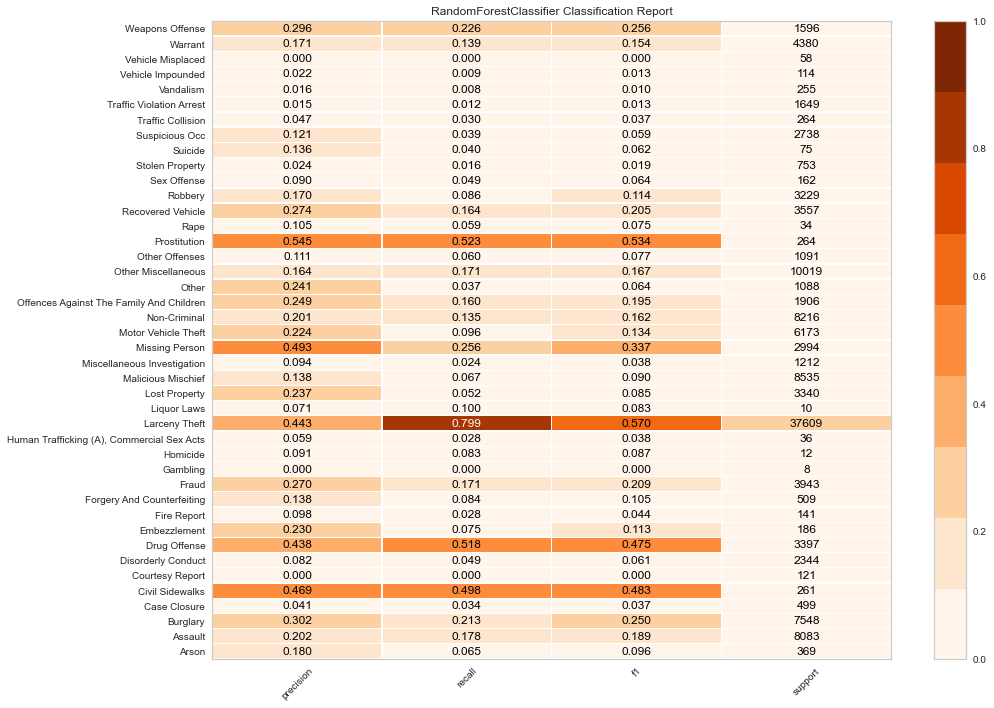

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [175]:
plt.figure(figsize=(15,10))

visualizer = ClassificationReport(model, support=True,cmap='Oranges')

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
#visualizer.show(outpath="png_prod\\RFC_BaseRun_001_ClassificationReport_001.png")
visualizer.show()                       # Finalize and show the figure

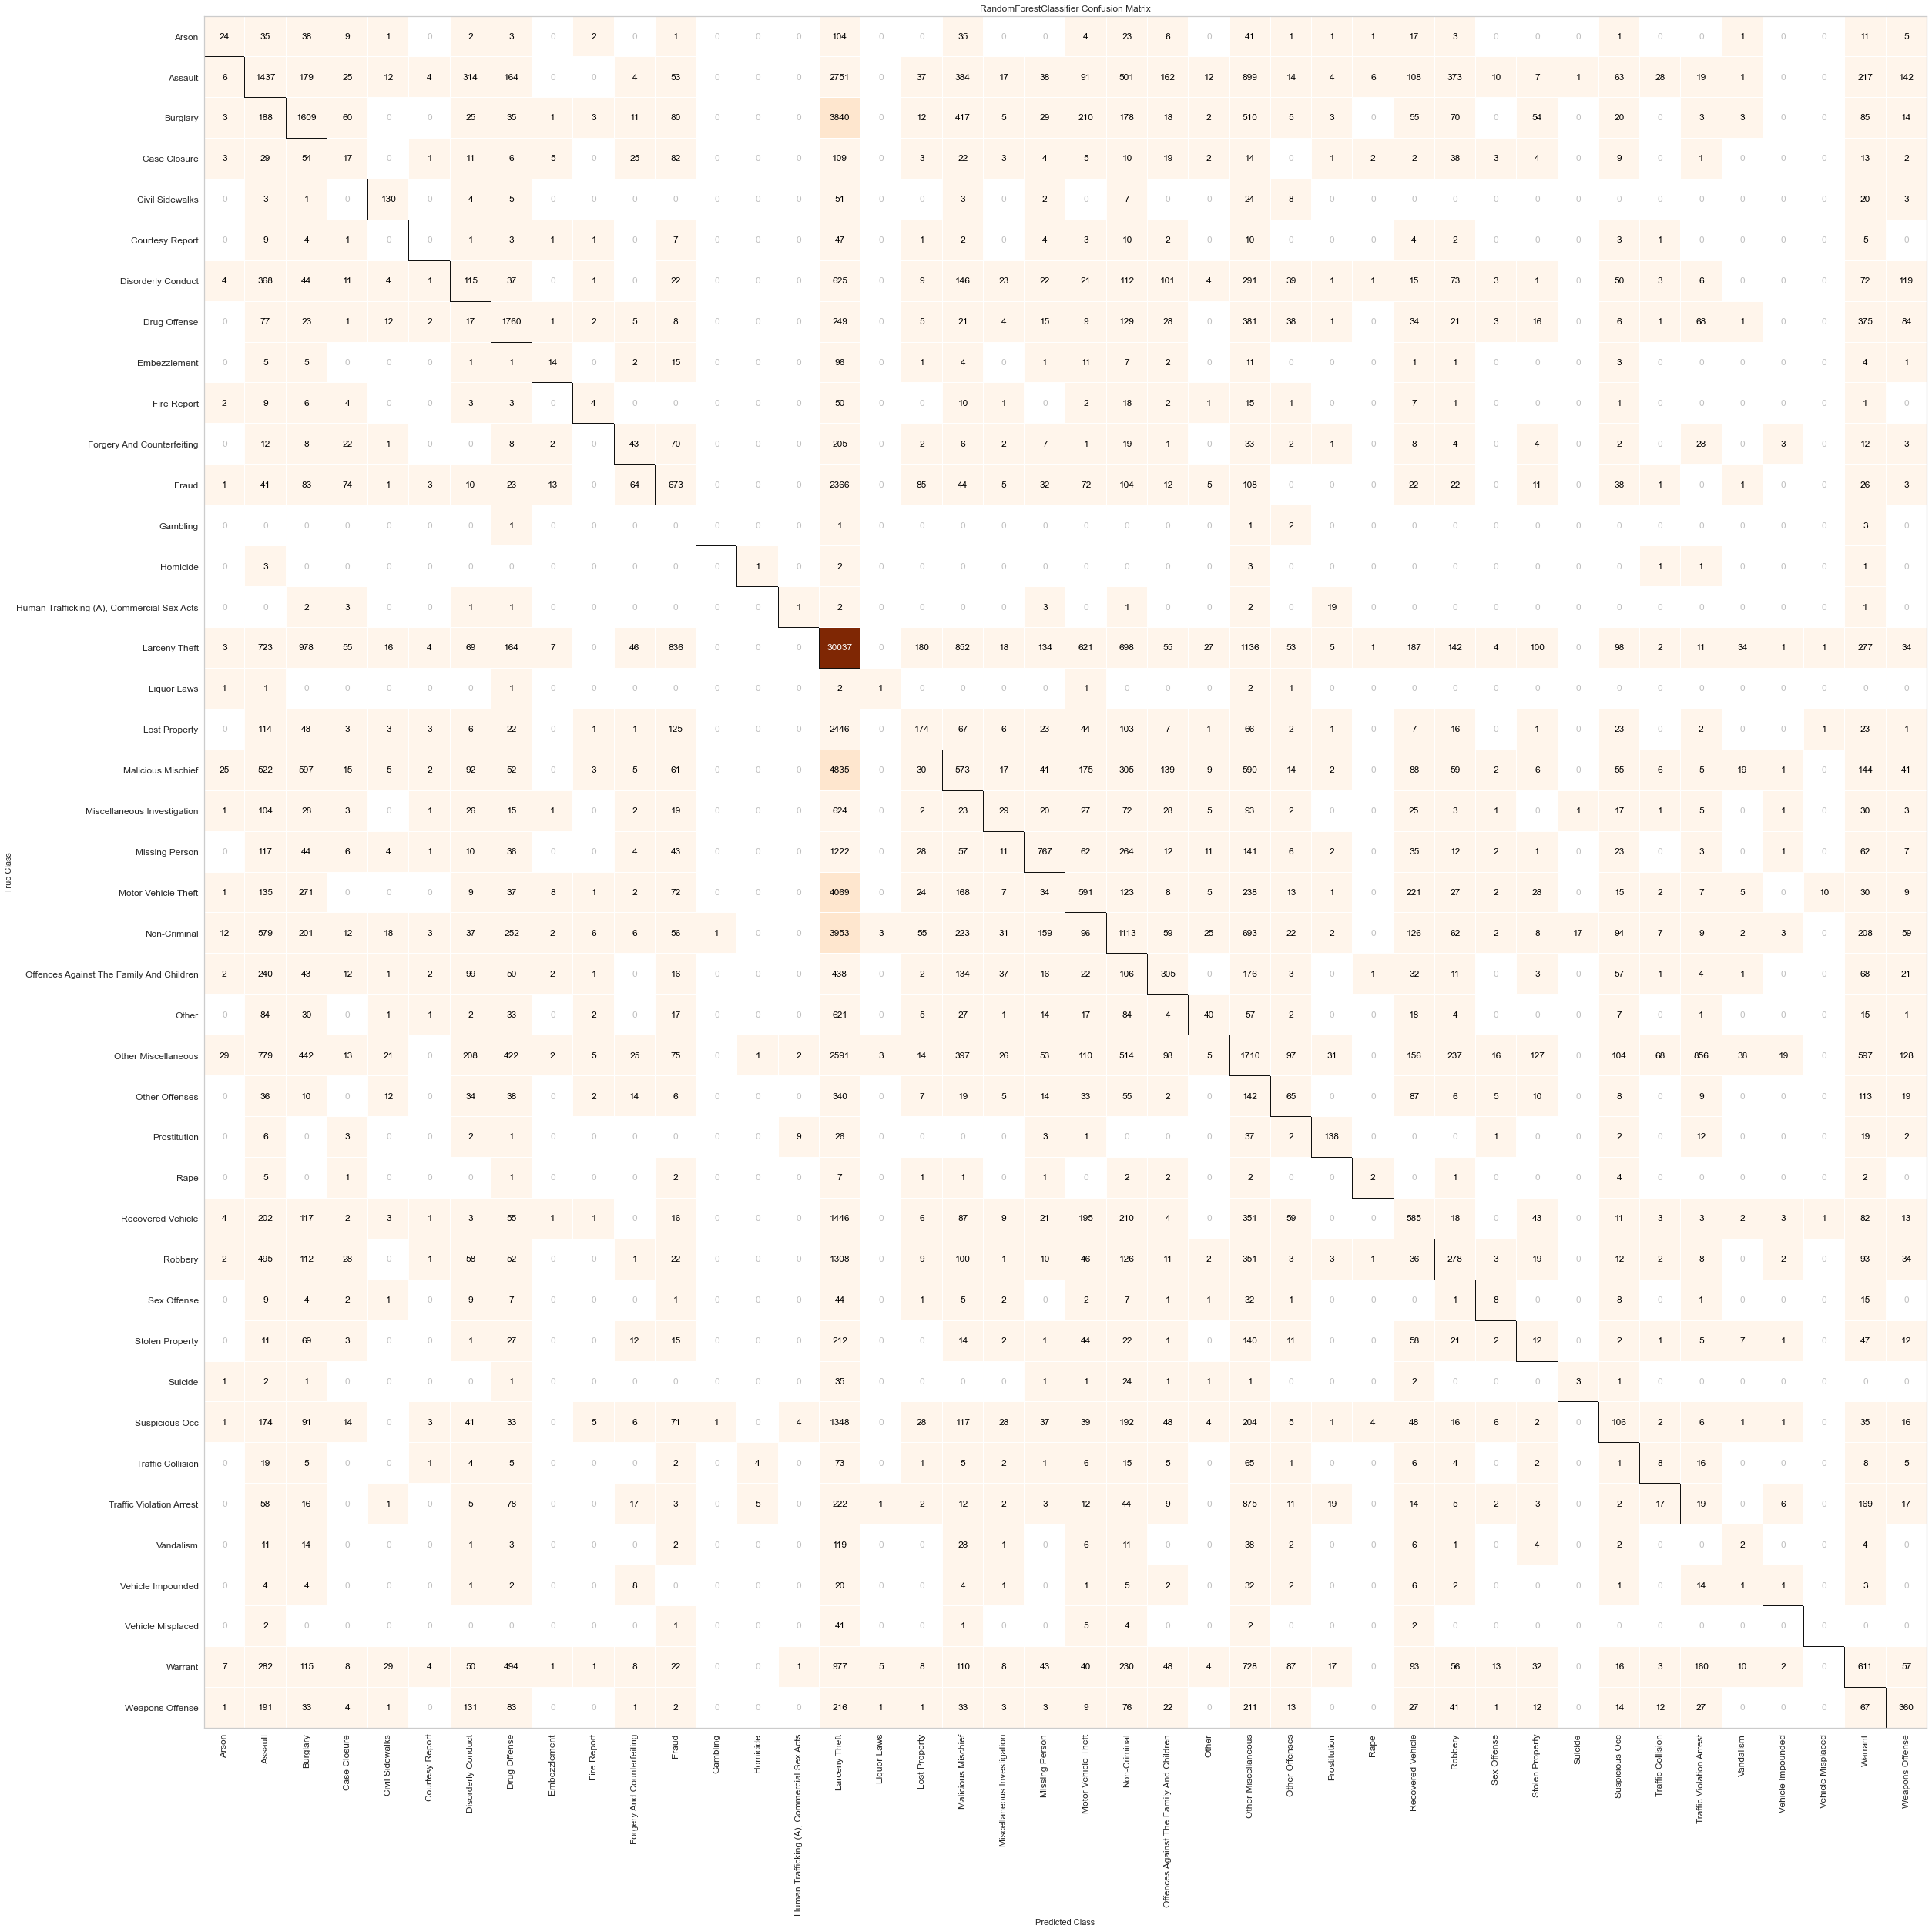

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [176]:
fig = plt.figure(figsize=(35,35))

confusion_RFC_cm = ConfusionMatrix(
    model, cmap="Oranges"
)

confusion_RFC_cm.fit(x_train, y_train)
confusion_RFC_cm.score(x_test, y_test)
#confusion_RFC_cm.show(outpath="png_prod\\RFC_BaseRun_003_ConfusionMatrix.png")
confusion_RFC_cm.show()

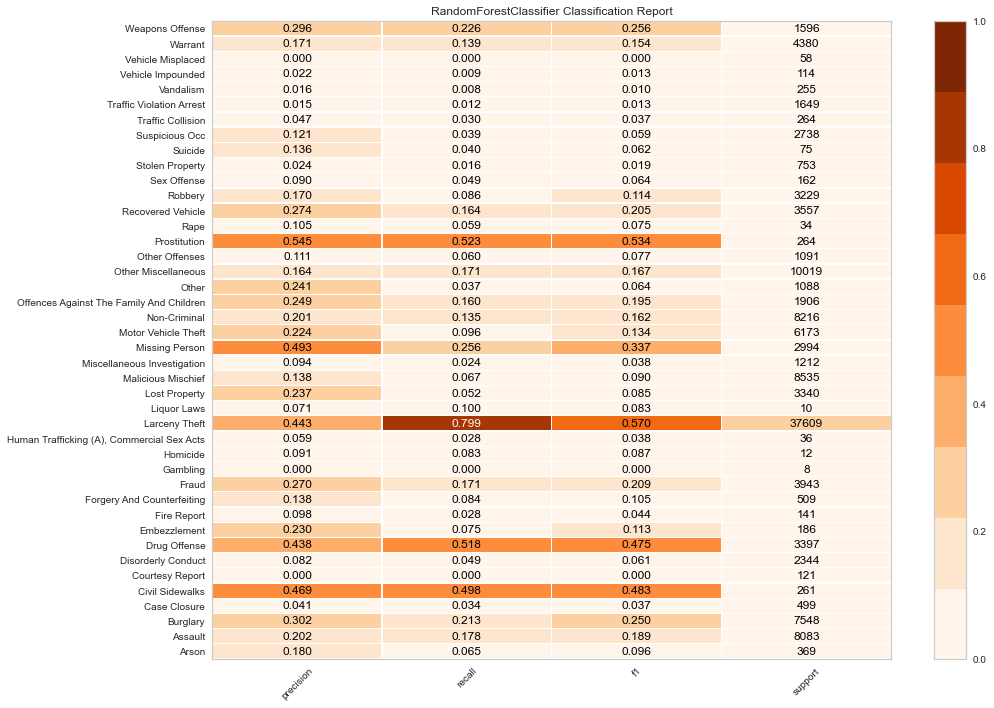

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [177]:
plt.figure(figsize=(15,10))

visualizer = ClassificationReport(model, support=True,cmap='Oranges')

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
#visualizer.show(outpath="png_prod\\RFC_BaseRun_001_ClassificationReport_001.png")
visualizer.show()                       # Finalize and show the figure

<AxesSubplot:title={'center':'RFC Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

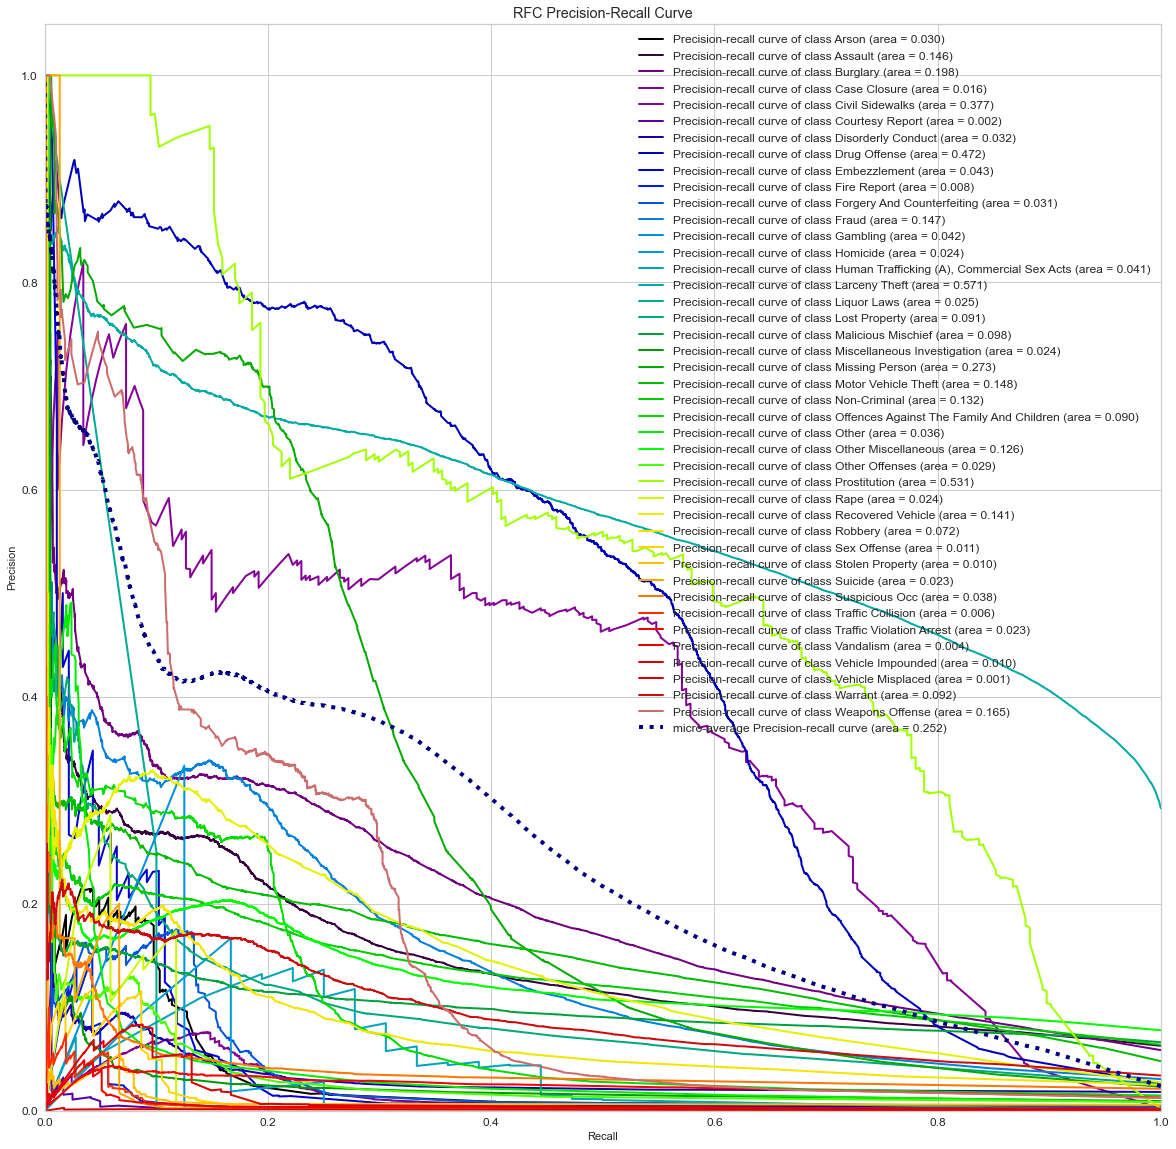

In [178]:
Y_test_probs = model.predict_proba(x_test)
skplt.metrics.plot_precision_recall(y_test, Y_test_probs,
                       title="RFC Precision-Recall Curve", figsize=(20,20))

#plt.savefig('png_prod\\RFC_BaseRun_002_PRCurve_002.png')

In [ ]:
#SCIKITPLOT plot the confusion matrix for multiclass
#for this we used the yellowbrick version because it orients the x-y labels correctly 

## import scikitplot as skplt
## cmplot = skplt.metrics.plot_confusion_matrix(y_test, y_pred,
##                                    title="Confusion Matrix",
##                                    cmap="Purples",figsize=(35,35) )

## print ( type (cmplot  ) )
## cmplot.tick_params(labelrotation=90)
## plt.show()

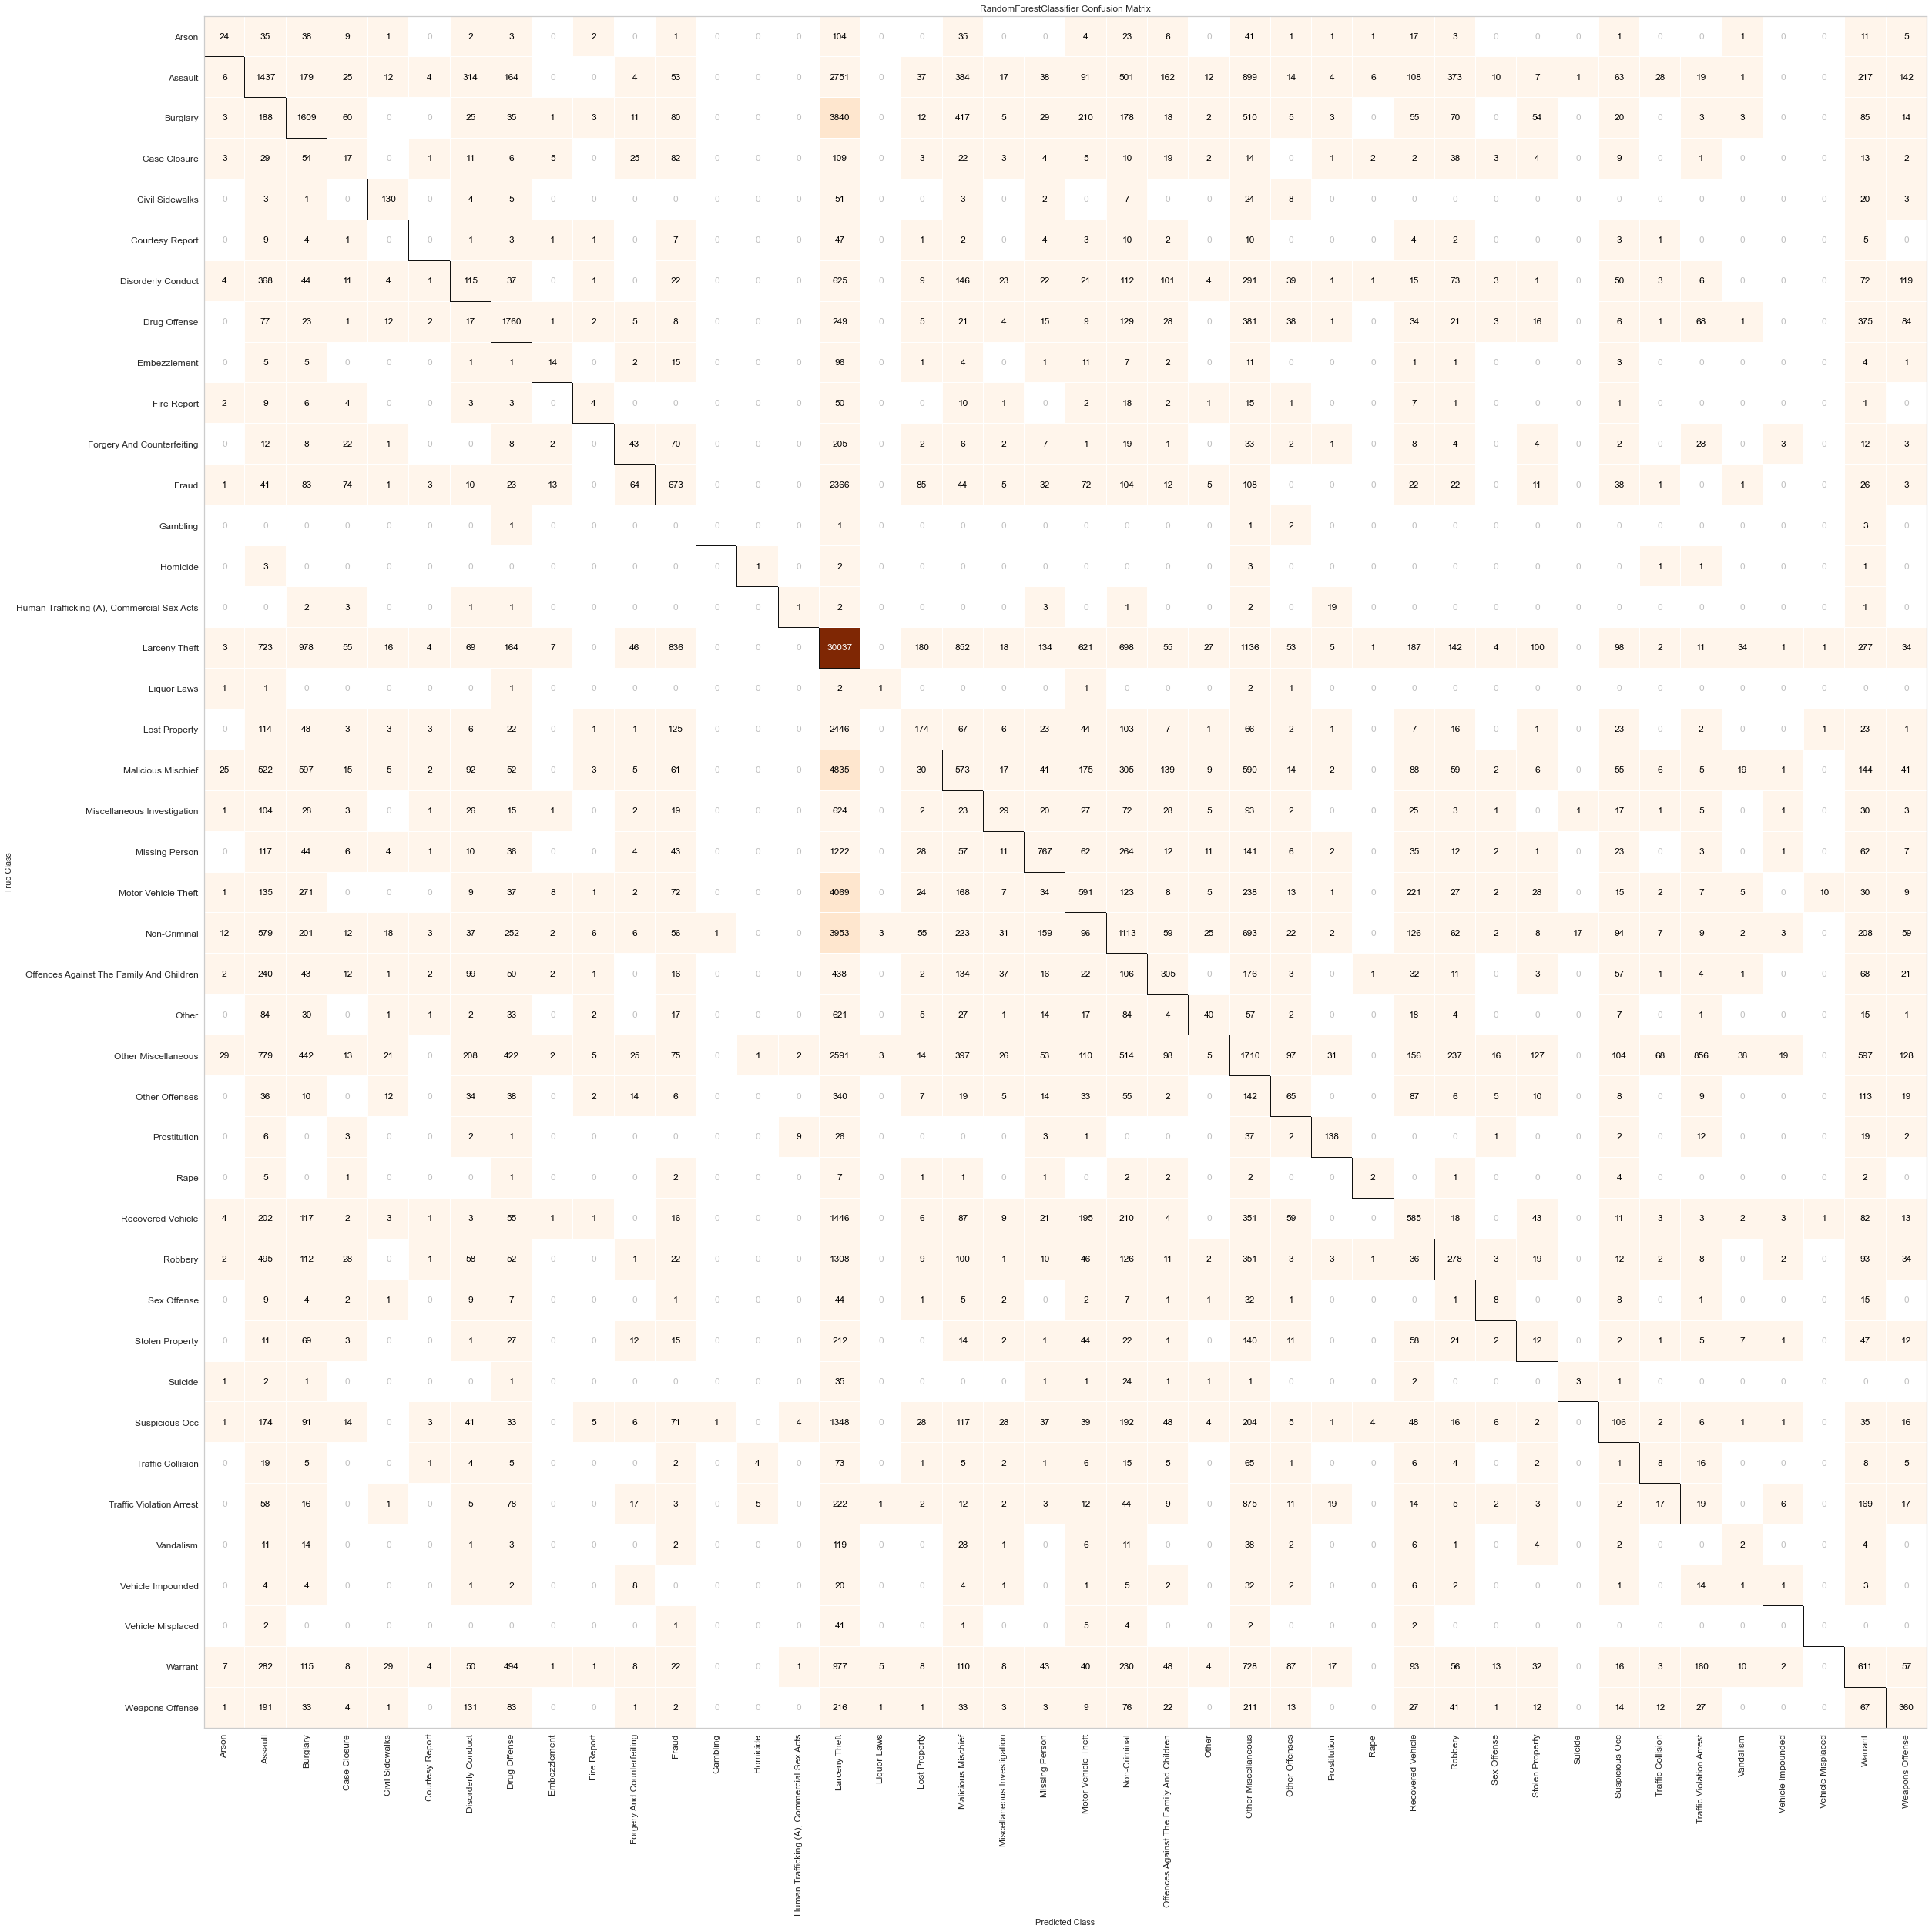

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [179]:
fig = plt.figure(figsize=(35,35))

confusion_RFC_cm = ConfusionMatrix(
    model, cmap="Oranges"
)

confusion_RFC_cm.fit(x_train, y_train)
confusion_RFC_cm.score(x_test, y_test)
#confusion_RFC_cm.show(outpath="png_prod\\RFC_BaseRun_003_ConfusionMatrix.png")
confusion_RFC_cm.show()



<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

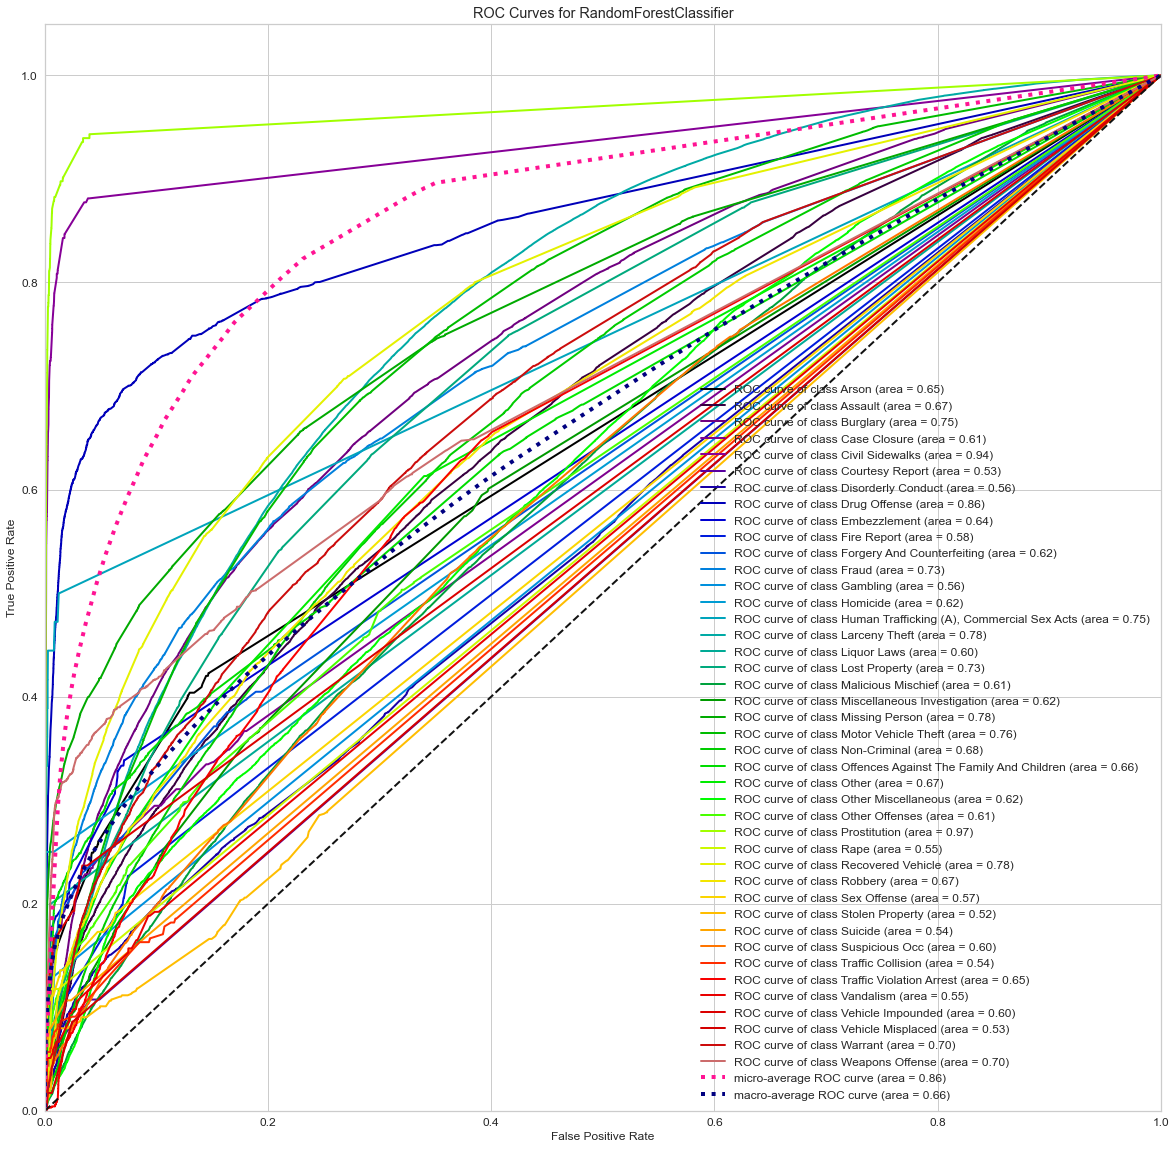

In [180]:
#plt.figure(figsize=(20,20))
#plot using sckitplot 
Y_test_probs = model.predict_proba(x_test)

skplt.metrics.plot_roc(y_test, Y_test_probs,
                       title="ROC Curves for RandomForestClassifier", figsize=(20,20))
#plt.savefig('png_prod\\RFC_BaseRun_004_ROCCurve.png')

In [ ]:
#plot the AUC per class
#YELLOWBRICK04

In [ ]:
# for this we use the sckitplot version as it's easier to see different classes 
# plt.figure(figsize=(20,20))

# DONOTUSETHIS - visualizer = ROCAUC(model, classes=model.classes_)
# visualizer = ROCAUC(model, colormap="Set1") #Set1 #use this 
# visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
# visualizer.score(x_test, y_test)        # Evaluate the model on the test data
# visualizer.show()  

In [ ]:
#we can use this to see which has more errors, however due to to many classes, this is not easy to read 
#this is useful for other types of cases 

# from yellowbrick.classifier import class_prediction_error
# fig = plt.figure(figsize=(35,35))

# class_prediction_error(
#   model ,
#   x_train, y_train, x_test, y_test,
#    colormap="Set1"
#)

In [ ]:
print(model.get_params())

[Optional] : AUC Curve <br/>
https://sinyi-chou.github.io/classification-auc/

[Optional] : Relationship of AUC & PR <br/>
https://sinyi-chou.github.io/classification-pr-curve/ <br/>
https://www.datascienceblog.net/post/machine-learning/interpreting-roc-curves-auc/ <br/>
https://www.geeksforgeeks.org/precision-recall-curve-ml/ <br/>
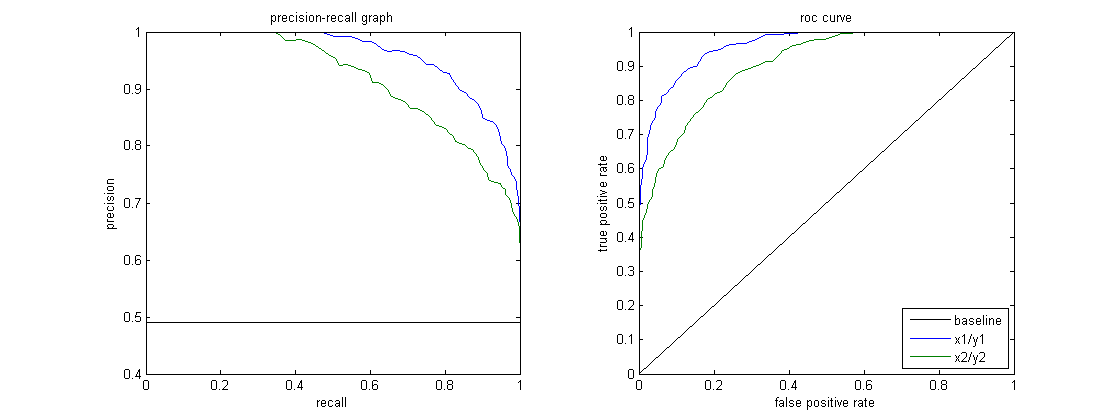 <br/>
Reference : https://sinyi-chou.github.io/classification-pr-curve/  <br/>

The PR curve focuses on the minority class, whereas the ROC curve covers both classes. <br/>
Reference: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

### Obsevation : The accuracy from a base model RFC is at  33.68 and F1 is around  28.51. 
### And we see that a few classes are ending ip with 0.0 precision and 0.0 recall
### We can check on the ClassBalance of training & test set 


-----print out distribution of y_train and y_test before dropping any columns... 


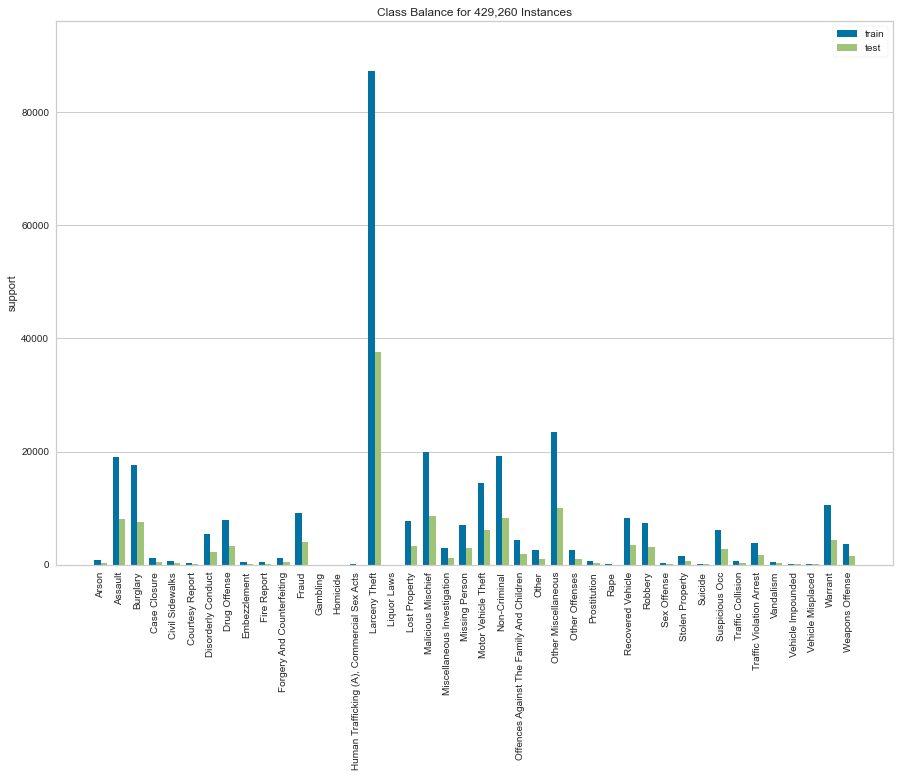

<AxesSubplot:title={'center':'Class Balance for 429,260 Instances'}, ylabel='support'>

In [181]:
print ('-----print out distribution of y_train and y_test before dropping any columns... ')

plt.figure(figsize=(15,10))

visualizer = ClassBalance( )
plt.xticks(rotation=90, ha='center')

visualizer.fit(y_train, y_test)        # Fit the data to the visualizer

#visualizer.show(outpath="png_prod\\RFC_BaseRun_005_ClassBalance.png")

visualizer.show()                      # Finalize and render the figure

In [ ]:
# sf_input.info()

In [182]:
feature_labels = features_selected05 
importance = model.feature_importances_

# Sort the feature labels based on the feature importance rankings from the model (smallest to largest )
feature_indexes_by_importance = model.feature_importances_.argsort()
feature_indexes_by_importance_reversed = feature_indexes_by_importance [::-1] ##reverse the array reverse 
for index in feature_indexes_by_importance_reversed:
    print("{} - {:.2f}%".format(feature_labels[index], (importance[index] * 100.0)))


Latitude - 15.06%
Incident_Datetime_DayOfMonth - 14.87%
Longitude - 14.71%
Incident_Datetime_HrOfDay - 13.09%
Incident_Date_Month - 11.81%
Incident_Datetime_Minute - 11.14%
Incident_Date_dayofweek_num - 9.53%
Incident_Year - 4.60%
CrimeCounts_By_AnalysisNghrBood - 3.20%
PD_is_Tenderloin - 0.27%
PD_is_Northern - 0.27%
PD_is_Central - 0.26%
PD_is_Southern - 0.24%
PD_is_Mission - 0.20%
PD_is_Ingleside - 0.17%
PD_is_Bayview - 0.15%
PD_is_Richmond - 0.15%
PD_is_Park - 0.14%
PD_is_Taraval - 0.13%


### Visual of feature importance after RFC 

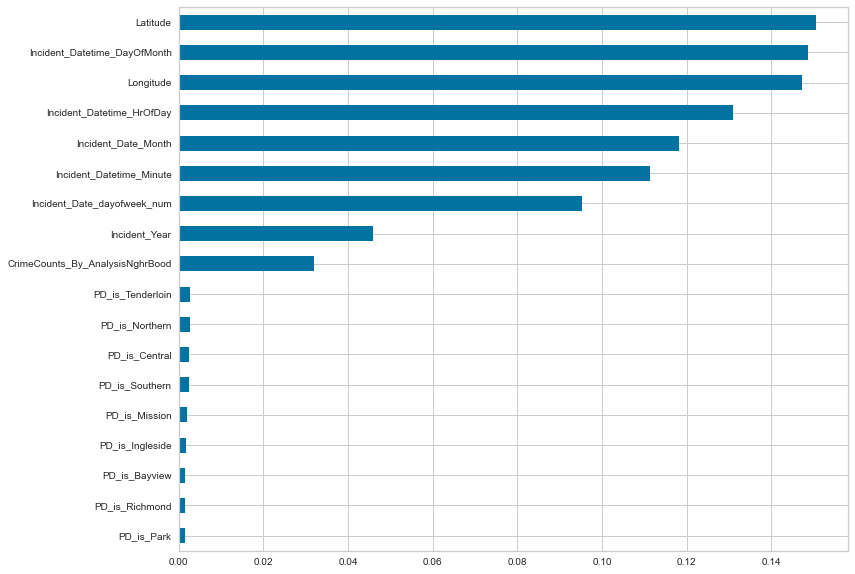

In [183]:
plt.figure(figsize=(12,10))
feat_importances = pd.Series(model.feature_importances_, index=feature_labels)
plotBar = feat_importances.nlargest(18).plot(kind='barh')
#handles, labels = axis.get_legend_handles_labels()
# reverse to keep order consistent
plotBar.invert_yaxis()

In [ ]:
#CLASSIFCATIONERRORS 

In [184]:
clearMemory_callGC()

<Figure size 576x396 with 0 Axes>

### 5.2.1 Running Base with class_weight = Balanced 

In [185]:
#BRIEF RANDOMFOREST class_weight = Balanced 
#'Incident_Datetime' = 'Incident_Year' + 'Incident_Date_Month' + Incident_Datetime_DayOfMonth + Incident_Datetime_HrOfDay + Incident_Datetime_Minute 
features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'Latitude', 'Longitude','CrimeCounts_By_AnalysisNghrBood']


x = sf_input[features_selected05] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

#the above will translate to this in .values.ravel()
#y = sf_input.loc[ :, ['Incident_Category'] ] # Target variable
#y = y.values.ravel()

#print (y.shape)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test

model = RandomForestClassifier (random_state=88, class_weight ='balanced')
# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)

f1_score_01 = f1_score(y_test, y_pred,average='weighted')*100
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('------------ [RFC Tree with class_weight = Balanced ]------------')
print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 
print ('No of Classes in Y--> %d' %(len(model.classes_)))

print('------------End [RFC Tree with class_weight = Balanced ]------------')


print(classification_report(y_test, y_pred,zero_division=0))

------------ [RFC Tree with class_weight = Balanced ]------------
Accuracy: 33.41
f1_score: 27.71
Precision :27.48
Recall :33.41
ROC_AUC SCORE :65.42
No of Classes in Y--> 42
------------End [RFC Tree with class_weight = Balanced ]------------
                                            precision    recall  f1-score   support

                                     Arson       0.19      0.08      0.12       369
                                   Assault       0.20      0.16      0.18      8083
                                  Burglary       0.30      0.19      0.23      7548
                              Case Closure       0.07      0.11      0.09       499
                           Civil Sidewalks       0.46      0.51      0.48       261
                           Courtesy Report       0.02      0.01      0.01       121
                        Disorderly Conduct       0.08      0.05      0.06      2344
                              Drug Offense       0.43      0.54      0.48      3397

<AxesSubplot:title={'center':'RFC Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

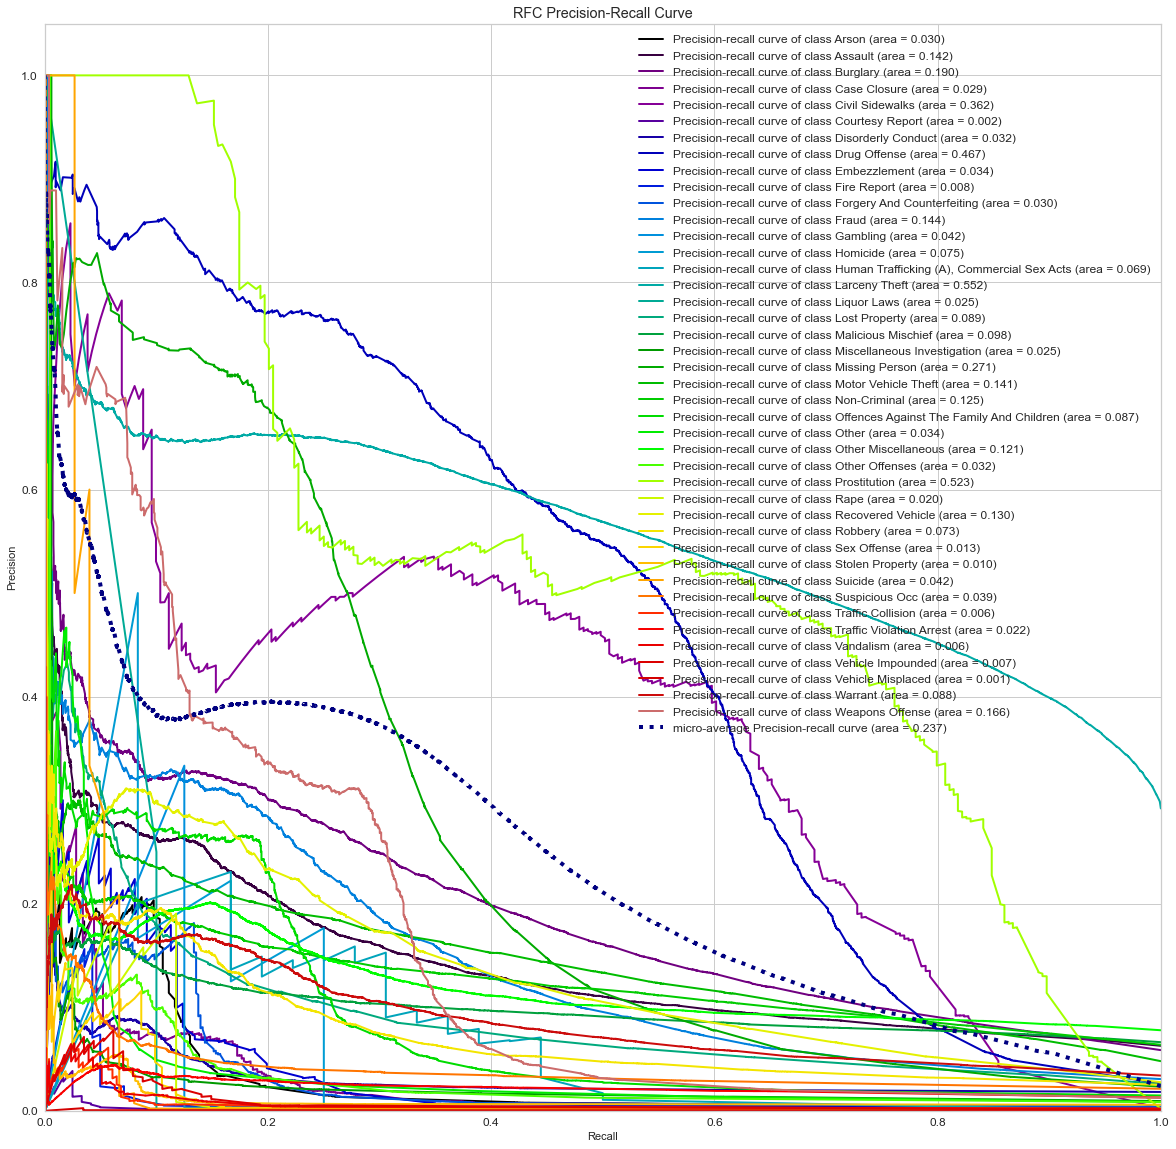

In [186]:
Y_test_probs = model.predict_proba(x_test)
skplt.metrics.plot_precision_recall(y_test, Y_test_probs,
                       title="RFC Precision-Recall Curve", figsize=(20,20))

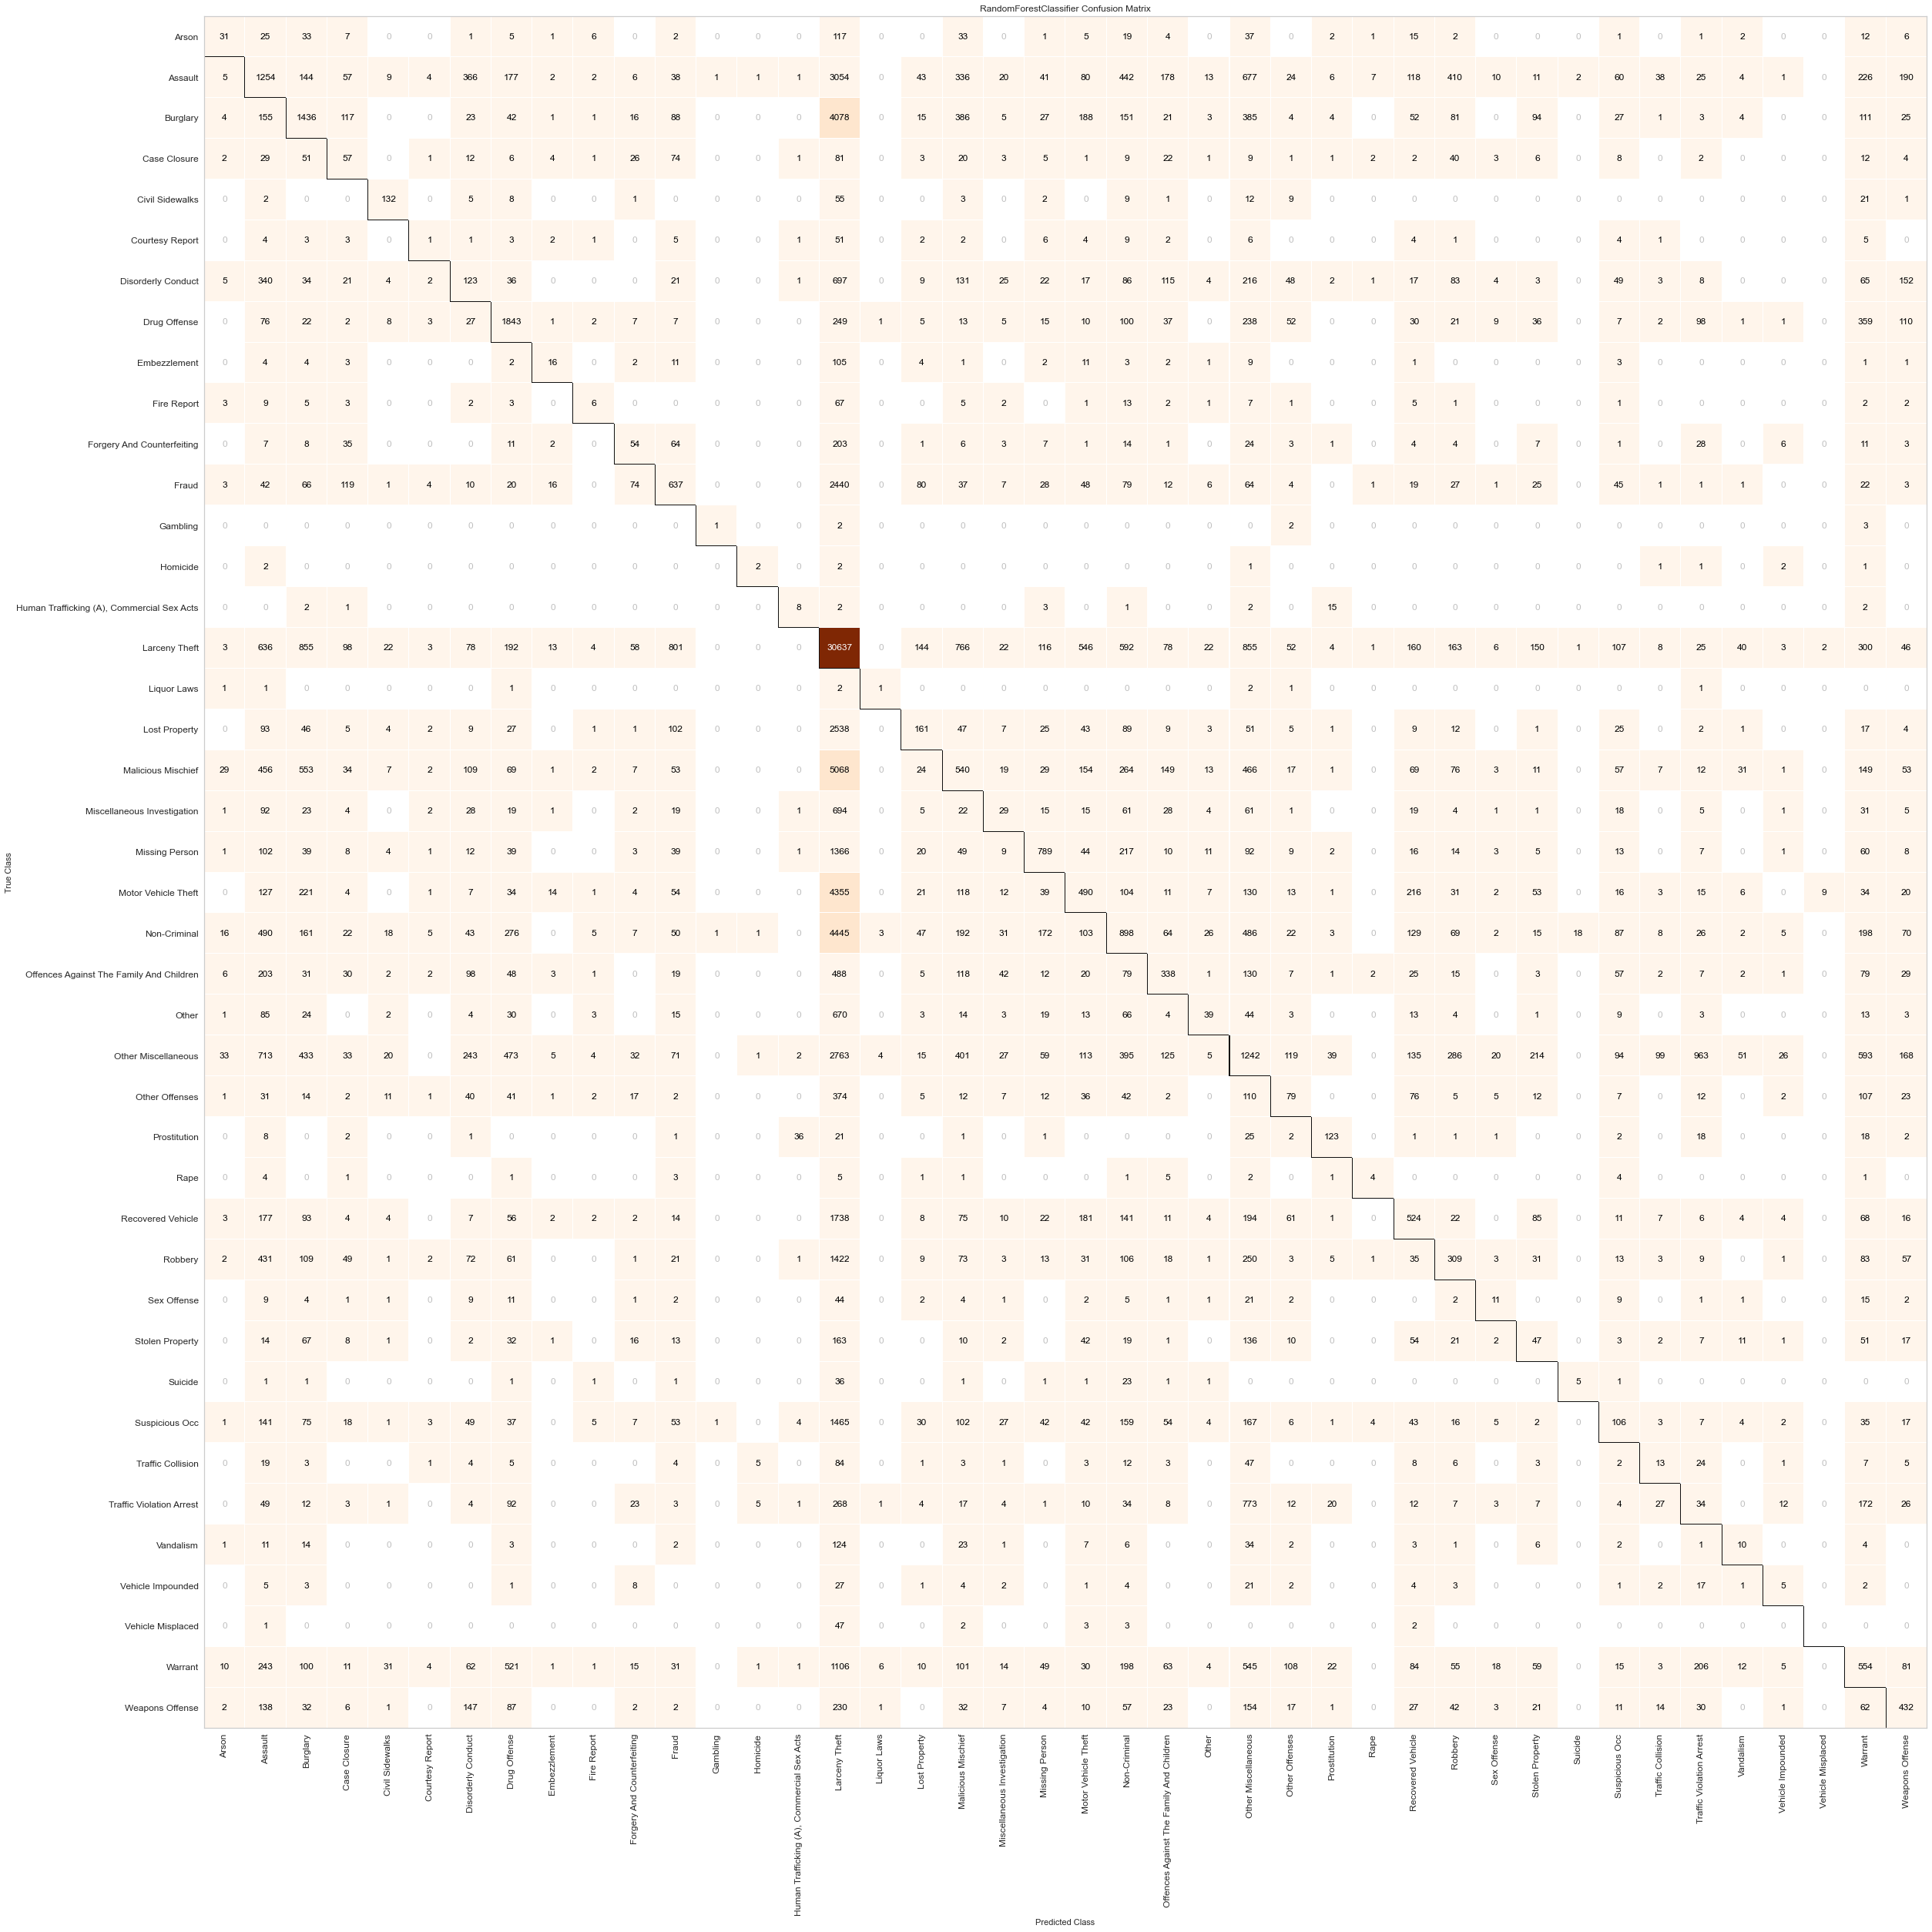

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [187]:
fig = plt.figure(figsize=(35,35))

confusion_RFC_cm = ConfusionMatrix(
    model, cmap="Oranges"
)

confusion_RFC_cm.fit(x_train, y_train)
confusion_RFC_cm.score(x_test, y_test)
confusion_RFC_cm.show()

In [ ]:
#End Running Base with class_weight = Balanced 

### 5.2.2 Running Base with class_weight using TRAIN SET 

In [188]:
#Start Calculate the weights in the training set only and use ths as class_wights 

features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'Latitude', 'Longitude','CrimeCounts_By_AnalysisNghrBood']


x = sf_input[features_selected05] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

#the above will translate to this in .values.ravel()
#y = sf_input.loc[ :, ['Incident_Category'] ] # Target variable
#y = y.values.ravel()

#print (y.shape)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test

classes_TRAIN = np.unique(y_train)
class_weights_train = compute_class_weight('balanced', classes = classes_TRAIN , y = np.ravel(y_train))

zip_iterator = zip(classes_TRAIN, class_weights_train )
a_dictionary_TRAIN = dict(zip_iterator)
#debug the class_weights_train if needed
#print ( a_dictionary_TRAIN ) 

In [189]:

model = RandomForestClassifier (random_state=88, class_weight=a_dictionary_TRAIN)
# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)


accuracy_score_01 = accuracy_score(y_test, y_pred)*100
f1_score_01 = f1_score(y_test, y_pred,average='weighted')*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 ##try change to micro ,average='micro'
# macro = Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
#weighted = takes in the imbalance in classes 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('------------ [RFC Tree with class_weight = Calc Train Weights Only ]------------')
print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 

print ('No of Classes in Y--> %d' %(len(model.classes_)))
print('------------ End [RFC Tree with class_weight = Calc Train Weights Only ]------------')
print(classification_report(y_test, y_pred,zero_division=0))

------------ [RFC Tree with class_weight = Calc Train Weights Only ]------------
Accuracy: 33.41
f1_score: 27.71
Precision :27.48
Recall :33.41
ROC_AUC SCORE :65.42
No of Classes in Y--> 42
------------ End [RFC Tree with class_weight = Calc Train Weights Only ]------------
                                            precision    recall  f1-score   support

                                     Arson       0.19      0.08      0.12       369
                                   Assault       0.20      0.16      0.18      8083
                                  Burglary       0.30      0.19      0.23      7548
                              Case Closure       0.07      0.11      0.09       499
                           Civil Sidewalks       0.46      0.51      0.48       261
                           Courtesy Report       0.02      0.01      0.01       121
                        Disorderly Conduct       0.08      0.05      0.06      2344
                              Drug Offense       0.4

In [ ]:
###End Running Base with class_weight using TRAIN SET 

### 5.2.3 Create weights by smoothen weight method 

In [ ]:
## call the whole procedure again 

In [190]:
features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'Latitude', 'Longitude','CrimeCounts_By_AnalysisNghrBood']


x = sf_input[features_selected05] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

#the above will translate to this in .values.ravel()
#y = sf_input.loc[ :, ['Incident_Category'] ] # Target variable
#y = y.values.ravel()

#print (y.shape)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test

print ('--initializing smoothen weights---' )

smoothen_weights_dict = create_class_weight02 ( y_train ) 
#print ( smoothen_weights_dict ) 
print ('--End initializing smoothen weights---' )


model = RandomForestClassifier (random_state=88, class_weight=smoothen_weights_dict)
# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)


accuracy_score_01 = accuracy_score(y_test, y_pred)*100
f1_score_01 = f1_score(y_test, y_pred,average='weighted')*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 ##try change to micro ,average='micro'
# macro = Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
#weighted = takes in the imbalance in classes 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('------------ [RFC Tree with class_weight = Calc Smoothen Weights ]------------')
print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 

print ('No of Classes in Y--> %d' %(len(model.classes_)))
print('------------ End [RFC Tree with class_weight = Calc Smoothen Weights Only ]------------')
print(classification_report(y_test, y_pred,zero_division=0))

--initializing smoothen weights---
--End initializing smoothen weights---
------------ [RFC Tree with class_weight = Calc Smoothen Weights ]------------
Accuracy: 33.57
f1_score: 28.35
Precision :27.86
Recall :33.57
ROC_AUC SCORE :65.95
No of Classes in Y--> 42
------------ End [RFC Tree with class_weight = Calc Smoothen Weights Only ]------------
                                            precision    recall  f1-score   support

                                     Arson       0.17      0.08      0.11       369
                                   Assault       0.20      0.16      0.18      8083
                                  Burglary       0.30      0.21      0.25      7548
                              Case Closure       0.06      0.08      0.07       499
                           Civil Sidewalks       0.43      0.50      0.46       261
                           Courtesy Report       0.02      0.01      0.01       121
                        Disorderly Conduct       0.08      0.

In [191]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': {'Assault': 1.0,
  'Fraud': 1.5976884199308834,
  'Burglary': 1.0,
  'Malicious Mischief': 1.0,
  'Larceny Theft': 1.0,
  'Lost Property': 1.7524788541142975,
  'Robbery': 1.8053024841596832,
  'Other Miscellaneous': 1.0,
  'Non-Criminal': 1.0,
  'Stolen Property': 3.336390993501489,
  'Disorderly Conduct': 2.125951309282232,
  'Other': 2.87217450795857,
  'Missing Person': 1.862072044596431,
  'Drug Offense': 1.7433056467139032,
  'Motor Vehicle Theft': 1.1422904424486024,
  'Traffic Collision': 4.189528286540252,
  'Weapons Offense': 2.508893978039716,
  'Suspicious Occ': 1.979212613157153,
  'Recovered Vehicle': 1.6856471113551357,
  'Traffic Violation Arrest': 2.4503729805307124,
  'Sex Offense': 4.843905356635626,
  'Warrant': 1.4529954518558528,
  'Fire Report': 4.6662896908790845,
  'Case Closure': 3.629285211600465,
  'Offences Against The Family And Children': 2.3259817403552883,
  'Vandalism': 4.372142711984711,
  'Embez

In [ ]:
###Create weights by smoothen weight method 

### 5.2.4 [Optional] Use PYCM To get to a recommended matrix of measures for imbalanced classes

In [ ]:
from pycm import ConfusionMatrix as pycm_ConfusionMatrix

In [ ]:
cm = pycm_ConfusionMatrix(actual_vector=y_test.to_numpy(), predict_vector=y_pred) # Create CM From Data

In [ ]:
#cm.classes

In [ ]:
## print (cm)

In [ ]:
print(cm.recommended_list)

### [Optional] [End] Use PYCM To get to a recommended matrix for imbalanced classes

### But for this project, I elect to choose F1,  Classification Report, ConfusionMatrix as a metric for easier assessment
### (b) Using RFC , class_weight = 'balanced' & calc_weight_on_train or smoothen_weight_formula does not seem to help the situation either 

### 5.3 We can create a IsWeekDay field to see if this improves the situation 
### 5.3 IsWeekDay = 1 (for a weekday) and 0 if it is a WeekEnd

In [192]:
## 117783 / 429260 occurs on a weekend (Sat / Sun ) 
count_of_weekendRecords = len ( sf_input [ (sf_input ['Incident_Date_dayofweek_num'] == 5) |  (sf_input ['Incident_Date_dayofweek_num'] == 6) ] ) 
#sf_input ['IsWeekend'] = 1 
#count_of_weekendRecords
count_of_weekDays = len ( sf_input ) - count_of_weekendRecords
print ( "WeekDays Incidents [ %d ] WeekEnd Incidents [ %d ]  " %(count_of_weekDays,count_of_weekendRecords ) )

WeekDays Incidents [ 311477 ] WeekEnd Incidents [ 117783 ]  


In [193]:
sf_input ['IsWeekDay'] = 1 #we set is weekend = 0 , 1 = weekdays 
#sf_input.head(10)
#mask to chceck ifthe day is weekend 
mask_matchWeekEnds = ((sf_input ['Incident_Date_dayofweek_num'] == 5) |  (sf_input ['Incident_Date_dayofweek_num'] == 6))
#sf_input.loc [ mask_matchWeekEnds ] 
sf_input.loc[( mask_matchWeekEnds ), ['IsWeekDay' ]] =  0

In [194]:
#'Incident_Datetime' = 'Incident_Year' + 'Incident_Date_Month' + Incident_Datetime_DayOfMonth + Incident_Datetime_HrOfDay + Incident_Datetime_Minute 
#AddIsWeekend
features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'IsWeekDay',
                   'Latitude', 'Longitude', 'CrimeCounts_By_AnalysisNghrBood' ]


x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

#the above will translate to this in .values.ravel()
#y = sf_input.loc[ :, ['Incident_Category'] ] # Target variable
#y = y.values.ravel()

#print (y.shape)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test

model = RandomForestClassifier (random_state=88)
# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)

f1_score_01 = f1_score(y_test, y_pred,average='weighted')*100
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 
print ('No of Classes in Y--> %d' %(len(model.classes_)))


print(classification_report(y_test, y_pred,zero_division=0))

Accuracy: 33.54
f1_score: 28.36
Precision :27.89
Recall :33.54
ROC_AUC SCORE :65.65
No of Classes in Y--> 42
                                            precision    recall  f1-score   support

                                     Arson       0.17      0.06      0.09       369
                                   Assault       0.20      0.17      0.19      8083
                                  Burglary       0.30      0.21      0.25      7548
                              Case Closure       0.04      0.03      0.04       499
                           Civil Sidewalks       0.48      0.48      0.48       261
                           Courtesy Report       0.03      0.01      0.01       121
                        Disorderly Conduct       0.08      0.05      0.06      2344
                              Drug Offense       0.44      0.52      0.47      3397
                              Embezzlement       0.24      0.08      0.11       186
                               Fire Report       0

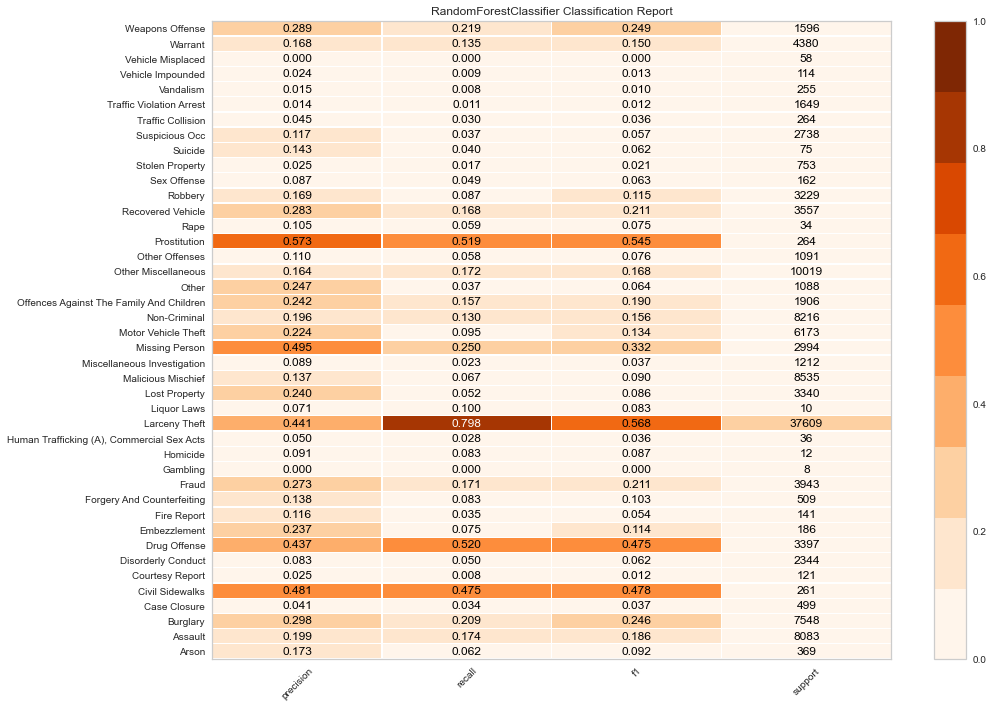

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [195]:
plt.figure(figsize=(15,10))

visualizer = ClassificationReport(model, support=True, cmap='Oranges' )

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

However, the score (F1) did not improve upon adding the [IsWeekDay] field. So it is not needed to include this field 
Now we can consider dropping those classes that have little/no precision.
So far, these are the incident categories identified 


|                         Incident Category|
|:----------------------------------------:|
|                              Case Closure|
|                           Courtesy Report|
|                                  Gambling|
|Human Trafficking (A), Commercial Sex Acts|
|                               Liquor Laws|
|                           Stolen Property|
|                         Traffic Collision|
|                  Traffic Violation Arrest|
|                                 Vandalism|
|                         Vehicle Impounded|
|                         Vehicle Misplaced|


In [196]:
columns_to_drop = ['IsWeekDay' ]
sf_input.drop(columns=columns_to_drop, inplace=True )

In [197]:
def dropCategory ( incomingListOfDroppedCategories):
    for i in incomingListOfDroppedCategories:
        print ("dropping>", i )
        sf_input.drop ( sf_input[ sf_input ['Incident_Category'] == i].index, inplace=True ) 
        print ("dropping done>", i )
    #reindex the df
    #resets the index on the df 
    sf_input.reset_index(drop=True, inplace=True) #resets the index

In [198]:
dropCategory ( [ 'Case Closure', 'Courtesy Report', 'Gambling', 
               'Human Trafficking (A), Commercial Sex Acts', 
               'Liquor Laws', 'Stolen Property', 'Traffic Collision', 
               'Traffic Violation Arrest', 'Vandalism', 
               'Vehicle Impounded', 'Vehicle Misplaced'  ] )                   

dropping> Case Closure
dropping done> Case Closure
dropping> Courtesy Report
dropping done> Courtesy Report
dropping> Gambling
dropping done> Gambling
dropping> Human Trafficking (A), Commercial Sex Acts
dropping done> Human Trafficking (A), Commercial Sex Acts
dropping> Liquor Laws
dropping done> Liquor Laws
dropping> Stolen Property
dropping done> Stolen Property
dropping> Traffic Collision
dropping done> Traffic Collision
dropping> Traffic Violation Arrest
dropping done> Traffic Violation Arrest
dropping> Vandalism
dropping done> Vandalism
dropping> Vehicle Impounded
dropping done> Vehicle Impounded
dropping> Vehicle Misplaced
dropping done> Vehicle Misplaced


In [199]:
sf_input['Incident_Category'].unique()

array(['Arson', 'Larceny Theft', 'Missing Person', 'Drug Offense',
       'Fraud', 'Non-Criminal', 'Other Miscellaneous', 'Burglary',
       'Suspicious Occ', 'Motor Vehicle Theft', 'Lost Property',
       'Malicious Mischief', 'Assault',
       'Offences Against The Family And Children', 'Warrant',
       'Disorderly Conduct', 'Recovered Vehicle', 'Robbery',
       'Forgery And Counterfeiting', 'Civil Sidewalks', 'Other',
       'Miscellaneous Investigation', 'Other Offenses', 'Prostitution',
       'Weapons Offense', 'Fire Report', 'Embezzlement', 'Sex Offense',
       'Suicide', 'Homicide', 'Rape'], dtype=object)

### 5.4 Re-run RFC with lesser classes

In [ ]:
#rerun RFC again with lesser classes 

In [200]:
#'Incident_Datetime' = 'Incident_Year' + 'Incident_Date_Month' + Incident_Datetime_DayOfMonth + Incident_Datetime_HrOfDay + Incident_Datetime_Minute 

features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin',
                   'Latitude', 'Longitude', 'CrimeCounts_By_AnalysisNghrBood' ]



x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

#the above will translate to this in .values.ravel()
#y = sf_input.loc[ :, ['Incident_Category'] ] # Target variable
#y = y.values.ravel()

#print (y.shape)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test

model = RandomForestClassifier (random_state=88)
# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)

f1_score_01 = f1_score(y_test, y_pred,average='weighted')*100
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 
print ('No of Classes in Y--> %d' %(len(model.classes_)))


print(classification_report(y_test, y_pred,zero_division=0))

Accuracy: 34.92
f1_score: 29.78
Precision :29.42
Recall :34.92
ROC_AUC SCORE :68.36
No of Classes in Y--> 31
                                          precision    recall  f1-score   support

                                   Arson       0.20      0.08      0.11       379
                                 Assault       0.20      0.18      0.19      8166
                                Burglary       0.30      0.21      0.25      7613
                         Civil Sidewalks       0.44      0.48      0.46       262
                      Disorderly Conduct       0.08      0.05      0.06      2373
                            Drug Offense       0.46      0.53      0.49      3438
                            Embezzlement       0.18      0.06      0.09       184
                             Fire Report       0.10      0.02      0.04       171
              Forgery And Counterfeiting       0.27      0.12      0.17       546
                                   Fraud       0.30      0.18      0.2

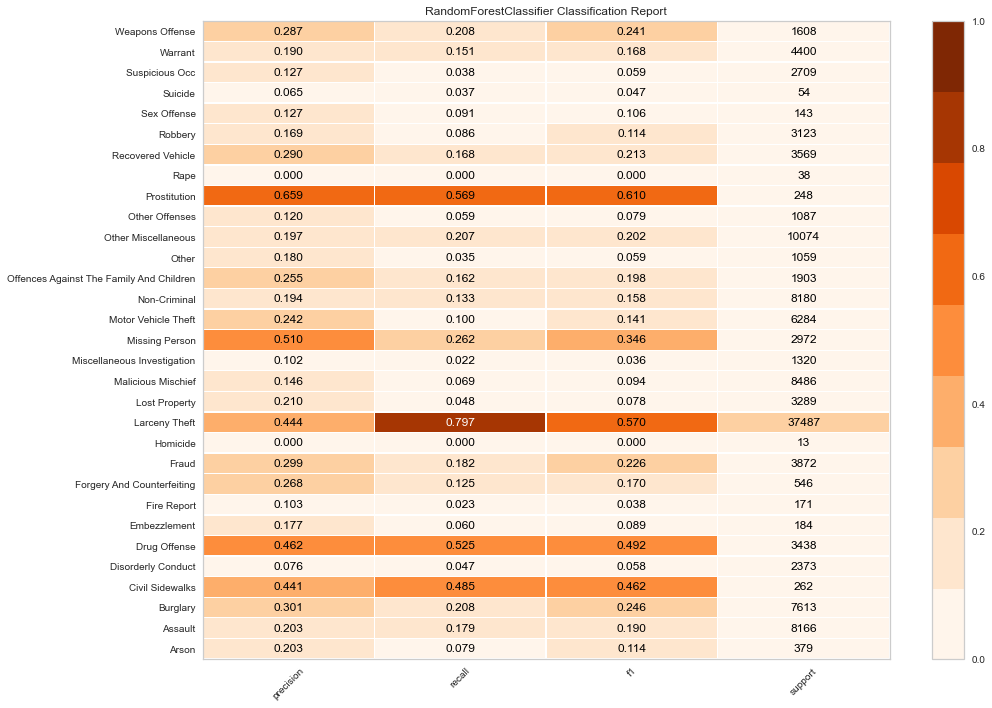

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [201]:
plt.figure(figsize=(15,10))

visualizer = ClassificationReport(model, support=True, cmap='Oranges' )

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

Choose to drop these classes to see if can further improve


|                         Incident Category|
|:----------------------------------------:|
|                                  Homicide|
|                                  Suicide |
|                                      Rape|


In [202]:
dropCategory ( [ 'Suicide', 'Homicide', 'Rape' ] )

dropping> Suicide
dropping done> Suicide
dropping> Homicide
dropping done> Homicide
dropping> Rape
dropping done> Rape


In [203]:
sf_input['Incident_Category'].unique()

array(['Arson', 'Larceny Theft', 'Missing Person', 'Drug Offense',
       'Fraud', 'Non-Criminal', 'Other Miscellaneous', 'Burglary',
       'Suspicious Occ', 'Motor Vehicle Theft', 'Lost Property',
       'Malicious Mischief', 'Assault',
       'Offences Against The Family And Children', 'Warrant',
       'Disorderly Conduct', 'Recovered Vehicle', 'Robbery',
       'Forgery And Counterfeiting', 'Civil Sidewalks', 'Other',
       'Miscellaneous Investigation', 'Other Offenses', 'Prostitution',
       'Weapons Offense', 'Fire Report', 'Embezzlement', 'Sex Offense'],
      dtype=object)

In [206]:
#'Incident_Datetime' = 'Incident_Year' + 'Incident_Date_Month' + Incident_Datetime_DayOfMonth + Incident_Datetime_HrOfDay + Incident_Datetime_Minute 
#AddIsWeekend
features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin',
                   'Latitude', 'Longitude', 'CrimeCounts_By_AnalysisNghrBood' ]



x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

#the above will translate to this in .values.ravel()
#y = sf_input.loc[ :, ['Incident_Category'] ] # Target variable
#y = y.values.ravel()

#print (y.shape)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test

model = RandomForestClassifier (random_state=88,n_jobs=-1)
# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)

f1_score_01 = f1_score(y_test, y_pred,average='weighted')*100
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 
print ('No of Classes in Y--> %d' %(len(model.classes_)))
#print ('Raw %f' %(recall_score(y_test, y_pred,average='weighted') ))

print(classification_report(y_test, y_pred,zero_division=0))

Accuracy: 34.97
f1_score: 29.76
Precision :29.48
Recall :34.97
ROC_AUC SCORE :69.73
No of Classes in Y--> 28
                                          precision    recall  f1-score   support

                                   Arson       0.20      0.07      0.10       375
                                 Assault       0.20      0.17      0.19      8060
                                Burglary       0.31      0.22      0.26      7575
                         Civil Sidewalks       0.46      0.45      0.46       264
                      Disorderly Conduct       0.09      0.05      0.07      2402
                            Drug Offense       0.45      0.53      0.48      3345
                            Embezzlement       0.20      0.08      0.12       165
                             Fire Report       0.08      0.02      0.03       163
              Forgery And Counterfeiting       0.21      0.11      0.15       525
                                   Fraud       0.31      0.18      0.2

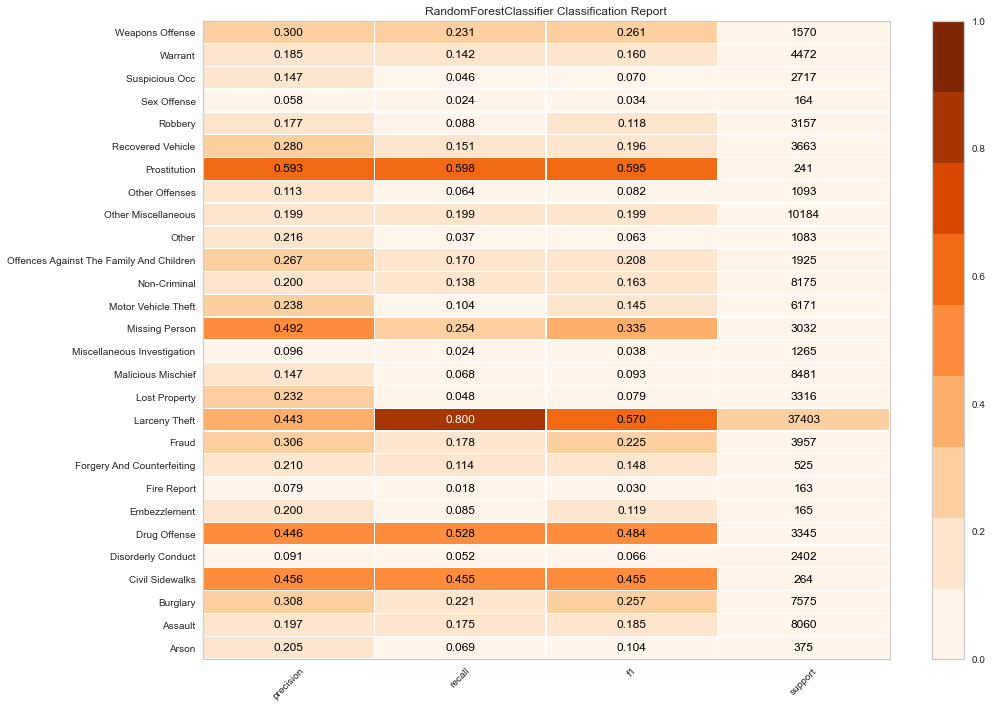

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [207]:
plt.figure(figsize=(15,10))

visualizer = ClassificationReport(model, support=True, cmap='Oranges')

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data

#visualizer.show(outpath="png_prod\\RFC_BaseRun_006_ClassifcationReport_AfterDroppedClasses.png")

visualizer.show()                       # Finalize and show the figure

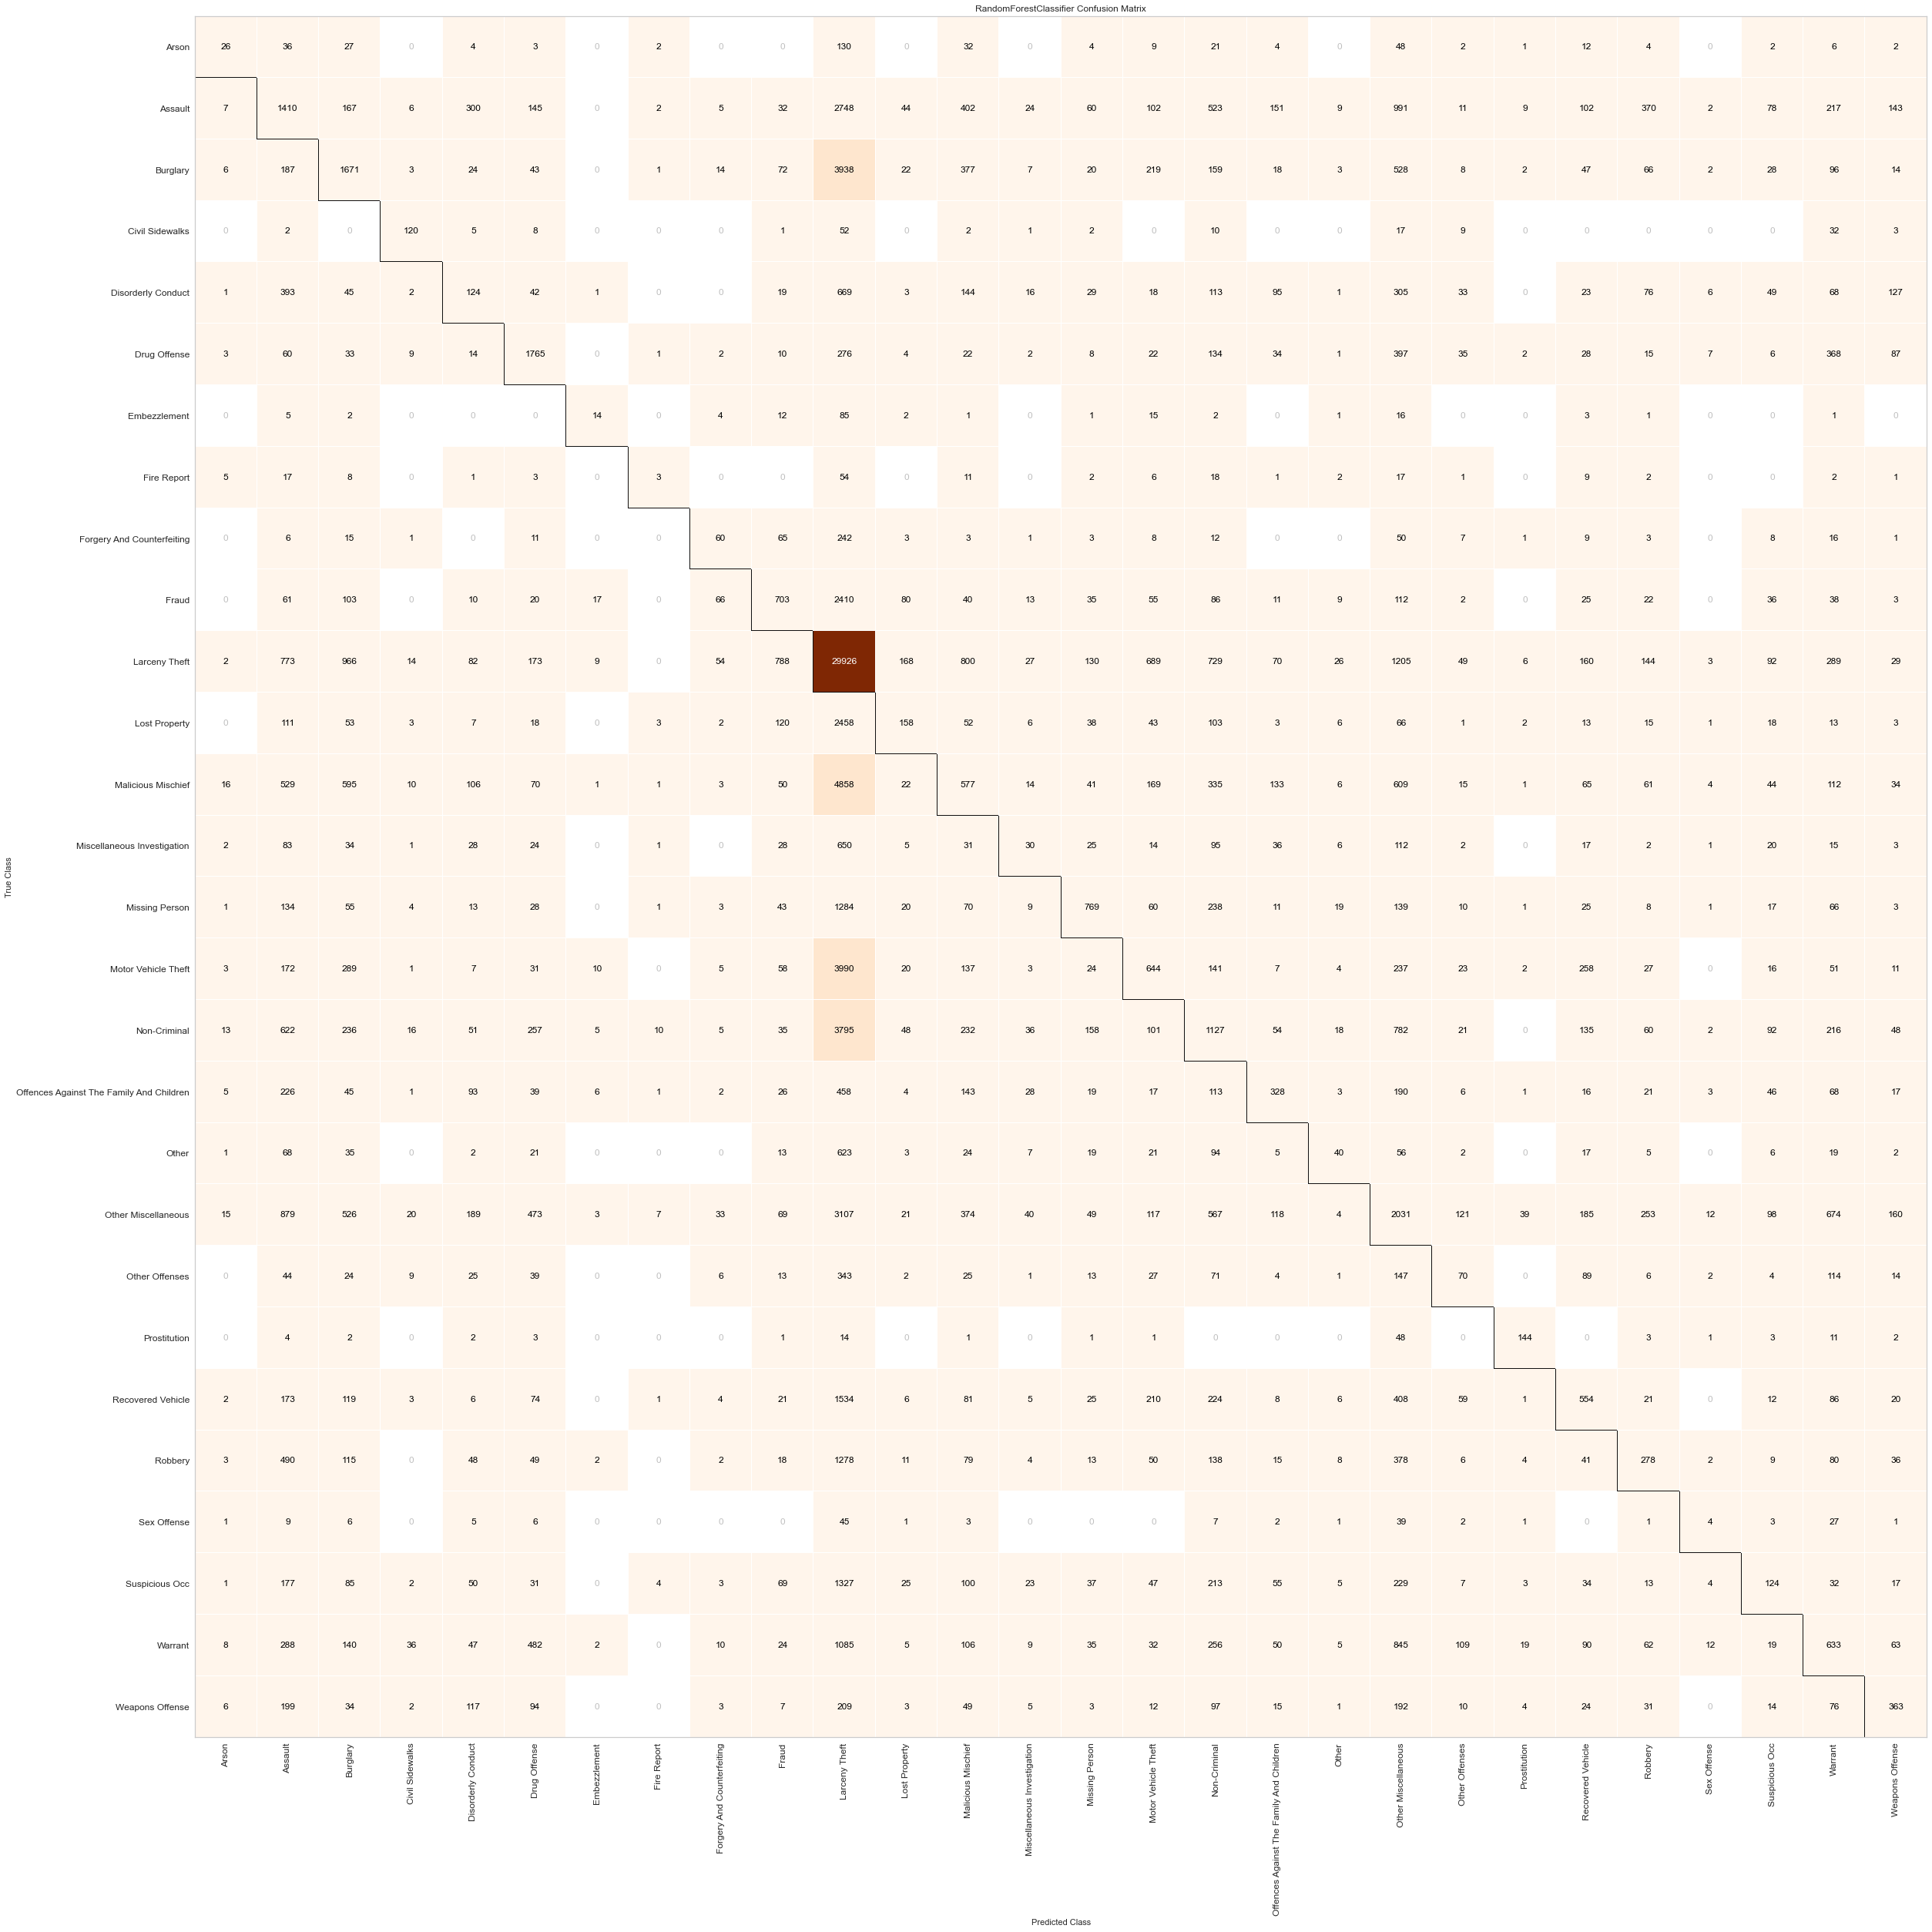

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [208]:
#print out confisionMatrix
plt.figure(figsize=(35,35))

confusion_RFC_cm = ConfusionMatrix(
    model , cmap="Oranges"
)

confusion_RFC_cm.fit(x_train, y_train)
confusion_RFC_cm.score(x_test, y_test)
#confusion_RFC_cm.show(outpath="png_prod\\RFC_BaseRun_007_ConfusionMatrix_AfterDroppedClasses.png")
confusion_RFC_cm.show()


In [ ]:
#plt.figure(figsize=(20,20))
#plot using sckitplot 
# Y_test_probs = model.predict_proba(x_test)

# skplt.metrics.plot_roc(y_test, Y_test_probs,
#                       title="ROC Curves for RandomForestClassifier", figsize=(20,20));

### 5.5 Actions Taken So Far to get to Base RFC 

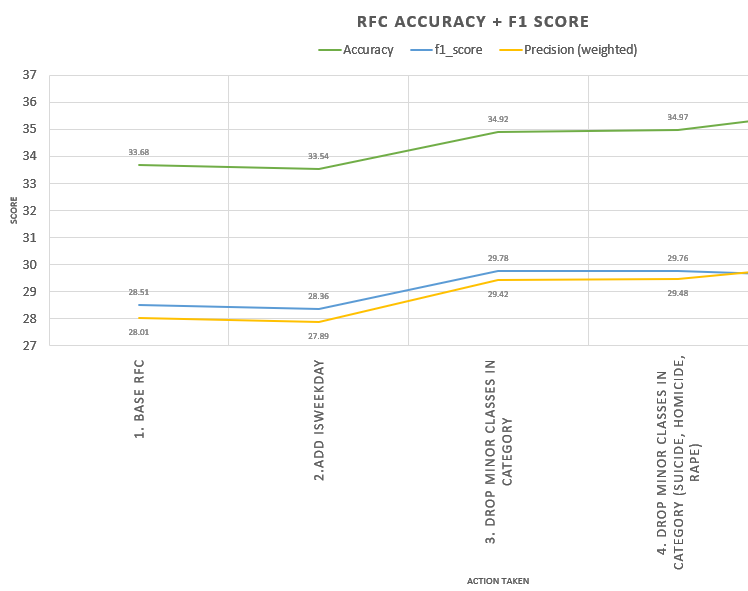

## So far, the dropping of the minor classes showed the highest improvement on the F1 & Accuracy

In [ ]:
#now that we have 29%(F1) , let's try running AdaBoost and DT on this 
#End Section 5 

## 6. Run a DT as a base model first 

In [210]:
#'Incident_Datetime' = 'Incident_Year' + 'Incident_Date_Month' + Incident_Datetime_DayOfMonth + Incident_Datetime_HrOfDay + Incident_Datetime_Minute 
#AddIsWeekend
features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin',
                   'Latitude', 'Longitude','CrimeCounts_By_AnalysisNghrBood'  ]

x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

#the above will translate to this in .values.ravel()
#y = sf_input.loc[ :, ['Incident_Category'] ] # Target variable
#y = y.values.ravel()

#print (y.shape)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test

model = DecisionTreeClassifier (random_state=88)
# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)

print('------------ [Decision Tree]------------')

f1_score_01 = f1_score(y_test, y_pred,average='weighted')*100
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 
print ('No of Classes in Y--> %d' %(len(model.classes_)))

print('------------End [Decision Tree]------------')


print(classification_report(y_test, y_pred,zero_division=0))

------------ [Decision Tree]------------
Accuracy: 24.49
f1_score: 24.66
Precision :25.03
Recall :24.49
ROC_AUC SCORE :57.70
No of Classes in Y--> 28
------------End [Decision Tree]------------
                                          precision    recall  f1-score   support

                                   Arson       0.07      0.08      0.08       375
                                 Assault       0.16      0.20      0.18      8060
                                Burglary       0.19      0.21      0.20      7575
                         Civil Sidewalks       0.29      0.29      0.29       264
                      Disorderly Conduct       0.05      0.06      0.06      2402
                            Drug Offense       0.38      0.54      0.45      3345
                            Embezzlement       0.09      0.13      0.11       165
                             Fire Report       0.03      0.03      0.03       163
              Forgery And Counterfeiting       0.09      0.13      

In [211]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 88,
 'splitter': 'best'}

In [ ]:
plt.figure(figsize=(15,10))

visualizer = ClassificationReport(model, support=True,cmap='Oranges')

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
#visualizer.show(outpath="png_prod\\DT_BaseRun_001_ClassificationReport.png")
visualizer.show()                       # Finalize and show the figure

In [ ]:
fig = plt.figure(figsize=(35,35))

confusion_DT_cm = ConfusionMatrix(
    model, cmap="Oranges"
)

confusion_DT_cm.fit(x_train, y_train)
confusion_DT_cm.score(x_test, y_test)
#confusion_DT_cm.show(outpath="png_prod\\DT_BaseRun_002_ConfusionMatrix_AfterDroppedClasses.png")
confusion_DT_cm.show()

## 7. Here's a basemodel for AdaBoost 

In [212]:
#'Incident_Datetime' = 'Incident_Year' + 'Incident_Date_Month' + Incident_Datetime_DayOfMonth + Incident_Datetime_HrOfDay + Incident_Datetime_Minute 
#AddIsWeekend
features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'Latitude', 'Longitude','CrimeCounts_By_AnalysisNghrBood'  ]


x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

#the above will translate to this in .values.ravel()
#y = sf_input.loc[ :, ['Incident_Category'] ] # Target variable
#y = y.values.ravel()

#print (y.shape)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test

model = AdaBoostClassifier (random_state=88)
# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)

print('------------ [AdaBoost]------------')
f1_score_01 = f1_score(y_test, y_pred,average='weighted',zero_division=0)*100
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted',zero_division=0)*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted',zero_division=0) *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 
print ('No of Classes in Y--> %d' %(len(model.classes_)))
print('------------ End [AdaBoost]------------')
print(classification_report(y_test, y_pred,zero_division=0))

------------ [AdaBoost]------------
Accuracy: 30.74
f1_score: 17.35
Precision :16.76
Recall :30.74
ROC_AUC SCORE :64.15
No of Classes in Y--> 28
------------ End [AdaBoost]------------
                                          precision    recall  f1-score   support

                                   Arson       0.00      0.00      0.00       375
                                 Assault       0.14      0.01      0.02      8060
                                Burglary       0.17      0.10      0.13      7575
                         Civil Sidewalks       0.19      0.10      0.13       264
                      Disorderly Conduct       0.00      0.00      0.00      2402
                            Drug Offense       0.25      0.36      0.30      3345
                            Embezzlement       0.00      0.00      0.00       165
                             Fire Report       0.00      0.00      0.00       163
              Forgery And Counterfeiting       0.00      0.00      0.00     

In [ ]:
model.get_params()

In [ ]:
plt.figure(figsize=(15,10))

visualizer = ClassificationReport(model, support=True,cmap='Oranges')

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
#visualizer.show(outpath="png_prod\\ADA_BaseRun_001_ClassificationReport.png")
visualizer.show()                       # Finalize and show the figure

In [ ]:
#print out confisionMatrix
fig = plt.figure(figsize=(35,35))

confusion_ADA_cm = ConfusionMatrix(
    model, cmap="Oranges"
)

confusion_ADA_cm.fit(x_train, y_train)
confusion_ADA_cm.score(x_test, y_test)
#confusion_ADA_cm.show(outpath="png_prod\\ADA_BaseRun_002_ConfusionMatrix_AfterDroppedClasses.png")
confusion_ADA_cm.show()

Observation : AdaBoost is really affected by the minor classes - except for the major classes, all the other classes are practically 0 precision + 0 recall

In [ ]:
#End Section 7 

## 8. Let's do a RandomSearchCV For These Models

### 8.1 Let's do  a RandomSearchCV for AdaBoost 

In [ ]:
## attempt a randomSearchCV for AdaBoost 
##!this will take time!
from sklearn.model_selection import RandomizedSearchCV
# define the grid of values to search
param_grid = dict()
param_grid['n_estimators'] = [50, 100, 500] #we start with these since the base model is n_estimators 
param_grid['learning_rate'] = [0.1, 1.0]
param_grid['algorithm'] = [ 'SAMME', 'SAMME.R']


##prepare for RandomSearchCV
x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test
##prepare for RandomSearchCV



start = time.time()
model = AdaBoostClassifier ( random_state=88 )
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid,  cv=7, random_state=88, n_jobs=3, verbose =100, scoring ='accuracy')
rsearch.fit(x_train, y_train)
end = time.time()
delta = end - start
#DELTA 
print ("[Time Taken in seconds] %s" % (delta) ) 
print(rsearch.best_score_)



In [ ]:
rsearch.best_params_

In [ ]:
#rsearch.cv_results_

In [ ]:
clearMemory_callGC()

### 8.2 Let's do  a RandomSearchCV for RFC 

In [ ]:
## attempt a randomSearchCV for RFC 
#this will take time # 
from sklearn.model_selection import RandomizedSearchCV
# define the grid of values to search
param_grid = dict()
param_grid['criterion'] = ['gini', 'entropy']
param_grid['max_features'] = ['auto', 'sqrt']
param_grid['n_estimators'] = [ 100, 200 ] #we start with these since the base model is n_estimators 
param_grid['min_samples_split'] = [2, 5, 10, 20,50, 100]
#param_grid['learning_rate'] = [0.1, 1.0]

##prepare for RandomSearchCV
x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test
##prepare for RandomSearchCV


start = time.time()
model = RandomForestClassifier (random_state=88)
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=7, random_state=88, n_jobs=3, verbose =100, scoring = 'accuracy')
rsearch.fit(x_train, y_train)
end = time.time()
delta = end - start
print ("[Time Taken in seconds] %s" % (delta) )

print(rsearch.best_score_)
#print(rsearch.best_estimator_.alpha)

In [ ]:
#rsearch.cv_results_['std_test_score']

In [ ]:
rsearch.best_params_


In [ ]:
rsearch.best_estimator_

In [ ]:
#joblib.dump(rsearch.best_estimator_, 'models//RFC_RandomGrdCV_trained.pkl')


In [ ]:
#trainmodel = joblib.load ( 'models/RFC_RandomGrdCV_trained.pkl')


### 8.3 Let's do  a RandomSearchCV for DT


In [ ]:
## attempt a randomSearchCV for DT 
from sklearn.model_selection import RandomizedSearchCV
# define the grid of values to search
param_grid = dict()
param_grid ["criterion"] = ['gini', 'entropy' ]
param_grid ["max_depth"] = list(range(2,10) )
param_grid ["min_samples_split"] =  list(range(2,10) )
param_grid ["min_samples_leaf"] = list(range(2,10) )


##prepare for RandomSearchCV
x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test
##prepare for RandomSearchCV



start = time.time()
model = DecisionTreeClassifier (  random_state=88 )
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=7, random_state=88, n_jobs=3, verbose =100, scoring ='accuracy')
rsearch.fit(x_train, y_train)
end = time.time()
delta = end - start
#DELTA 
print ("[Time Taken in seconds] %s" % (delta) ) 
print(rsearch.best_score_)



In [ ]:
#rsearch.cv_results_

In [ ]:
rsearch.best_params_

In [ ]:
#joblib.dump(rsearch.best_estimator_, 'models//DT_RandomGrdCV_trained.pkl')

### This completes the RandomSearchCV for DT, RFC and AdaBoost 

### 8.4 We plug in the optimum parameters for DT, RFC , AdaBoost 

In [ ]:
#Rerun the base model using the randomSearch parameters fo RFC 


# {'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'sqrt'} -- *** choose this one, came from a previous run on another machine
# --
# Accuracy: 35.79
# f1_score: 29.55
# Precision :30.10
# Recall :35.79
# ROC_AUC SCORE :71.23
# --
# {'n_estimators': 500, 'min_samples_split': 20, 'max_features': 'sqrt'}  -- 
# --
# Accuracy: 35.26
# f1_score: 25.50
# Precision :30.44
# Recall :35.26
# --
# RUNNING FROM THERE 

# {'n_estimators': 500, 'min_samples_split': 20, 'max_features': 'auto'} -- 35.26

#run on 20210607 
# "{'n_estimators': 200,
# 'min_samples_split': 10,
# 'max_features': 'sqrt',
# 'criterion': 'gini'}"

#run on 20210612
#{'n_estimators': 200,
# 'min_samples_split': 10,
# 'max_features': 'sqrt',
# 'criterion': 'gini'}"




### 8.4.1 Optimized Tuned RFC 

In [213]:
features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'Latitude', 'Longitude','CrimeCounts_By_AnalysisNghrBood'  ]

x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test

#model = RandomForestClassifier (random_state=88, n_estimators=500,min_samples_split=20,max_features='sqrt' )
#this gives a better performance 
model = RandomForestClassifier (random_state=88, n_estimators=200,min_samples_split=10,max_features='sqrt', criterion='gini', n_jobs=2 )

# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)
# evaluate predictions


f1_score_01 = f1_score(y_test, y_pred,average='weighted')
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01*100))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 


print(classification_report(y_test, y_pred,zero_division=0))

Accuracy: 35.78
f1_score: 27.72
Precision :30.67
Recall :35.78
ROC_AUC SCORE :74.21
                                          precision    recall  f1-score   support

                                   Arson       0.38      0.04      0.07       375
                                 Assault       0.21      0.17      0.19      8060
                                Burglary       0.34      0.19      0.25      7575
                         Civil Sidewalks       0.45      0.47      0.46       264
                      Disorderly Conduct       0.10      0.02      0.04      2402
                            Drug Offense       0.43      0.50      0.46      3345
                            Embezzlement       0.18      0.02      0.03       165
                             Fire Report       0.20      0.01      0.02       163
              Forgery And Counterfeiting       0.32      0.04      0.07       525
                                   Fraud       0.39      0.11      0.17      3957
             

In [ ]:
plt.figure(figsize=(15,10))

visualizer = ClassificationReport(model, support=True)

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
## visualizer.show(outpath="png_prod\\RFC_Optimized_001_ClassificationReport.png")
visualizer.show()                       # Finalize and show the figure

In [ ]:
#we can use this to see which has more errors, however due to to many classes, this is not easy to read 

# from yellowbrick.classifier import class_prediction_error
# fig = plt.figure(figsize=(35,35))

# class_prediction_error(
#    model ,
#    x_train, y_train, x_test, y_test,
#    colormap="Set1"
#)

In [ ]:
#print out confisionMatrix
fig = plt.figure(figsize=(35,35))

confusion_RFC_Tuned_cm = ConfusionMatrix(
    model, cmap="Oranges"
)

confusion_RFC_Tuned_cm.fit(x_train, y_train)
confusion_RFC_Tuned_cm.score(x_test, y_test)
#confusion_ADA_cm.show(outpath="png_prod\\ADA_BaseRun_002_ConfusionMatrix_AfterDroppedClasses.png")
confusion_RFC_Tuned_cm.show()

### 8.4.2 Optimized Tuned DT

In [ ]:
# "{'min_samples_split': 2,
#  'min_samples_leaf': 5,
#  'max_depth': 9,
#  'criterion': 'entropy'}"

#run on 20210612
"{'min_samples_split': 9,
 'min_samples_leaf': 3,
 'max_depth': 9,
 'criterion': 'entropy'}"


In [214]:
#'Incident_Datetime' = 'Incident_Year' + 'Incident_Date_Month' + Incident_Datetime_DayOfMonth + Incident_Datetime_HrOfDay + Incident_Datetime_Minute 
#AddIsWeekend
features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin',
                   'Latitude', 'Longitude','CrimeCounts_By_AnalysisNghrBood'  ]



x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

#the above will translate to this in .values.ravel()
#y = sf_input.loc[ :, ['Incident_Category'] ] # Target variable
#y = y.values.ravel()

#print (y.shape)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test

model = DecisionTreeClassifier (random_state=88,min_samples_split=9,min_samples_leaf=3,max_depth=9, criterion='entropy')
# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)

print('------------ [Decision Tree]------------')

f1_score_01 = f1_score(y_test, y_pred,average='weighted')*100
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 
print ('No of Classes in Y--> %d' %(len(model.classes_)))

print('------------End [Decision Tree]------------')


print(classification_report(y_test, y_pred,zero_division=0))

------------ [Decision Tree]------------


D:\ProgramData\anaconda3\envs\TP21_CAI1C01_PROJ\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 31.80
f1_score: 19.59
Precision :22.29
Recall :31.80
ROC_AUC SCORE :69.05
No of Classes in Y--> 28
------------End [Decision Tree]------------
                                          precision    recall  f1-score   support

                                   Arson       0.00      0.00      0.00       375
                                 Assault       0.16      0.11      0.13      8060
                                Burglary       0.25      0.18      0.21      7575
                         Civil Sidewalks       0.00      0.00      0.00       264
                      Disorderly Conduct       0.00      0.00      0.00      2402
                            Drug Offense       0.33      0.38      0.35      3345
                            Embezzlement       0.11      0.01      0.01       165
                             Fire Report       0.00      0.00      0.00       163
              Forgery And Counterfeiting       0.05      0.00      0.00       525
                          

In [ ]:
plt.figure(figsize=(15,10))

visualizer = ClassificationReport(model, support=True)

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
#visualizer.show(outpath="png_prod\\DT_Optimized_001_ClassificationReport.png")
visualizer.show()                       # Finalize and show the figure

In [ ]:
#print out confisionMatrix
fig = plt.figure(figsize=(35,35))

confusion_DT_Tuned_cm = ConfusionMatrix(
    model, cmap="Oranges"
)

confusion_DT_Tuned_cm.fit(x_train, y_train)
confusion_DT_Tuned_cm.score(x_test, y_test)
confusion_DT_Tuned_cm.show()

### 8.4.3 Optimized Tuned AdaBoost

In [ ]:
# {'n_estimators': 50, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}


In [215]:
#'Incident_Datetime' = 'Incident_Year' + 'Incident_Date_Month' + Incident_Datetime_DayOfMonth + Incident_Datetime_HrOfDay + Incident_Datetime_Minute 

features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'Latitude', 'Longitude','CrimeCounts_By_AnalysisNghrBood'  ]


x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

#the above will translate to this in .values.ravel()
#y = sf_input.loc[ :, ['Incident_Category'] ] # Target variable
#y = y.values.ravel()

#print (y.shape)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test

model = AdaBoostClassifier (random_state=88,n_estimators=50,learning_rate=1.0, algorithm='SAMME.R')
# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)

print('------------ [AdaBoost]------------')
f1_score_01 = f1_score(y_test, y_pred,average='weighted',zero_division=0)*100
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted',zero_division=0)*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted',zero_division=0) *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 
print ('No of Classes in Y--> %d' %(len(model.classes_)))
print('------------ End [AdaBoost]------------')
print(classification_report(y_test, y_pred,zero_division=0))

------------ [AdaBoost]------------
Accuracy: 30.74
f1_score: 17.35
Precision :16.76
Recall :30.74
ROC_AUC SCORE :64.15
No of Classes in Y--> 28
------------ End [AdaBoost]------------
                                          precision    recall  f1-score   support

                                   Arson       0.00      0.00      0.00       375
                                 Assault       0.14      0.01      0.02      8060
                                Burglary       0.17      0.10      0.13      7575
                         Civil Sidewalks       0.19      0.10      0.13       264
                      Disorderly Conduct       0.00      0.00      0.00      2402
                            Drug Offense       0.25      0.36      0.30      3345
                            Embezzlement       0.00      0.00      0.00       165
                             Fire Report       0.00      0.00      0.00       163
              Forgery And Counterfeiting       0.00      0.00      0.00     

In [216]:
model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 88}

In [ ]:
plt.figure(figsize=(15,10))

visualizer = ClassificationReport(model, support=True)

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
## visualizer.show(outpath="png_prod\\RFC_Optimized_001_ClassificationReport.png")
visualizer.show()                       # Finalize and show the figure

## Here's the relative improvement / decrease ( from base model ) to tuned hyperparameters 


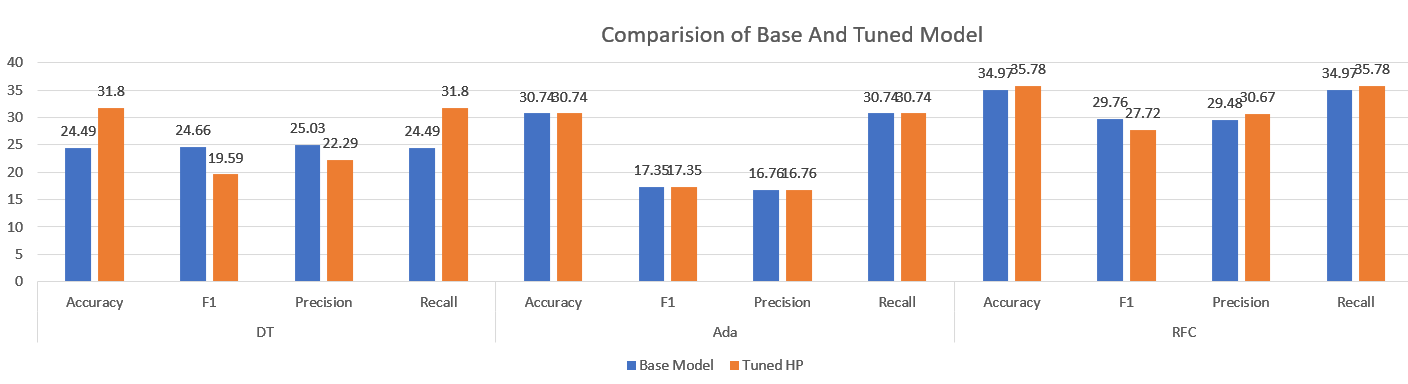

<b>Observation</b>: <br/>
    There is an <b>improvement</b> in Precision, Recall, Accuracy for RFC - the slight drop in F1 is due to increase in Recall<br/>
    There seems to be <b>no improvement </b> for ADA <br/>
        There is an <b>decrease<b> for DT - the increase in F1 is actually attributed to LArceny/Prostitution but all the other classes' recall have decreased <br/>

In [ ]:
#this concludes section 8

## 9. [Optional ] Attempt to address Imbalanced Classification

In [217]:
clearMemory_callGC()

<Figure size 576x396 with 0 Axes>

In [ ]:
clearMemory_callGC()

### 9.1 [ Optional ] SMOTE -  Synthetic Minority Oversampling TEchnique
### Since we saw that there was some problems with the dataset - the major class greatly outnumber the rest of the classes , we can attempt SMOTE to see if it can alleviate the problem 


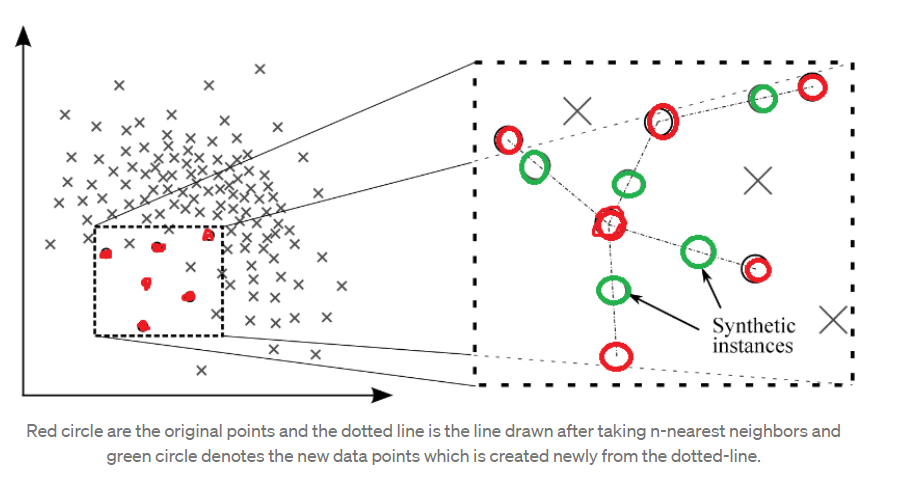
Reference from https://medium.com/analytics-vidhya/how-to-handle-imbalanced-dataset-b3dc05b85bf9

### Note: Decided to remove remove the [CrimeCounts_By_AnalysisNghrBood]  
because there's a need to redo the 
count after generation of synthetic generation 
& it's not really important feature 
(see feature importance after train) 

In [218]:
from imblearn.over_sampling import SMOTE


#! this need some time to run! 

features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'Latitude', 'Longitude' ]

#insert delta 
x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

start = time.time()
oversample = SMOTE( random_state=88, n_jobs =3 )
x, y = oversample.fit_resample(x, y)
end = time.time() 
delta = end - start
print ("[SMOTE RESAMPLING Time Taken in seconds] %s" % (delta) ) 

#the above will translate to this in .values.ravel()
#y = sf_input.loc[ :, ['Incident_Category'] ] # Target variable
#y = y.values.ravel()

#print (y.shape)
start = time.time()

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test

model = RandomForestClassifier (random_state=88, n_estimators=100,min_samples_split=5,max_features='auto', n_jobs=-1 )




# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)
# evaluate predictions

accuracy_score_01 = accuracy_score(y_test, y_pred)*100
f1_score_01 = f1_score(y_test, y_pred,average='weighted')*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 ##try change to micro ,average='micro'
# macro = Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
#weighted = takes in the imbalance in classes 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100  
#area_under_pr_curve01 = average_precision_score ( y_test, model.predict_proba(x_test) , average='weighted') #this does not support multiclass

end = time.time() 
delta = end - start
print ("[RFC Done.. Time Taken in seconds] %s" % (delta) )


print('------------ [SMOTE BASIC ]------------')
print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 

print ('No of Classes in Y--> %d' %(len(model.classes_)))
print ('No of Samples in Y_TEST --> %d' %(y_test.size))

#counter_y_pred = Counter(y_pred)
#print (counter_y_pred )
#printDistribution_Of_Y (y , 'ALL Y' )
print('------------ END [SMOTE BASIC ]------------')



#y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred,zero_division=0))


[SMOTE RESAMPLING Time Taken in seconds] 103.5292432308197
[RFC Done.. Time Taken in seconds] 527.1291084289551
------------ [SMOTE BASIC ]------------
Accuracy: 76.31
f1_score: 75.55
Precision :75.61
Recall :76.31
ROC_AUC SCORE :96.94
No of Classes in Y--> 28
No of Samples in Y_TEST --> 1049379
------------ END [SMOTE BASIC ]------------
                                          precision    recall  f1-score   support

                                   Arson       0.90      0.99      0.94     37529
                                 Assault       0.60      0.44      0.51     37705
                                Burglary       0.64      0.56      0.59     37513
                         Civil Sidewalks       0.94      1.00      0.97     37195
                      Disorderly Conduct       0.72      0.73      0.73     37240
                            Drug Offense       0.78      0.87      0.82     37663
                            Embezzlement       0.93      0.99      0.96     37621
  

In [ ]:
#print out confisionMatrix
#this seem to take resources
fig = plt.figure(figsize=(35,35))

confusion_SMOTE = ConfusionMatrix(
    model, cmap="Oranges"
)

confusion_SMOTE.fit(x_train, y_train)
confusion_SMOTE.score(x_test, y_test)
#confusion_SMOTE.show(outpath="png_prod\\Optional_01_SMOTE_RFC_ConfusionMatrix_02.png")
confusion_SMOTE.show()

In [ ]:
plt.figure(figsize=(15,10))

visualizer = ClassificationReport(model, support=True)

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
#visualizer.show(outpath="png_prod\\Optional_01_SMOTE_RFC_ClassificationReport.png")
visualizer.show()                       # Finalize and show the figure

In [219]:
clearMemory_callGC()

<Figure size 576x396 with 0 Axes>

### Note!!: The basic SMOTE to upsample every class to the same no. 

In [204]:
clearMemory_callGC()

<Figure size 576x396 with 0 Axes>

[Optional] Try out SMOTENN
Nope this is too slow, the amount of time taken for SMOTEEEN will be n** 

[Optional] Try out SMOTEN - replace SMOTE by SMOTEN
- Forget this. This is too slow and takes up too many resources 



## 6.2 [Optional] Try out OVerSampling and Undersampling


Reference : https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/ 

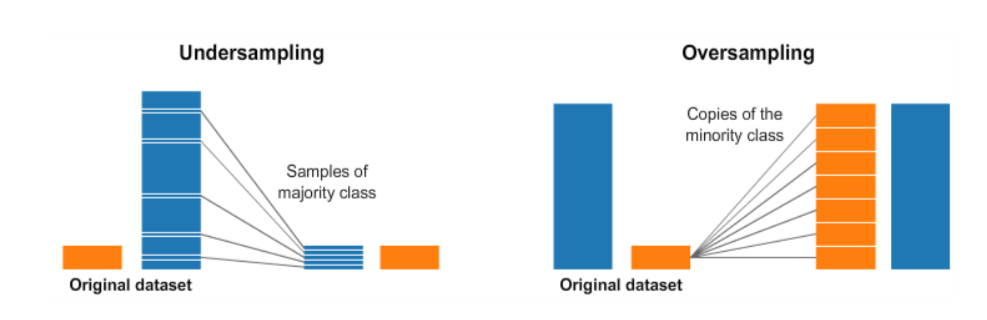

In [220]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'Latitude', 'Longitude' ]



x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

print ('-----------ORIG------------')
#print(Counter(y))
#printDistribution_Of_Y (y , 'ORIG Y' )

print ('-----------OVERSAMPLE NON-MAJOR CLASSES------------')
#os =  RandomOverSampler(sampling_strategy='not majority')

os =  RandomOverSampler(sampling_strategy='minority')

X1, y1 = os.fit_resample(x, y)
#print(Counter(y1))

print ('-----------UNDERSAMPLE MAJOR------------')
under = RandomUnderSampler(sampling_strategy='majority')
X2, y2 = under.fit_resample(X1, y1)
#print(Counter(y2))

#printDistribution_Of_Y (y2 , 'AFTER OS and US' )


-----------ORIG------------
-----------OVERSAMPLE NON-MAJOR CLASSES------------
-----------UNDERSAMPLE MAJOR------------


In [221]:


#x = sf_input[ features_selected05 ] # Features
#y = sf_input[ 'Incident_Category' ] # Target variable

x_train, x_test, y_train, y_test = model_selection.train_test_split(X2, y2, test_size=0.3, random_state=88) # 70% training and 30% test

#model = RandomForestClassifier (random_state=88, n_estimators=500,min_samples_split=20,max_features='sqrt' )
#this gives a better performance 
model = RandomForestClassifier (random_state=88, n_estimators=100,min_samples_split=5,max_features='sqrt', n_jobs=2 )



# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)
# evaluate predictions

print ('-----------OVERSAMPLE & UNDERSAMPLING IN 1 PROCESS -----------')
f1_score_01 = f1_score(y_test, y_pred,average='weighted')
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01*100))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 ))
print ('No of Samples in Y_TEST --> %d' %(y_test.size))
print ('--------END OVERSAMPLE & UNDERSAMPLING IN 1 PROCESS -----------')

print(classification_report(y_test, y_pred,zero_division=0))
##PRINTDISTRIBUTION


-----------OVERSAMPLE & UNDERSAMPLING IN 1 PROCESS -----------
Accuracy: 46.88
f1_score: 46.11
Precision :46.70
Recall :46.88
ROC_AUC SCORE :79.17
No of Samples in Y_TEST --> 124957
--------END OVERSAMPLE & UNDERSAMPLING IN 1 PROCESS -----------
                                          precision    recall  f1-score   support

                                   Arson       0.18      0.04      0.07       402
                                 Assault       0.20      0.25      0.22      8136
                                Burglary       0.30      0.37      0.33      7538
                         Civil Sidewalks       0.47      0.52      0.50       258
                      Disorderly Conduct       0.08      0.04      0.05      2273
                            Drug Offense       0.44      0.54      0.49      3370
                            Embezzlement       0.26      0.05      0.08       207
                             Fire Report       0.14      0.02      0.04       172
              F

In [ ]:
# Accuracy: 46.93
# f1_score: 46.16
# Precision :46.77
# Recall :46.93
# ROC_AUC SCORE :79.06

In [ ]:
#print out confisionMatrix
fig = plt.figure(figsize=(35,35))

confusion_OverSamplingUnderSampling = ConfusionMatrix(
    model, cmap="Oranges"
)

confusion_OverSamplingUnderSampling.fit(x_train, y_train)
confusion_OverSamplingUnderSampling.score(x_test, y_test)
#confusion_OverSamplingUnderSampling.show(outpath="png_prod\\Optional_09_RandomOSUnderS_RFC_ConfusionMatrix.png")
confusion_OverSamplingUnderSampling.show()

In [222]:
clearMemory_callGC()
#del confusion_OverSamplingUnderSampling
del visualizer

<Figure size 576x396 with 0 Axes>

In [ ]:
#Just simple OverSampling 'not majority'

In [223]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'Latitude', 'Longitude' ]



x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

print ('-----------ORIG------------')
#print(Counter(y))
#printDistribution_Of_Y (y , 'ORIG Y' )

print ('-----------OVERSAMPLE NON-MAJOR CLASSES------------')
#os =  RandomOverSampler(sampling_strategy='not majority')

os =  RandomOverSampler(sampling_strategy='not majority')

X1, y1 = os.fit_resample(x, y)
#printDistribution_Of_Y (y1 , 'AFTER OVERSAMPLING NON-MAJOR' )


x_train, x_test, y_train, y_test = model_selection.train_test_split(X1, y1, test_size=0.3, random_state=88) # 70% training and 30% test

#model = RandomForestClassifier (random_state=88, n_estimators=500,min_samples_split=20,max_features='sqrt' )
#this gives a better performance 
model = RandomForestClassifier (random_state=88, n_estimators=100,min_samples_split=5,max_features='sqrt', n_jobs=2 )



# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)
# evaluate predictions

print ('-----------OVERSAMPLE NOT MAJOR CLASSES ONLY -----------')
f1_score_01 = f1_score(y_test, y_pred,average='weighted')
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01*100))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 
print ('No of Samples in Y_TEST --> %d' %(y_test.size))
print ('--------END OVERSAMPLE NOT MAJOR CLASSES ONLY -----------')

print(classification_report(y_test, y_pred,zero_division=0))
##PRINTDISTRIBUTION




-----------ORIG------------
-----------OVERSAMPLE NON-MAJOR CLASSES------------
-----------OVERSAMPLE NOT MAJOR CLASSES ONLY -----------
Accuracy: 90.13
f1_score: 89.81
Precision :90.02
Recall :90.13
ROC_AUC SCORE :99.58
No of Samples in Y_TEST --> 1049379
--------END OVERSAMPLE NOT MAJOR CLASSES ONLY -----------
                                          precision    recall  f1-score   support

                                   Arson       0.97      0.99      0.98     37529
                                 Assault       0.84      0.71      0.77     37705
                                Burglary       0.87      0.88      0.87     37513
                         Civil Sidewalks       0.97      1.00      0.99     37195
                      Disorderly Conduct       0.78      0.81      0.79     37240
                            Drug Offense       0.83      0.86      0.84     37663
                            Embezzlement       0.98      1.00      0.99     37621
                            

In [ ]:
#print out confisionMatrix
fig = plt.figure(figsize=(35,35))

confusion_OverSampling = ConfusionMatrix(
    model, cmap="Oranges"
)

confusion_OverSampling.fit(x_train, y_train)
confusion_OverSampling.score(x_test, y_test)
#confusion_OverSamplingUnderSampling.show(outpath="png_prod\\Optional_09_RandomOSUnderS_RFC_ConfusionMatrix.png")
confusion_OverSampling.show()

In [ ]:
#End Just simple OverSampling 'not majority'

In [224]:
clearMemory_callGC()
#del confusion_OverSamplingUnderSampling
#del visualizer
#del confusion_OverSampling
#del model
clearMemory_callGC()

<Figure size 576x396 with 0 Axes>

In [ ]:
#Start Just simple OverSampling 'minority'

In [225]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'Latitude', 'Longitude' ]



x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

print ('-----------ORIG------------')
#print(Counter(y))
#printDistribution_Of_Y (y , 'ORIG Y' )

print ('-----------OVERSAMPLE NON-MAJOR CLASSES------------')
#os =  RandomOverSampler(sampling_strategy='not majority')

os =  RandomOverSampler(sampling_strategy='minority')

X1, y1 = os.fit_resample(x, y)
#printDistribution_Of_Y (y1 , 'AFTER OVERSAMPLING minority' )



-----------ORIG------------
-----------OVERSAMPLE NON-MAJOR CLASSES------------


In [226]:


x_train, x_test, y_train, y_test = model_selection.train_test_split(X1, y1, test_size=0.3, random_state=88) # 70% training and 30% test

#model = RandomForestClassifier (random_state=88, n_estimators=500,min_samples_split=20,max_features='sqrt' )
#this gives a better performance 
model = RandomForestClassifier (random_state=88, n_estimators=100,min_samples_split=5,max_features='sqrt', n_jobs=2 )



# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)
# evaluate predictions

print ('-----------OVERSAMPLE MINOR CLASS ONLY -----------')
f1_score_01 = f1_score(y_test, y_pred,average='weighted')
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01*100))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 
print ('No of Samples in Y_TEST --> %d' %(y_test.size))
print ('-------END   OVERSAMPLE MINOR CLASS ONLY -----------')

print(classification_report(y_test, y_pred,zero_division=0))
##PRINTDISTRIBUTION

-----------OVERSAMPLE MINOR CLASS ONLY -----------
Accuracy: 50.55
f1_score: 45.26
Precision :46.36
Recall :50.55
ROC_AUC SCORE :78.10
No of Samples in Y_TEST --> 162266
-------END   OVERSAMPLE MINOR CLASS ONLY -----------
                                          precision    recall  f1-score   support

                                   Arson       0.17      0.04      0.06       380
                                 Assault       0.22      0.17      0.19      8184
                                Burglary       0.32      0.20      0.24      7588
                         Civil Sidewalks       0.53      0.44      0.48       252
                      Disorderly Conduct       0.08      0.04      0.05      2294
                            Drug Offense       0.45      0.51      0.48      3359
                            Embezzlement       0.20      0.05      0.08       170
                             Fire Report       0.12      0.02      0.03       189
              Forgery And Counterfeiti

In [ ]:
#print out confisionMatrix
fig = plt.figure(figsize=(35,35))

confusion_OverSampling = ConfusionMatrix(
    model, cmap="Oranges"
)

confusion_OverSampling.fit(x_train, y_train)
confusion_OverSampling.score(x_test, y_test)
#confusion_OverSamplingUnderSampling.show(outpath="png_prod\\Optional_09_RandomOSUnderS_RFC_ConfusionMatrix.png")
confusion_OverSampling.show()

In [ ]:
#Start Just simple OverSampling 'minority'

In [205]:
clearMemory_callGC()
#del confusion_OverSamplingUnderSampling
#del visualizer
del confusion_OverSampling

NameError: name 'confusion_OverSampling' is not defined

<Figure size 576x396 with 0 Axes>

In [227]:
clearMemory_callGC()

<Figure size 576x396 with 0 Axes>

### 9.3  [Optional] Try Out TomekLinks method 

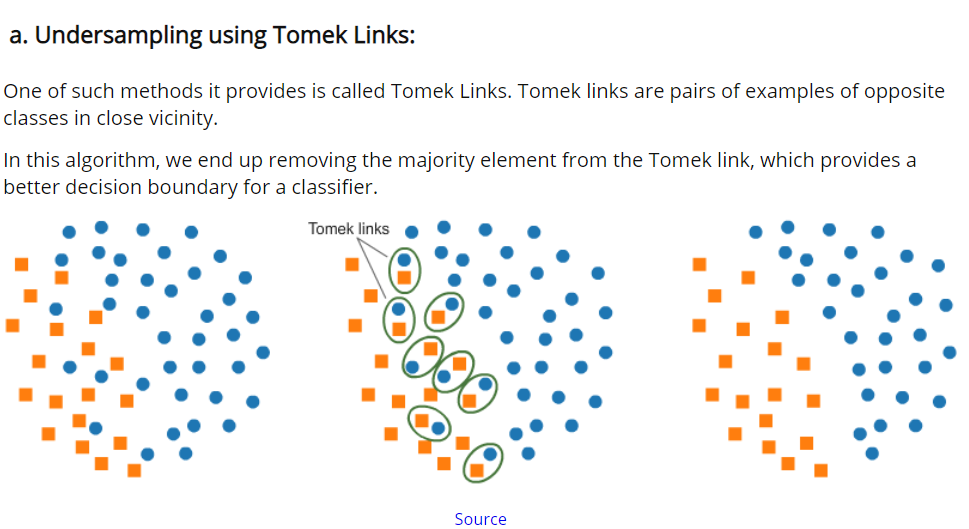

In [ ]:
clearMemory_callGC()

In [228]:
from collections import Counter
from imblearn.under_sampling import TomekLinks 

features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'Latitude', 'Longitude' ]


x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

print ('-----------ORIG------------')
#printDistribution_Of_Y (y , 'ORIGIN Y' )


print ('-----------USING TOMEKLINKS MAJOR------------')
tl = TomekLinks(n_jobs=2)
X_res, y_res = tl.fit_resample(x, y)
#print(Counter(y_res))
#printDistribution_Of_Y (y_res , 'TOMEKLINKS Y' )

-----------ORIG------------
-----------USING TOMEKLINKS MAJOR------------


In [229]:


x_train, x_test, y_train, y_test = model_selection.train_test_split(X_res, y_res, test_size=0.3, random_state=88) # 70% training and 30% test

#model = RandomForestClassifier (random_state=88, n_estimators=500,min_samples_split=20,max_features='sqrt' )
#this gives a better performance 
model = RandomForestClassifier (random_state=88, n_estimators=100,min_samples_split=5,max_features='sqrt', n_jobs=3 )



# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)
# evaluate predictions


f1_score_01 = f1_score(y_test, y_pred,average='weighted')
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01*100))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 
print ('No of Samples in Y_TEST --> %d' %(y_test.size))

print(classification_report(y_test, y_pred,zero_division=0))

Accuracy: 37.83
f1_score: 32.16
Precision :32.64
Recall :37.83
ROC_AUC SCORE :72.17
No of Samples in Y_TEST --> 95039
                                          precision    recall  f1-score   support

                                   Arson       0.23      0.09      0.13       274
                                 Assault       0.22      0.20      0.21      6408
                                Burglary       0.33      0.23      0.27      5522
                         Civil Sidewalks       0.46      0.36      0.41       203
                      Disorderly Conduct       0.09      0.05      0.06      2008
                            Drug Offense       0.47      0.55      0.51      3229
                            Embezzlement       0.25      0.06      0.10       124
                             Fire Report       0.14      0.02      0.04       121
              Forgery And Counterfeiting       0.26      0.11      0.16       420
                                   Fraud       0.37      0.20

In [ ]:
#print out confisionMatrix
fig = plt.figure(figsize=(35,35))

confusion_OverSamplingUnderSampling = ConfusionMatrix(
    model, cmap="Oranges"
)

confusion_OverSamplingUnderSampling.fit(x_train, y_train)
confusion_OverSamplingUnderSampling.score(x_test, y_test)
#confusion_OverSamplingUnderSampling.show(outpath="png_prod\\Optional_06_TomekLinks_ConfusionMatrix.png")
confusion_OverSamplingUnderSampling.show()

In [ ]:
## End [Optional] Try Out TomekLinks method 

### 9.4 Start [Optional] Try Out Liu Zhining's suggestion (adapted)
refer to https://zhuanlan.zhihu.com/p/68099299

In [230]:
def ratio_multiplier(y):
    from collections import Counter
    #this sets the class sample to the ratio specified here 
    multiplier = { 'Larceny Theft': 0.2, 'Other Miscellaneous': 0.58, }
    target_stats = Counter(y)
    print (target_stats )
    for key, value in target_stats.items():
        if key in multiplier:
            target_stats[key] = int(value * multiplier[key])
    return target_stats


#ratio_multiplier ( y_train )

In [231]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter




features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'Latitude', 'Longitude' ]


x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable
#print(sorted(Counter(y).items()))

#x = sf_input[ features_selected05 ] # Features
#y = sf_input[ 'Incident_Category' ] # Target variable

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test
#print ('Y_TRAIN RATION')
#print(sorted(Counter(y_train).items()))

print ('---END Y_TRAIN RATION--------------')
freq = dict(sorted(Counter(y_train).items()))
#freq
#max(freq.items(), key=lambda x: x[1])  
##min(freq.items(), key=lambda x: x[1])  


SORTED_DESCENDING_NUMER_DICT = sorted(freq.items(), key=lambda x: x[1])
#SORTED_DESCENDING_NUMER_DICT
#print ( type ( SORTED_DESCENDING_NUMER_DICT ))
#print ( len (SORTED_DESCENDING_NUMER_DICT ) ) 
#print ( (SORTED_DESCENDING_NUMER_DICT [28] )[1] ) 



X_res, y_res = RandomUnderSampler(sampling_strategy=ratio_multiplier).fit_resample(x_train, y_train ) 

#if wish , print out the disitrubtion nad orig y_train and ratio_multiplier 
#printDistribution_Of_Y (y_train  , 'TRAIN Y' )
#printDistribution_Of_Y (y_res , 'ratio_multiplier' )

##    valueToBeSet = (SORTED_DESCENDING_NUMER_DICT [28] )[1]
#TRY SETTING LACENTY TO NEXT HIGHST 
##    freq['Larceny Theft'] = valueToBeSet
##    freq_class_weight_dsitribution = freq 





---END Y_TRAIN RATION--------------
Counter({'Larceny Theft': 87523, 'Other Miscellaneous': 23286, 'Malicious Mischief': 19918, 'Non-Criminal': 19326, 'Assault': 19102, 'Burglary': 17670, 'Motor Vehicle Theft': 14384, 'Warrant': 10449, 'Fraud': 9107, 'Recovered Vehicle': 8247, 'Drug Offense': 7937, 'Lost Property': 7837, 'Robbery': 7483, 'Missing Person': 6964, 'Suspicious Occ': 6249, 'Disorderly Conduct': 5320, 'Offences Against The Family And Children': 4384, 'Weapons Offense': 3693, 'Miscellaneous Investigation': 2960, 'Other Offenses': 2561, 'Other': 2555, 'Forgery And Counterfeiting': 1249, 'Arson': 905, 'Prostitution': 617, 'Civil Sidewalks': 599, 'Embezzlement': 452, 'Fire Report': 402, 'Sex Offense': 353})


In [232]:

print ('-----------PASSING TO CLASSIFICER WITH WEIGHTS ------------')
#model = RandomForestClassifier (random_state=88, n_estimators=100,min_samples_split=5,max_features='sqrt', n_jobs=2 , 
#                                class_weight = a_dictionary_UNDER)


classes_MULTIPLIER = np.unique(y_res)
class_weights_MULTIPLER_train = compute_class_weight('balanced', classes = classes_MULTIPLIER , y = np.ravel(y_res))

zip_iterator = zip(classes_MULTIPLIER, class_weights_MULTIPLER_train )
a_dictionary_MULTPLER = dict(zip_iterator)


model = RandomForestClassifier (random_state=88, n_estimators=100,min_samples_split=5,max_features='sqrt', n_jobs=2,
                               class_weight = a_dictionary_MULTPLER )

# fit on the training set
model.fit(X_res, y_res)
# predict on test set
y_pred = model.predict(x_test)
# evaluate predictions


f1_score_01 = f1_score(y_test, y_pred,average='weighted')
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01*100))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 
print ('No of Samples in Y_TEST --> %d' %(y_res.size))

print(classification_report(y_test, y_pred,zero_division=0))


-----------PASSING TO CLASSIFICER WITH WEIGHTS ------------
Accuracy: 23.45
f1_score: 24.44
Precision :30.43
Recall :23.45
ROC_AUC SCORE :70.92
No of Samples in Y_TEST --> 211732
                                          precision    recall  f1-score   support

                                   Arson       0.11      0.11      0.11       375
                                 Assault       0.17      0.19      0.18      8060
                                Burglary       0.24      0.35      0.28      7575
                         Civil Sidewalks       0.28      0.65      0.39       264
                      Disorderly Conduct       0.08      0.09      0.08      2402
                            Drug Offense       0.35      0.58      0.44      3345
                            Embezzlement       0.12      0.18      0.14       165
                             Fire Report       0.04      0.03      0.03       163
              Forgery And Counterfeiting       0.11      0.14      0.12       525


### END 9.4 Start [Optional] Try Out Liu Zhining's suggestion

In [233]:
clearMemory_callGC()
del confusion_SMOTE
del confusion_OverSamplingUnderSampling
del confusion_OverSampling
clearMemory_callGC()

NameError: name 'confusion_SMOTE' is not defined

<Figure size 576x396 with 0 Axes>

In [235]:
## START 9.5 TRY from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier 
## read https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedBaggingClassifier.html#imblearn.ensemble.BalancedBaggingClassifier 
## it gives an ooportnunity to user an overSampler o underSampler at each attempt 

In [ ]:
features_selected05

In [236]:
features_selected05 = [ 'Incident_Year' , 'Incident_Date_Month',
                   'Incident_Datetime_DayOfMonth', 'Incident_Datetime_HrOfDay', 
                   'Incident_Datetime_Minute', 'Incident_Date_dayofweek_num', 
                   'PD_is_Bayview', 'PD_is_Central', 'PD_is_Ingleside', 'PD_is_Mission', 'PD_is_Northern', 
                   'PD_is_Park', 'PD_is_Richmond', 'PD_is_Southern', 'PD_is_Taraval', 'PD_is_Tenderloin', 
                   'Latitude', 'Longitude' ]

x = sf_input[ features_selected05 ] # Features
y = sf_input[ 'Incident_Category' ] # Target variable

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=88) # 70% training and 30% test

model = BalancedBaggingClassifier(
        base_estimator=HistGradientBoostingClassifier(random_state=88),
        n_estimators=10,
        random_state=88,
        n_jobs=2,
        sampler=RandomOverSampler())

#RETURNTOME


# fit on the training set
model.fit(x_train, y_train)
# predict on test set
y_pred = model.predict(x_test)
# evaluate predictions


f1_score_01 = f1_score(y_test, y_pred,average='weighted')
accuracy_score_01 = accuracy_score(y_test, y_pred)*100
precision_score_01 =  precision_score(y_test, y_pred,average='weighted')*100  
recall_score_01 = recall_score(y_test, y_pred,average='weighted') *100 
rocauc_score_01 = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr') * 100 

print('Accuracy: %.2f' % (accuracy_score_01))
print('f1_score: %.2f' % (f1_score_01*100))
print ('Precision :%.2f' % (precision_score_01 ) ) 
print ('Recall :%.2f'  % (recall_score_01 ) )
print ('ROC_AUC SCORE :%.2f' % ( rocauc_score_01 )) 
print ('No of Samples in Y_TEST --> %d' %(y_res.size))

print(classification_report(y_test, y_pred,zero_division=0))




Accuracy: 20.62
f1_score: 21.60
Precision :30.99
Recall :20.62
ROC_AUC SCORE :73.75
No of Samples in Y_TEST --> 211732
                                          precision    recall  f1-score   support

                                   Arson       0.02      0.14      0.04       375
                                 Assault       0.18      0.06      0.09      8060
                                Burglary       0.25      0.28      0.26      7575
                         Civil Sidewalks       0.15      0.77      0.26       264
                      Disorderly Conduct       0.08      0.07      0.08      2402
                            Drug Offense       0.25      0.60      0.35      3345
                            Embezzlement       0.04      0.32      0.07       165
                             Fire Report       0.01      0.04      0.02       163
              Forgery And Counterfeiting       0.05      0.14      0.07       525
                                   Fraud       0.15      0.3

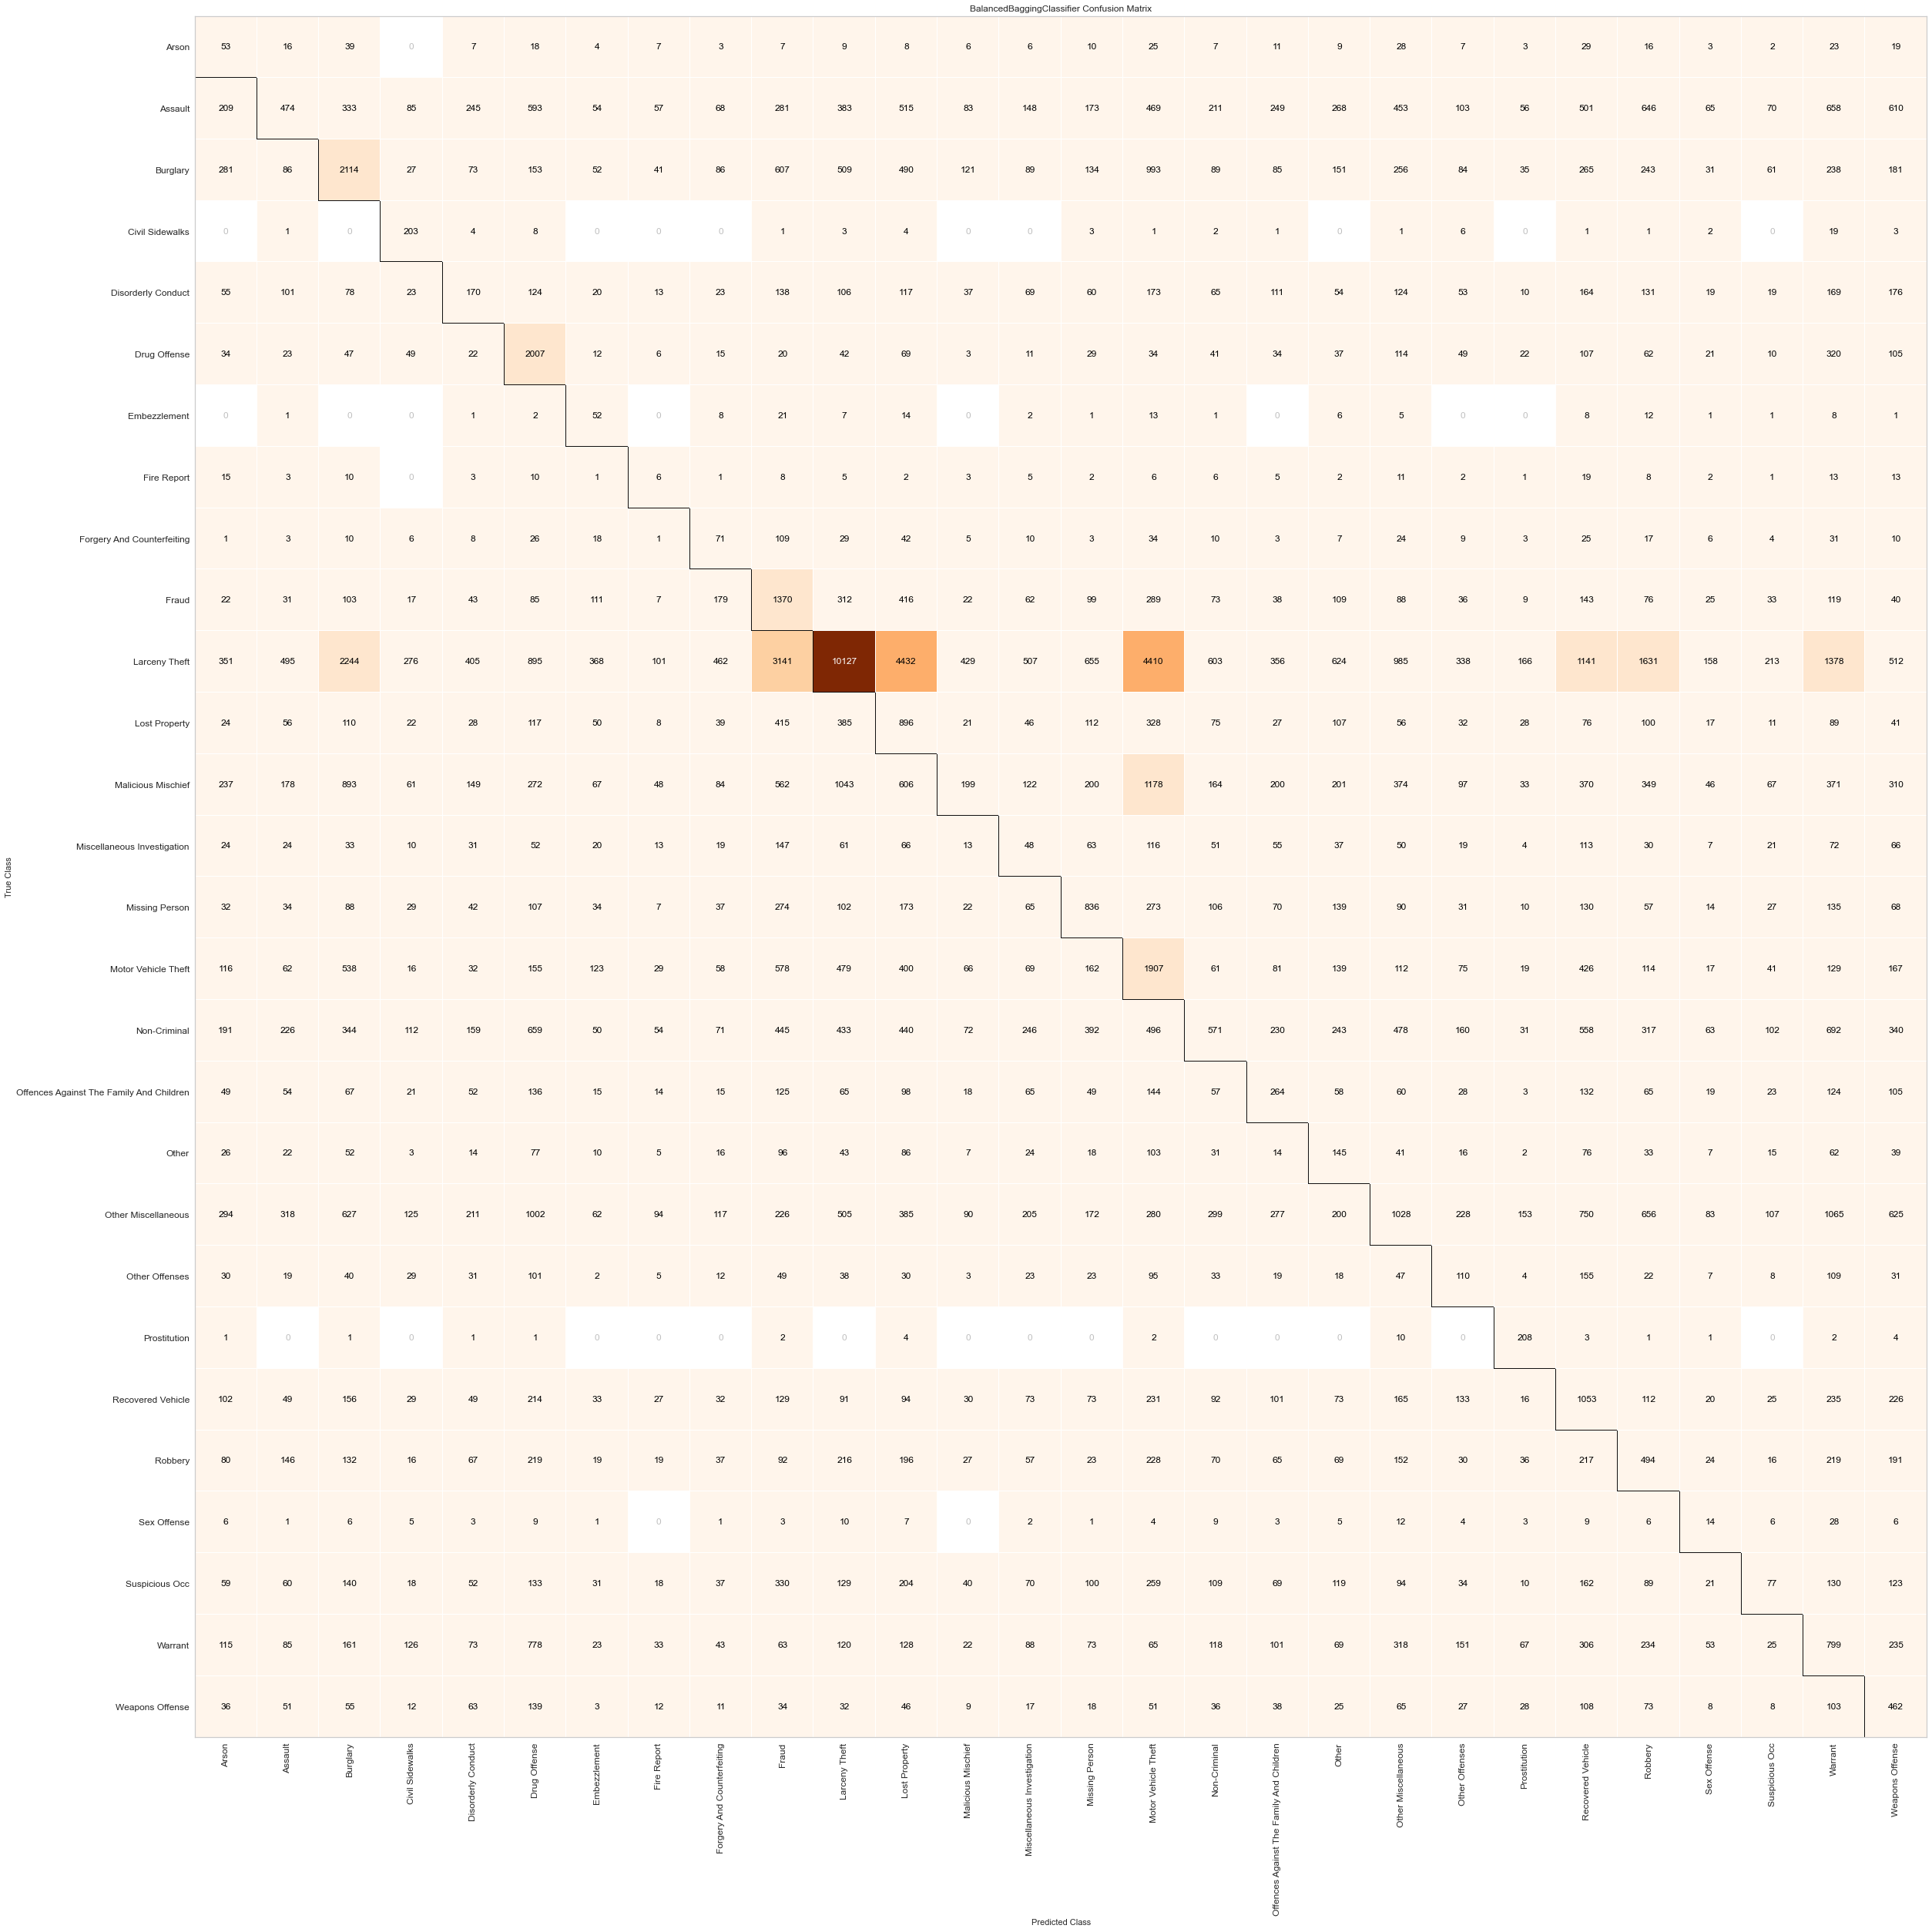

<AxesSubplot:title={'center':'BalancedBaggingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [237]:
#print out confisionMatrix
fig = plt.figure(figsize=(35,35))

confusion_BaggingClassifier = ConfusionMatrix(
    model, cmap="Oranges"
)

confusion_BaggingClassifier.fit(x_train, y_train)
confusion_BaggingClassifier.score(x_test, y_test)
#confusion_OverSamplingUnderSampling.show(outpath="png_prod\\Optional_06_TomekLinks_ConfusionMatrix.png")
confusion_BaggingClassifier.show()

In [238]:
clearMemory_callGC()

<Figure size 576x396 with 0 Axes>

## Takeaways
This dataset is affected by imbalanced classes -
This assignment findings is suggesting that by undresampling the minor classes, we can get to a good metrics. However this is not applicable in reality - we are almost certain that all the crimes are not going to appear at the same rate in any place

Some suggestions going forward - 
1. Have to look into multiple metrices or change metric to access the situation
1.1 Create by grid size (geograhical) - change problem static to crime rates per grid size 

2. Gather more data , look at social-economic indicators or other indicators related to crime + safety <br/>
     Eg : social angle: ( Amsterdam article – takes in census data + social economy indicators + geograpical indicators (eg nof of shops/banks/schools/nightclubs) <br/>
Eg. Geography angle : Look fo existing research using Night-time image analysis by grid to predict crime <br/> 
    Eg., Combine crime patterns with more features ( eg., which crime looks at neighbourhood safety and which crimes look 
    for day/night-time and which crimes affected by density of crowd in one area ) - may be to split different crime groups
    and build different models 

3. Hyperparmeters tuning can only tune so much - it cannot alleviate if the problem is caused by imbalance classes 
4. Not all models perform well under such dataset - look out for performance, balance between what we are looking for and time constraint 
5. Use neural network to try? 

### EXTRAS [ MAP ] 


In [ ]:
#STATIC map of districts if do not want to install folium

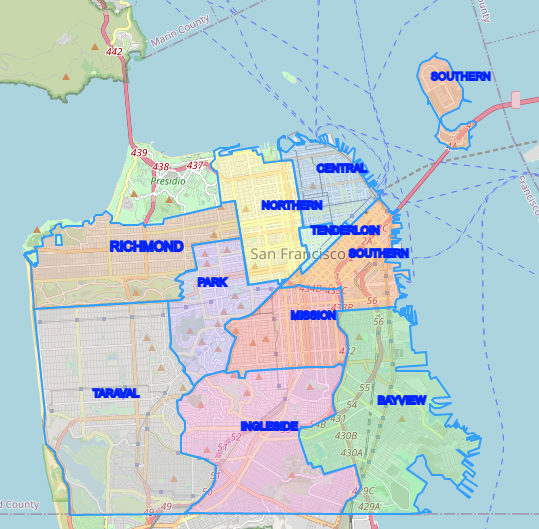